### setup

In [1]:
# imports
import os
import pathlib as path
import pandas as pd
import numpy as np
from statsmodels.stats.anova import AnovaRM
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.gridspec as gridspec
import basic_funcs as bf
from scipy.optimize import curve_fit
from scipy.stats import norm
import itertools as it
from scipy.optimize import fsolve
import warnings
import math
import pingouin as pg

from scipy.stats import ttest_rel
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [2]:
# funcs
def print_df(df):
    display(HTML(df.to_html()))
    
def get_mean_sd_se(df, col):
    mean = round(np.mean(df[col]), 2)
    sd = round(np.std(df[col]), 2)
    se = round(np.std(df[col]) / np.sqrt(len(list(df[col]))), 2)
    return mean, sd, se
    
def get_anova_desc(df, cols, avs):
    ret_df = {}
    keys = ["AV", "Info", "Mean", "SD", "SE"]
    for key in keys:
        ret_df[key] = []
    
    for av in avs:
        for col in cols:
            col_lvls = np.unique(df[col])
            
            for lvl in col_lvls:
                cut_df = df.query('`{0}` == @lvl'.format(col))
                
                mean = round(np.mean(cut_df[av]), 2)
                sd = round(np.std(cut_df[av]), 2)
                se = round(np.std(cut_df[av]) / np.sqrt(len(list(cut_df[av]))), 2)
                
                for key, val in zip(keys, [av, "{} - {}".format(col, lvl), mean, sd, se]):
                    ret_df[key].append(val)
                
        combis = ["{}_{}".format(x,y) for x in ["Restricted", "Unrestricted"] for y in ["Baseline", "Low", "High"]]
        for combi in combis:
            move, gain = combi.split("_")
            cut_df = df.query('Movement == @move & Gain == @gain')
            
            mean = round(np.mean(cut_df[av]), 2)
            sd = round(np.std(cut_df[av]), 2)
            se = round(np.std(cut_df[av]) / np.sqrt(len(list(cut_df[av]))), 2)
            
            # print("{} - {}: M {}, SD {}, SE {}".format(move, gain, mean, sd, se))
                
            for key, val in zip(keys, [av, "{} - {}".format(move, gain), mean, sd, se]):
                ret_df[key].append(val)
            
    return pd.DataFrame(ret_df)

def get_anova_desc_2(df, cols, avs):
    ret_df = {}
    keys = ["AV", "Info", "Mean", "SD", "SE"]
    for key in keys:
        ret_df[key] = []
    
    for av in avs:
        for col in cols:
            col_lvls = np.unique(df[col])
            
            for lvl in col_lvls:
                cut_df = df.query('`{0}` == @lvl'.format(col))
                
                mean = round(np.mean(cut_df[av]), 2)
                sd = round(np.std(cut_df[av]), 2)
                se = round(np.std(cut_df[av]) / np.sqrt(len(list(cut_df[av]))), 2)
                
                for key, val in zip(keys, [av, "HE: {} - {}".format(col, lvl), mean, sd, se]):
                    ret_df[key].append(val)
                
        if len(cols) > 1:
            combis = list(it.combinations(cols, 2))
            
            for combi in combis:
                col_a, col_b = combi 
                col_combi_combis = list(it.product(np.unique(df[col_a]), np.unique(df[col_b])))
                
                for col_combi in col_combi_combis:
                    lvl_a, lvl_b = col_combi
                    cut_df = df.query('`{}` == @lvl_a & `{}` == @lvl_b'.format(col_a, col_b))
                    
                    mean = round(np.mean(cut_df[av]), 2)
                    sd = round(np.std(cut_df[av]), 2)
                    se = round(np.std(cut_df[av]) / np.sqrt(len(list(cut_df[av]))), 2)
                        
                    for key, val in zip(keys, [av, "IE: {} - {}".format(lvl_a, lvl_b), mean, sd, se]):
                        ret_df[key].append(val)
                        
        if len(cols) > 2:
            combis = list(it.combinations(cols, 3))
            
            for combi in combis:
                col_a, col_b, col_c = combi 
                l = [
                    np.unique(df[col_a]), 
                    np.unique(df[col_b]), 
                    np.unique(df[col_c])
                ]
                col_combi_combis = list(it.product(*l))
                
                for col_combi in col_combi_combis:
                    lvl_a, lvl_b, lvl_c = col_combi
                    cut_df = df.query('`{}` == @lvl_a & `{}` == @lvl_b & `{}` == @lvl_c'.format(col_a, col_b, col_c))
                    
                    mean = round(np.mean(cut_df[av]), 2)
                    sd = round(np.std(cut_df[av]), 2)
                    se = round(np.std(cut_df[av]) / np.sqrt(len(list(cut_df[av]))), 2)
                        
                    for key, val in zip(keys, [av, "IE: {} - {} - {}".format(lvl_a, lvl_b, lvl_c), mean, sd, se]):
                        ret_df[key].append(val)
            
    return pd.DataFrame(ret_df)

def df_from_file(d_file):
    df = bf.df_from_log(d_file)
    df = bf.add_recode_resp(df, "Response", {"Left": 0, "Right": 1})
    
    # Shift in cm: -3, visual angle: -1.37
    # Shift in cm: -2, visual angle: -0.92
    # Shift in cm: -1, visual angle: -0.46
    # Shift in cm: 0, visual angle: 0.0
    # Shift in cm: 1, visual angle: 0.46
    # Shift in cm: 2, visual angle: 0.92
    # Shift in cm: 3, visual angle: 1.37
    df = bf.add_recode_resp(df, "TargetHoriPos", {-3: -1.37, -2: -0.92, -1: -0.46, 0: 0, 1: 0.46, 2: 0.92, 3: 1.37}) # here
    
    # special serial dependency stuff
    # df = serial_dependency_cols(df, "TargetSide", "TrialGain")
    # df = gain_categorize(df, "SD_Gain")
    # df = df.drop([df.index[0]]) # remove 1st trial since SD
    
    file_col = [d_file] * df.shape[0]
    df = df.assign(Filename = file_col)
    
    return df

def prob_stim_lvl(df,lvl_col,av_col):
    stim_lvls = np.sort(list(set(list(df[lvl_col]))))
    
    lvl_arr = []
    resp_arr = []
    points_arr = []
    
    for lvl in stim_lvls:
        lvl_arr.append(lvl)
        arr = []
        counter = 0
        
        for idx,row in df.iterrows():
            if row[lvl_col] == lvl:
                arr.append(row[av_col])
                counter = counter + 1
                
        resp_arr.append(bf.mean(arr))
        points_arr.append(counter)
                
    ret_dict = {"Lvl_Arr": lvl_arr, 
                "Resp_Arr": resp_arr, 
                "Num_Points": points_arr}
          
    return ret_dict

# pf funcs
def fit_func(x, y, points):
    start = x[0]
    stop = x[-1]
    t = np.linspace(start,stop, 1000) 

    # plot norm cdf func
    pse, jnd = curve_fit(norm.cdf, x, y, p0=[bf.mean(x), 1], maxfev=20000, method="dogbox")[0] # method{‘lm’, ‘trf’, ‘dogbox’}, trf "robust", dogbox works 2
    pf_r2 = calc_r2(y, [norm.cdf(x, pse, jnd) for x in x])
    
    pse_ir = False
    if pse >= start and pse <= stop:
        pse_ir = True
    
    points = bf.mean(points)
    
    ret_arr = [pse, jnd, pf_r2, pse_ir, points, x, y]
    
    return ret_arr

def pfs(df, av_col, lvl_col, plot_p):
    plot_dir = plot_p.joinpath("psy_funcs")
    
    # for p_dir in plot_dir:
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir, exist_ok=True)
    
    keys = ["SubjectID", "Movement", "Gain",
            "PSE", "JND", "PF_R2", "PSE_IR", "DataPoints", "X", "Y"]
    
    r_dict = {}
    for key in keys:
        r_dict[key] = []
    
    subs = np.sort(list(set(df["SubjectID"])))
    sub = list(subs)[0]
    # congs = np.sort(list(set(df["SD_Side"])))
    gains = np.sort(list(set(df["TrialGain"])))
    movements = np.sort(list(set(df["Version"])))
    
    colors = [["ko", "-k", 10], ["gh", "-g", 10], ["rd", "-r", 10]]
    colors_2 = [["ks", "--k", 10], ["gH", "--g", 10], ["rD", "--r", 10]]
    
    for movement in movements:
        cut_df = df[(df["Version"] == movement)] # & (df["TrialGain"] == gain)
        trials = cut_df["TrialNum"]
        pf_d = prob_stim_lvl(cut_df, lvl_col, av_col)
        
        if "GainHigh" in movement:
            gain_idx = 2
        else:
            if "Gain" in movement:
                gain_idx = 1
            else:
                gain_idx = 0
        
        if "NoMovement" in movement:
            mar, col, mar_size = colors_2[gain_idx]
        else:
            mar, col, mar_size = colors[gain_idx]
        
        pretty_movement = movement.replace("Gain", "").replace("High", "")
        pretty_gain = ["Baseline", "Gain", "HighGain"][gain_idx]
        
        if cut_df.shape[0] != 0:
            res = fit_func(pf_d["Lvl_Arr"], pf_d["Resp_Arr"], pf_d["Num_Points"])
            
            for key, val in zip(keys, [sub, pretty_movement, gains[gain_idx]] + res): 
                # print(key, val)
                r_dict[key].append(val)
        
    # for key in r_dict.keys():
    #     print(key, len(r_dict[key]))
        
    return pd.DataFrame(r_dict)

def balance_data(df, sub_col, cols):
    col_lvls = [list(set(list(df[col]))) for col in cols]
    combis_l = [x for x in it.product(*col_lvls)]
    
    subs = np.sort(list(set(df[sub_col])))
    inc_subs = []
    for sub in subs:
        sub_df = df[df[sub_col] == sub]
        
        # print(sub_df.shape[0], len(combis_l))
        # print_df(sub_df)
        
        if sub_df.shape[0] == len(combis_l):
            inc_subs.append(sub)
        
    return df[df[sub_col].isin(inc_subs)]

def calc_r2(y, y_fit):
    ss_tot = np.sum([np.power(np.mean(y) - y_val, 2) for y_val in y])
    ss_res = np.sum([np.power(y_fit_val - y_val, 2) for y_val, y_fit_val in zip(y, y_fit)])
    r_2 = 1 - (ss_res / ss_tot)
    
    return r_2

def func_025(x):
    return norm.cdf(x, pse, jnd) - 0.25

def func_075(x):
    return norm.cdf(x, pse, jnd) - 0.75

def solve_for_val(func, val, pse_val, jnd_val):
    global pse
    global jnd
    
    pse = pse_val
    jnd = jnd_val
    
    if func == 0.25:
        ret = fsolve(func_025, val, maxfev=20000)
    else:
        ret = fsolve(func_075, val, maxfev=20000)
        
    return ret

def single_sub_25_75(df, av_col, lvl_col):
    keys = ["SubjectID", "PSE_0.25", "PSE_0.75"]
    
    r_dict = {}
    for key in keys:
        r_dict[key] = []
    
    subs = np.sort(np.unique(df["SubjectID"]))
    
    for sub in subs: #[0:5]:
        cut_df = df[(df["SubjectID"] == sub)]
        psy_func_d = prob_stim_lvl(cut_df, lvl_col, av_col)
        
        if cut_df.shape[0] != 0:
            vals = fit_func(psy_func_d["Lvl_Arr"], psy_func_d["Resp_Arr"], psy_func_d["Num_Points"])
            pse, jnd = vals[:2]
            
            vals = []
            for pf_vals in [[pse, jnd]]: #, [pse_mean, jnd_mean]
                pse_val, jnd_val = pf_vals
                
                val_025 = solve_for_val(0.25, 0, pse_val, jnd_val) # fsolve(func_025, 0, maxfev=20000)
                val_075 = solve_for_val(0.75, 0, pse_val, jnd_val) # fsolve(func_075, 0, maxfev=20000)
                
                vals.extend([val_025, val_075])
            
            vals = [val[0] if type(val) == np.ndarray else val for val in vals]
            
            for key, val in zip(keys, [sub] + vals):
                r_dict[key].append(val)
        
    return pd.DataFrame(r_dict) # r_dict 

def dep_ttest(arr1, arr2, side, corr, b_print):
    t, p = ttest_rel(arr1, arr2, alternative=side)
    p = p * corr
    df = len(arr1) - 1
    
    if b_print:
        print("t({}) = {:.2f}, p = {:.3f}".format(df, t, p))
    
    return t, p, df

def angle_of_vectors(vec1, vec2, rel_idx):
    # dont use z
    # vec1, vec2 = vec1[0:2], vec2[0:2]
    
    scalar_product = np.dot(vec1, vec2)
    amount_vec1 = math.sqrt(np.sum([math.pow(x, 2) for x in vec1])) # betrag
    amount_vec2  = math.sqrt(np.sum([math.pow(x, 2) for x in vec2]))
    
    if (amount_vec1 * amount_vec2) != 0:
        angle = math.degrees(math.acos(scalar_product / (amount_vec1 * amount_vec2)))
    else:
        angle = np.nan
        
    if vec1[rel_idx] < vec2[rel_idx]: # angle below / left are negative
        angle = angle * (-1)
        
    return angle

def get_trial_object_positions(stimulus_shift, probe_vert_pos):
    fixation_size = 7.5 # 7.5 cm from center to outer edges
    fixation_pos = 10 # -10 and 10 degree (horizontal axis)
    stimulus_size = 10 # 10 cm from center to outer edges
    ref_vert_pos = probe_vert_pos * -1
    straight_vec = [250, 0, 0]

    object_positions = {
        "Fixation_Cross": {
            "Left_Cross": {
                "Left_Border": angle_of_vectors(straight_vec, [250, fixation_size, 0], 1) - fixation_pos,
                "Right_Border": (angle_of_vectors(straight_vec, [250, fixation_size, 0], 1) + fixation_pos) * -1,
                "Upper_Border": angle_of_vectors(straight_vec, [250, 0, -1 * fixation_size], 2),
                "Lower_Border": angle_of_vectors(straight_vec, [250, 0, -1 * fixation_size], 2) * -1
            },
            "Right_Cross": {
                "Left_Border": angle_of_vectors(straight_vec, [250, fixation_size, 0], 1) + fixation_pos,
                "Right_Border": angle_of_vectors(straight_vec, [250, fixation_size, 0], 0) + fixation_pos,
                "Upper_Border": angle_of_vectors(straight_vec, [250, 0, -1 * fixation_size], 2),
                "Lower_Border": angle_of_vectors(straight_vec, [250, 0, -1 * fixation_size], 2) * -1
            }
        },
        "Stimulus": {
            "Probe": {
                "Left_Border": angle_of_vectors(straight_vec, [250, stimulus_size, 0], 1),
                "Right_Border": (angle_of_vectors(straight_vec, [250, stimulus_size, 0], 1)) * -1,
                "Upper_Border": angle_of_vectors(straight_vec, [250, 0, probe_vert_pos + stimulus_size], 2),
                "Lower_Border": angle_of_vectors(straight_vec, [250, 0, probe_vert_pos - stimulus_size], 2)# * -1
            },
            "Reference": {
                "Left_Border": angle_of_vectors(straight_vec, [250, stimulus_size - stimulus_shift, 0], 1),
                "Right_Border": (angle_of_vectors(straight_vec, [250, stimulus_size + stimulus_shift, 0], 1)) * -1,
                "Upper_Border": angle_of_vectors(straight_vec, [250, 0, ref_vert_pos + stimulus_size], 2),
                "Lower_Border": angle_of_vectors(straight_vec, [250, 0, ref_vert_pos - stimulus_size], 2)# * -1
            }
        }
    }

    return object_positions

def lin_func(x, a, b):
    return a*x + b

def find_correct_files(sub, run, date, d_files, timing_files, head_pp_data, eye_pp_data):
    d_file = [x for x in d_files if "{}_{}_{}".format(sub, run, date) in x]
    timing_file = [x for x in timing_files if "{}_{}_{}".format(sub, run, date) in x]
    head_pp_d = [x for x in head_pp_data if "{}_{}_{}".format(sub, run, date) in x]
    eye_pp_d = [x for x in eye_pp_data if "{}_{}_{}".format(sub, run, date) in x]
    
    for idx, x in enumerate([d_file, timing_file, head_pp_d, eye_pp_d]):
        if len(x) > 1:
            print(idx, "several files found")
            print(np.array(x))
    
    return d_file[0], timing_file[0], head_pp_d[0], eye_pp_d[0]

def df_to_spss_df(df, cols, avs):
    vals = [np.unique(df[col]) for col in cols]
    combis = list(it.product(*vals))
    combis = [list(x) for x in combis]
    combis = [combi + [av] for av in avs for combi in combis]
    combis = ['_'.join(combi) for combi in combis]
    
    uni_subs = np.unique(df["SubjectID"])
    new_cols = {"SubjectID": uni_subs}
        
    for combi in combis:
        new_cols[combi] = []
        infos = combi.split("_")
        
        for sub in uni_subs:
            cut_df = df.query('SubjectID == @sub')
            
            for val, col in zip(infos, cols):
                cut_df = cut_df.query('`{}` == @val'.format(col))
                
            if cut_df[infos[-1]].shape[0] > 1:
                print(infos, cut_df[infos[-1]].shape[0])
                
            new_cols[combi].append(np.mean(cut_df[infos[-1]]))
        
    ret_df = pd.DataFrame(new_cols)
    return ret_df

In [3]:
# paths
scripts_p = path.Path.cwd()
stats_p = scripts_p.parents[1]
data_p = stats_p.joinpath("data","Round Effmann", "Raw")
plot_p = stats_p.joinpath("effmann","plots")
dfs_p = stats_p.joinpath("effmann","dfs")

stat_df_p = stats_p.joinpath("manuscript_2", "dfs")
figure_p = stats_p.joinpath("manuscript_2", "figures")
results_p = stats_p.joinpath("manuscript_2", "results")

In [4]:
# figure parameters
font_size = 16
parameters = {'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              "figure.titlesize": font_size,
              "xtick.labelsize": font_size,
              "ytick.labelsize": font_size,
              "legend.fontsize": font_size,
              "legend.title_fontsize": font_size}
plt.rcParams.update(parameters)
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : font_size}
plt.rc('font', **font)

colors = {
    "unrestricted": ["tab:orange", 1],
    "restricted": ["limegreen", 1],
    "unity": ["k", 0.5],
    "moderate": ["c", 1],
    "high": ["m", 1],
    "Head": ["tab:red", 1],
    "Eye": ["tab:blue", 1]
}

### sample + exp desc

In [5]:
# demographics
def print_demo_info(data):
    print("Num: {}, Age: Mean: {}, SD: {}, SE: {}".format(
        len(data["Alter"]),
        np.round(np.mean(data["Alter"]), 2),
        np.round(np.std(data["Alter"]), 2),
        np.round(np.std(data["Alter"]) / np.sqrt(data.shape[0]), 2)
    )
)

# print("Study 1")
demo_data = pd.read_csv(results_p.joinpath("demographics.csv"))
balanced_pse_df = pd.read_pickle(results_p.joinpath("balanced_pse_df.pickle"))

inc_subs = np.sort(np.unique(balanced_pse_df["SubjectID"]))
demo_data_cut = demo_data.query('SubjectID.isin(@inc_subs)')

# print("Whole Sample")
# print_demo_info(demo_data)

# print("\nCut Sample (based on balanced pse df)")
# print_demo_info(demo_data_cut)
# print(np.unique(demo_data_cut["Geschlecht"], return_counts=True))

#######################################

# print("\n----------------------------")
# print("Study 2")
demo_data_2 = pd.read_csv(results_p.joinpath("demographics_2.csv"))
balanced_pse_df_2 = pd.read_pickle(results_p.joinpath("balanced_pse_df_2.pickle"))

# inc_subs_2 = np.sort(np.unique(balanced_pse_df_2["SubjectID"]))
# inc_subs_2 = [x for x in inc_subs_2 if x != "DC21"]
inc_subs_2 = [
    'AD21', 'AO23', 'AP28', 'AS27', 'BW21', 'CF03', 'EW22', 'FA24', 'FH26', 'FS28', 
    'IB16', 'LC10', 'LK23', 'MF26', 'SH08', 'SJ24', 'SK29', 'SM03', 'ST07', 
    'SW217', 'TK15', 'TT12', 'VM20', 'YS24'
] # 'MM09' excluded based on 3000 JND in 1 cond

balanced_pse_df_2 = balanced_pse_df_2.query('SubjectID.isin(@inc_subs_2)')
demo_data_cut_2 = demo_data_2.query('SubjectID.isin(@inc_subs_2)')

# print("Whole Sample")
# print_demo_info(demo_data_2)

# print("\nCut Sample (based on balanced pse df)")
# print_demo_info(demo_data_cut_2)
# print(np.unique(demo_data_cut_2["Geschlecht"], return_counts=True))

# print("\nExcluded subs for exp 2: {}".format([x for x in list(np.unique(demo_data_2["SubjectID"])) if x not in inc_subs_2]))

balanced_pse_df_2 = None

In [6]:
# stimuli information
stimuli_infos = pd.read_pickle(results_p.joinpath("stimuli_infos.pickle"))

for stim in ["Left_Cross", "Right_Cross", "Probe", "Reference"]:
    stimuli_df = stimuli_infos.query('StimulusName == @stim')
    
    left_border = stimuli_df.query('Border == "Left_Border"').iloc[0]["BorderValue"]
    right_border = stimuli_df.query('Border == "Right_Border"').iloc[0]["BorderValue"]
    top_border = stimuli_df.query('Border == "Upper_Border"').iloc[0]["BorderValue"]
    lower_border = stimuli_df.query('Border == "Lower_Border"').iloc[0]["BorderValue"]
    
    print(stim, left_border, right_border)
    
    hori_pos = np.round(right_border - ((right_border - left_border) / 2))
    vert_pos = np.round(top_border - ((top_border - lower_border) / 2))
    
    hori_size = np.round(right_border - left_border, 2)
    vert_size = np.round(top_border - lower_border, 2)
    
    print(stim.replace("_", " "))
    print("Horizontal Pos: {}, Vertical Pos: {}".format(hori_pos, vert_pos))
    print("Horizontal Size: {}, Vertical Size: {}\n".format(hori_size, vert_size))
    
# stim infos
# fixaton object infos
    # -10 and 10 degree (horizontal axis)
    # 0 degree vertical pos
    # size from center 7.5 cm to both sides
    
# stimulus
    # 0 degree (horizontal axis)
    # 10 cm to both sides
    # 20 cm durchmesser

Left_Cross -11.718358001655501 -8.281641998344499
Left Cross
Horizontal Pos: -10.0, Vertical Pos: 0.0
Horizontal Size: 3.44, Vertical Size: 3.44

Right_Cross 8.281641998344499 11.718358001655501
Right Cross
Horizontal Pos: 10.0, Vertical Pos: 0.0
Horizontal Size: 3.44, Vertical Size: 3.44

Probe -2.976699468111829 2.976699468111829
Probe
Horizontal Pos: 0.0, Vertical Pos: -22.0
Horizontal Size: 5.95, Vertical Size: -3.95

Reference -2.976699468111829 2.976699468111829
Reference
Horizontal Pos: 0.0, Vertical Pos: 22.0
Horizontal Size: 5.95, Vertical Size: -3.95



In [7]:
# stimuli information for pse / jnd calculation
for shift in range(-3,4):
    positions = get_trial_object_positions(shift, 100)["Stimulus"]["Reference"]
    hori_angle_pos = np.round(positions["Right_Border"] + positions["Left_Border"], 2)
    print("Shift in cm: {}, visual angle: {}".format(shift, hori_angle_pos))#, [positions["Left_Border"], positions["Right_Border"]])

Shift in cm: -3, visual angle: -1.37
Shift in cm: -2, visual angle: -0.92
Shift in cm: -1, visual angle: -0.46
Shift in cm: 0, visual angle: 0.0
Shift in cm: 1, visual angle: 0.46
Shift in cm: 2, visual angle: 0.92
Shift in cm: 3, visual angle: 1.37


In [8]:
# eye fixation accuracy
def angle_of_vectors(vec1, vec2, rel_idx):
    # dont use z
    # vec1, vec2 = vec1[0:2], vec2[0:2]
    
    scalar_product = np.dot(vec1, vec2)
    amount_vec1 = math.sqrt(np.sum([math.pow(x, 2) for x in vec1])) # betrag
    amount_vec2  = math.sqrt(np.sum([math.pow(x, 2) for x in vec2]))
    
    if (amount_vec1 * amount_vec2) != 0:
        angle = math.degrees(math.acos(scalar_product / (amount_vec1 * amount_vec2)))
    else:
        angle = np.nan
        
    if vec1[rel_idx] < vec2[rel_idx]: # angle below / left are negative
        angle = angle * (-1)
        
    return angle

straight_vec = [250, 0, 0]
angle_of_vectors(straight_vec, [250, 5, 0], 1) #- 10

-1.1457628381754625

### prep tracking data

In [9]:
# prep head eye move data - exp 3
move_files = bf.get_data(stats_p.joinpath("effmann","dfs").joinpath("movement_pattern"), "pickle", "", [])
move_data = pd.DataFrame()
# move_data = pd.read_pickle(results_p.joinpath("move_df.pickle")).query('SubjectID.isin(@inc_subs)')
# move_data = move_data.query('Trial > 10')

for f in move_files:
    new_df = pd.read_pickle(f)
    
    head_dfs = []
    movement_conds = []
    gain_conds = []
    
    for idx, row in new_df.iterrows():
        head_df = row["HeadDF"]
        new_col = {"SDTime": [np.nan] + list(head_df["Time"])[:-1]}
        head_df = head_df.assign(**new_col)
        head_df = head_df.query('Time != SDTime')
        head_dfs.append(head_df)
        
        run = row["Run"]
        movement = "Unrestricted"
        gain = "Baseline"
        
        if "NoMovement" in run:
            movement = "Restricted"
        if "GainHigh" in run:
            gain = "High"
        elif "Gain" in run and "GainHigh" not in run:
            gain = "Low"
            
        movement_conds.append(movement)
        gain_conds.append(gain)
        
    new_col = {"HeadDF": head_dfs, "Movement": movement_conds, "Gain": gain_conds}
    new_df = new_df.assign(**new_col)
    
    move_data = pd.concat([move_data, new_df])
    
move_data = move_data.query('SubjectID.isin(@inc_subs)')
move_data = move_data.query('Trial > 10')

print("move_data")

c:\Users\serda\Desktop\CodeProjects\Python\analysis_venv\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
c:\Users\serda\Desktop\CodeProjects\Python\analysis_venv\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


move_data


In [10]:
# stim pres pos - mean pos - exp 3
cols = ['EyePositionsStimPres1', 'EyePositionsStimPres2', 'HeadPositionsStimPres1', 'HeadPositionsStimPres2']
mean_col_names = ["{}MeanYPos".format(x) for x in cols]
new_cols = {}
for key in mean_col_names:
    new_cols[key] = []

for idx, row in move_data.iterrows():
    vals = []
    
    for col in cols:
        df = row[col]
        
        if "Eye" in col:
            vals.append(np.mean(df["EyeAngle_Y"]))
        else:
            try:
                vals.append(np.mean(df["Yaw"]))
            except:
                print(row["SubjectID"], row["Run"])
            
    for key, val in zip(mean_col_names, vals):
        new_cols[key].append(val)
        
move_data = move_data.assign(**new_cols)
print("Added following cols: {}".format(mean_col_names))

Added following cols: ['EyePositionsStimPres1MeanYPos', 'EyePositionsStimPres2MeanYPos', 'HeadPositionsStimPres1MeanYPos', 'HeadPositionsStimPres2MeanYPos']


In [11]:
# stim pres pos - first pos - exp 3
cols = ['EyePositionsStimPres1', 'EyePositionsStimPres2', 'HeadPositionsStimPres1', 'HeadPositionsStimPres2']
first_col_names = ["{}FirstYPos".format(x) for x in cols]
new_cols = {}
for key in first_col_names:
    new_cols[key] = []

for idx, row in move_data.iterrows():
    vals = []
    
    for col in cols:
        df = row[col]
        
        if "Eye" in col:
            vals.append(list(df["EyeAngle_Y"])[0])
        else:
            try:
                vals.append(list(df["Yaw"])[0])
            except:
                vals.append(np.nan)
                print(row["SubjectID"], row["Run"])
            
    for key, val in zip(first_col_names, vals):
        new_cols[key].append(val)
        
move_data = move_data.assign(**new_cols)
print("Added following cols: {}".format(first_col_names))

KSIA NoMovementGain
RTBE NoMovementGain
Added following cols: ['EyePositionsStimPres1FirstYPos', 'EyePositionsStimPres2FirstYPos', 'HeadPositionsStimPres1FirstYPos', 'HeadPositionsStimPres2FirstYPos']


In [12]:
# prep move data exp 1/2
move_files_2 = bf.get_data(stats_p.joinpath("effmann 2","dfs").joinpath("movement_pattern"), "pickle", "", [])
move_data_2 = pd.DataFrame()

for f in move_files_2: #[:1]:
    file_infos = f.split("\\")[-1].split(".")[0].replace("[","").replace("]","").replace(" ","").replace("'","").split(",")
    new_df = pd.read_pickle(f)
    new_cols = {
        "Move": [file_infos[2]] * new_df.shape[0],
        "Target": [file_infos[3]] * new_df.shape[0],
        "Gabor": [file_infos[4]] * new_df.shape[0]
    }
    new_df = new_df.assign(**new_cols)
    
    head_dfs = []
    for idx, row in new_df.iterrows():
        head_df = row["HeadDF"]
        new_col = {"SDTime": [np.nan] + list(head_df["Time"])[:-1]}
        head_df = head_df.assign(**new_col)
        head_df = head_df.query('Time != SDTime')
        head_dfs.append(head_df)
        
    new_col = {"HeadDF": head_dfs}
    new_df = new_df.assign(**new_col)
    
    move_data_2 = pd.concat([move_data_2, new_df])
    
move_data_2 = move_data_2.query('SubjectID.isin(@inc_subs_2)')
move_data_2 = move_data_2.query('Trial > 10')
print("move_data_2")

move_data_2


In [13]:
# stim pres pos - mean pos - exp 1/2
cols = ['EyePositionsStimPres1', 'EyePositionsStimPres2', 'HeadPositionsStimPres1', 'HeadPositionsStimPres2']
mean_col_names = ["{}MeanYPos".format(x) for x in cols]
new_cols = {}
for key in mean_col_names:
    new_cols[key] = []

for idx, row in move_data_2.iterrows():
    vals = []
    
    for col in cols:
        df = row[col]
        
        if "Eye" in col:
            vals.append(np.mean(df["EyeAngle_Y"]))
        else:
            vals.append(np.mean(df["Yaw"]))
            
    for key, val in zip(mean_col_names, vals):
        new_cols[key].append(val)
        
move_data_2 = move_data_2.assign(**new_cols)
print("Added following cols: {}".format(mean_col_names))

Added following cols: ['EyePositionsStimPres1MeanYPos', 'EyePositionsStimPres2MeanYPos', 'HeadPositionsStimPres1MeanYPos', 'HeadPositionsStimPres2MeanYPos']


In [14]:
# stim pres pos - first pos - exp 1/2
cols = ['EyePositionsStimPres1', 'EyePositionsStimPres2', 'HeadPositionsStimPres1', 'HeadPositionsStimPres2']
first_col_names = ["{}FirstYPos".format(x) for x in cols]
new_cols = {}
for key in first_col_names:
    new_cols[key] = []

for idx, row in move_data_2.iterrows():
    vals = []
    
    for col in cols:
        df = row[col]
        
        if "Eye" in col:
            try:
                vals.append(list(df["EyeAngle_Y"])[0])
            except:
                print(row["SubjectID"], row["Run"])
                vals.append(np.nan)
        else:
            try:
                vals.append(list(df["Yaw"])[0])
            except:
                vals.append(np.nan)
                print(row["SubjectID"], row["Run"])
            
    for key, val in zip(first_col_names, vals):
        new_cols[key].append(val)
        
move_data_2 = move_data_2.assign(**new_cols)
print("Added following cols: {}".format(first_col_names))

VM20 Eye
Added following cols: ['EyePositionsStimPres1FirstYPos', 'EyePositionsStimPres2FirstYPos', 'HeadPositionsStimPres1FirstYPos', 'HeadPositionsStimPres2FirstYPos']


In [15]:
# add mean head pos
new_col = {"MeanHeadPos": []}

for idx, row in move_data_2.iterrows():
    new_col["MeanHeadPos"].append(np.mean(row["HeadDF"]["Yaw"]))
    
move_data_2 = move_data_2.assign(**new_col)

print("Added MeanHeadPos")

Added MeanHeadPos


### results

In [16]:
# demographics
def print_demo_info(data):
    print("Num: {}, Age: Mean: {}, SD: {}, SE: {}".format(
        len(data["Alter"]),
        np.round(np.mean(data["Alter"]), 2),
        np.round(np.std(data["Alter"]), 2),
        np.round(np.std(data["Alter"]) / np.sqrt(data.shape[0]), 2)
    )
)
print("Study 1 + 2")
demo_data_2 = pd.read_csv(results_p.joinpath("demographics_2.csv"))
balanced_pse_df_2 = pd.read_pickle(results_p.joinpath("balanced_pse_df_2.pickle"))

# inc_subs_2 = np.sort(np.unique(balanced_pse_df_2["SubjectID"]))
# inc_subs_2 = [x for x in inc_subs_2 if x != "DC21"]
inc_subs_2 = [
    'AD21', 'AO23', 'AP28', 'AS27', 'BW21', 'CF03', 'EW22', 'FA24', 'FH26', 'FS28', 
    'IB16', 'LC10', 'LK23', 'MF26', 'SH08', 'SJ24', 'SK29', 'SM03', 'ST07', 
    'SW217', 'TK15', 'TT12', 'VM20', 'YS24'
] # 'MM09' excluded based on 3000 JND in 1 cond

balanced_pse_df_2 = balanced_pse_df_2.query('SubjectID.isin(@inc_subs_2)')
demo_data_cut_2 = demo_data_2.query('SubjectID.isin(@inc_subs_2)')

print("Whole Sample")
print_demo_info(demo_data_2)

print("\nCut Sample (based on balanced pse df)")
print_demo_info(demo_data_cut_2)
print(np.unique(demo_data_cut_2["Geschlecht"], return_counts=True))

print("\nExcluded subs for exp 2: {}".format([x for x in list(np.unique(demo_data_2["SubjectID"])) if x not in inc_subs_2]))

balanced_pse_df_2 = None

#######################################

print("\n----------------------------")
print("Study 3")
demo_data = pd.read_csv(results_p.joinpath("demographics.csv"))
balanced_pse_df = pd.read_pickle(results_p.joinpath("balanced_pse_df.pickle"))

inc_subs = np.sort(np.unique(balanced_pse_df["SubjectID"]))
demo_data_cut = demo_data.query('SubjectID.isin(@inc_subs)')

print("Whole Sample")
print_demo_info(demo_data)

print("\nCut Sample (based on balanced pse df)")
print_demo_info(demo_data_cut)
print(np.unique(demo_data_cut["Geschlecht"], return_counts=True))

Study 1 + 2
Whole Sample
Num: 35, Age: Mean: 24.4, SD: 4.0, SE: 0.68

Cut Sample (based on balanced pse df)
Num: 24, Age: Mean: 24.29, SD: 4.12, SE: 0.84
(array(['männlich', 'weiblich'], dtype=object), array([ 6, 18], dtype=int64))

Excluded subs for exp 2: ['AT23', 'CS19', 'DC21', 'HS02', 'LB01', 'LS22', 'ML27', 'MM09', 'MR12', 'SNK20', 'VL27']

----------------------------
Study 3
Whole Sample
Num: 37, Age: Mean: 21.41, SD: 2.95, SE: 0.49

Cut Sample (based on balanced pse df)
Num: 26, Age: Mean: 21.04, SD: 2.1, SE: 0.41
(array(['m', 'w'], dtype=object), array([ 2, 24], dtype=int64))


In [17]:
# check real exclusions - exp 1/2
move_data_2_cut = move_data_2
cols = ['EyePositionsStimPres1MeanYPos', 'EyePositionsStimPres2MeanYPos']#, 'HeadPositionsStimPres1MeanYPos', 'HeadPositionsStimPres2MeanYPos']
# cols = [x.replace("Mean", "First") for x in cols]

# old exclusion based on fixation
# for col in cols:
#     if "Pres1" in col:
#         move_data_2_cut = move_data_2_cut.query("`{0}` >= -13 & `{0}` <= -7".format(col))
#     else:
#         move_data_2_cut = move_data_2_cut.query("`{0}` >= 7 & `{0}` <= 13".format(col))

move_data_2_cut = move_data_2_cut.query('HeadMoveAmplitudeY >= 10 | Run == "Eye"')
    
print("Exp 1 & 2: included {} of {} trials ({:.2f} %) based on head amplitude".format(move_data_2_cut.shape[0], move_data_2.shape[0], move_data_2_cut.shape[0] / move_data_2.shape[0] * 100))

num_3 = move_data_2_cut.shape[0]
num_4 = move_data_2.shape[0]

move_data_2 = move_data_2_cut

Exp 1 & 2: included 15498 of 16116 trials (96.17 %) based on head amplitude


In [18]:
# check real exclusions - exp 3
move_data_cut = move_data
cols = ['EyePositionsStimPres1MeanYPos', 'EyePositionsStimPres2MeanYPos']#, 'HeadPositionsStimPres1MeanYPos', 'HeadPositionsStimPres2MeanYPos']
cols = [x.replace("Mean", "First") for x in cols]

# old exclusion based on fixation
# for col in cols:
#     if "Pres1" in col:
#         move_data_cut = move_data_cut.query("`{0}` >= -13 & `{0}` <= -7".format(col))
#     else:
#         move_data_cut = move_data_cut.query("`{0}` >= 7 & `{0}` <= 13".format(col))
    
# new exclusion based on head movement
move_data_cut = move_data_cut.query('HeadMoveAmplitudeY >= 10')
    
print("Exp 3: included {} of {} trials ({:.2f} %) based on head amplitude".format(move_data_cut.shape[0], move_data.shape[0], move_data_cut.shape[0] / move_data.shape[0] * 100))

num_1 = move_data_cut.shape[0]
num_2 = move_data.shape[0]

move_data = move_data_cut

Exp 3: included 8680 of 8736 trials (99.36 %) based on head amplitude


In [19]:
# total exclusions based on head movement data (fixed vals)
num = num_2 - num_1 + num_4 - num_3
total = num_1 + num_4

print("Total trials based on head movement excluded: {:.2f} ({:.2f})".format(num, num / total * 100))

Total trials based on head movement excluded: 674.00 (2.72)


In [20]:
# get python app head hz recording
all_in_one = pd.concat([move_data, move_data_2])
for exp, data in [["Whole Exp", all_in_one], ["Exp 1/2", move_data_2], ["Exp 3", move_data]]:
    hzs = []

    for idx, row in data.iterrows():
        row_head_df = row["HeadDF"]
        num_samples = row_head_df.shape[0]
        dur = (row_head_df["Time"].iloc[-1] - row_head_df["Time"].iloc[0]) / 1_000
        hz = num_samples / dur
        hzs.append(hz)
        
    data = data.assign(HeadHZ = hzs)
    hz_vals = list(data["HeadHZ"])
    print("{}: Head recording hz: {:.2f} ({:.2f})".format(exp, np.mean(hz_vals), np.std(hz_vals) / np.sqrt(len(hz_vals))))

Whole Exp: Head recording hz: 913.68 (0.74)
Exp 1/2: Head recording hz: 989.51 (0.09)
Exp 3: Head recording hz: 778.29 (0.97)


#### exp 1

In [21]:
# head inference stats desc - exp 2
move_data_means = move_data_2.query('Run == "HeadEye"').groupby(["SubjectID", "Move", "Target", "Gabor"]).mean().reset_index()
head_desc_2 = get_anova_desc_2(move_data_means, ["Move", "Target", "Gabor"], ["HeadMovePeakVelocityY", "HeadMoveAmplitudeY", "HeadMoveDurationY"])
# head_desc_2
print("head_desc_2")

head_desc_2


Main Sequence
Formula: y = 12.87 + 1.29x
Single subject slopes vs. 0 (one-sided): t(23) = 12.23, p = 0.0


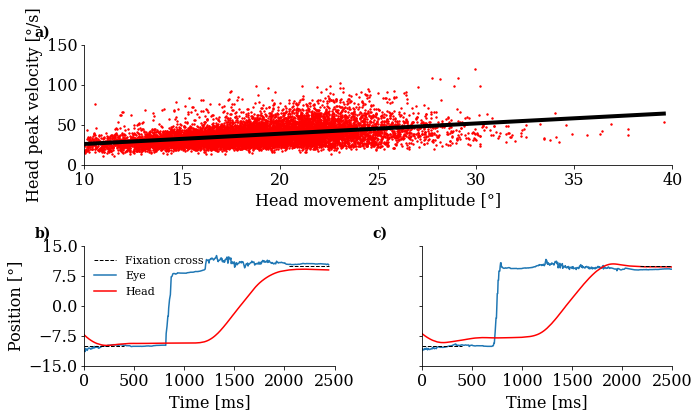

In [22]:
# head main sequence - exp 2
plot_data = move_data_2.query('Run == "HeadEye"')

fig = plt.figure(figsize=[10, 8], tight_layout=True)
gs = gridspec.GridSpec(3, 2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

axs = [ax1, ax2, ax3]
letters = ["a)", "b)", "c)"]

for idx, plot in enumerate(["Seq", "ExampleMove", "ExampleNoMove"]):
    ax = axs[idx]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if idx == 0:
        ax.text(-0.085, 1.1, letters[idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14, fontweight= "bold")
    else:
        ax.text(-0.2, 1.1, letters[idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14, fontweight= "bold")
    
    if plot == "Seq":
        end_positions = plot_data["HeadMoveAmplitudeY"] #main_sequence_plot_data["Scatter"]["EndPositions"]
        velocities = plot_data["HeadMovePeakVelocityY"] #main_sequence_plot_data["Scatter"]["Velocities"]
        plot_x = np.linspace(np.min(end_positions), np.max(end_positions), 1000)
        
        end_positions = [x for x in end_positions if not np.isnan(x)]
        velocities = [x for x in velocities if not np.isnan(x)]
        
        slope, intercept = curve_fit(lin_func, end_positions, velocities)[0]
        
        print("Main Sequence")
        print("Formula: y = {} + {}x".format(np.round(intercept, 2), np.round(slope, 2)))
        
        ax.scatter(end_positions, velocities, marker="o", color="r", s=2)#, alpha=0.5)
        ax.plot(plot_x, lin_func(plot_x, slope, intercept), color="k", linewidth=4)#, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
        
        ax.set_ylabel("Head peak velocity [°/s]")
        ax.set_xlabel("Head movement amplitude [°]")
        ax.set_xticks([10,15,20,25,30,35,40])
        ax.set_xlim([10, 40])
        ax.set_ylim([0, 150])
        
        # slope inference
        slopes = []
        
        for sub in np.unique(plot_data["SubjectID"]):
            sub_df = plot_data.query('SubjectID == @sub')
            end_positions = sub_df["HeadMoveAmplitudeY"]
            velocities = sub_df["HeadMovePeakVelocityY"]
            
            end_positions = [x for x in end_positions if not np.isnan(x)]
            velocities = [x for x in velocities if not np.isnan(x)]
            
            slope, intercept = curve_fit(lin_func, end_positions, velocities)[0]
            slopes.append(slope)
            
        t,p = ttest_1samp(slopes, popmean=0, alternative="greater")
        print("Single subject slopes vs. 0 (one-sided): t({}) = {}, p = {}".format(len(slopes) - 1, np.round(t,2), np.round(p,3)))
    elif plot == "ExampleMove":
        # LC10_HeadEye_Movement_TemporaryTargets_Gabor_60
        # LC10_HeadEye_Movement_TemporaryTargets_Gabor_53
        # LC10_HeadEye_Movement_TemporaryTargets_Gabor_52
        # LC10_HeadEye_Movement_TemporaryTargets_Gabor_50
        # LC10_HeadEye_Movement_TemporaryTargets_Gabor_18
        
        sub, run, move, target, gabor, trial = ["LC10", "HeadEye", "Movement", "TemporaryTargets", "Gabor", 18] # ALKA_Movement_23
        example_df = plot_data.query('SubjectID == @sub & Run == @run & Move == @move & Target == @target & Gabor == @gabor & Trial == @trial')

        trial_eye_df = example_df["EyeDF"].iloc[0]
        trial_head_df = example_df["HeadDF"].iloc[0]
        
        new_col = {"SDYaw": [np.nan] + list(trial_head_df["Yaw"])[:-1]}
        trial_head_df = trial_head_df.assign(**new_col)
        trial_head_df = trial_head_df.query('Yaw != SDYaw')
        
        new_col = {"SDEyeAngle_Y": [np.nan] + list(trial_eye_df["EyeAngle_Y"])[:-1]}
        trial_eye_df = trial_eye_df.assign(**new_col)
        trial_eye_df = trial_eye_df.query('SDEyeAngle_Y != EyeAngle_Y')
        
        # print_df(trial_eye_df.head(10))

        d_timing_files = np.sort(bf.get_data(stats_p.joinpath("effmann 2", "data","preprocessed"),"pickle","timings", []))
        timing_f = [x for x in d_timing_files if sub in x and "{}_{}_{}_{}_{}".format(sub, run, move, target, gabor) in x][0]
        timing_df = pd.read_pickle(timing_f)
        trial_timing_df = timing_df.query('Trial == @trial')

        trial, pre, start, end, f_onset, f_offset, s_onset, s_offset = trial_timing_df.iloc[0] 
        f_onset, f_offset, s_onset, s_offset = [(x - start) / 1_000_000 for x in [f_onset, f_offset, s_onset, s_offset]]

        example_trial_dict = {"EyeDF": trial_eye_df, "HeadDF": trial_head_df, "FirstStimulus": [f_onset, f_offset], "SecondStimulus": [s_onset, s_offset]}
        
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("Position [°]")
        ylims = [-15, 15]
        ax.set_ylim(ylims)
        ax.set_yticks([-15,-7.5,0,7.5,15])
        
        first_stim_info = example_trial_dict["FirstStimulus"]
        second_stim_info = example_trial_dict["SecondStimulus"]
        line_width = 1
        ax.hlines(-10, xmin=first_stim_info[0], xmax=first_stim_info[-1], color="k", ls="--", lw=line_width, zorder=10, label="Fixation cross")
        ax.hlines(10, xmin=second_stim_info[0], xmax=second_stim_info[-1], color="k", ls="--", lw=line_width, zorder=10)
        
        eye_time = example_trial_dict["EyeDF"]["Time"]
        eye_pos = example_trial_dict["EyeDF"]["EyeAngle_Y"]
        
        head_time = example_trial_dict["HeadDF"]["Time"]
        head_pos = example_trial_dict["HeadDF"]["Yaw"]
        
        ax.plot(eye_time, eye_pos, color="tab:blue", label="Eye")
        ax.plot(head_time, head_pos, color="r", label="Head")
        
        
        times = list(eye_time) + list(head_time)
        ax.set_xlim([0, 2500])
        ax.legend(loc="upper left", frameon=False, fontsize="11")
    elif plot == "ExampleNoMove":
        # AD21_HeadEye_NoMovement_PermanentTargets_Gabor_15
        # ML27_HeadEye_NoMovement_TemporaryTargets_NoGabor_59
        # ML27_HeadEye_NoMovement_TemporaryTargets_NoGabor_43
        # ML27_HeadEye_NoMovement_TemporaryTargets_NoGabor_40
        # LC10_HeadEye_NoMovement_TemporaryTargets_NoGabor_63
        # LC10_HeadEye_NoMovement_TemporaryTargets_NoGabor_62
        sub, run, move, target, gabor, trial = ["LC10", "HeadEye", "NoMovement", "TemporaryTargets", "NoGabor", 63] # ALKA_Movement_23
        example_df = plot_data.query('SubjectID == @sub & Run == @run & Move == @move & Target == @target & Gabor == @gabor & Trial == @trial')
        
        # sub, move, trial = ["ALKA", "NoMovement", 65] # ALKA_Movement_23
        # example_df = move_data_2.query('SubjectID == @sub & Run == @move & Trial == @trial')

        trial_eye_df = example_df["EyeDF"].iloc[0]
        trial_head_df = example_df["HeadDF"].iloc[0]
        
        new_col = {"SDYaw": [np.nan] + list(trial_head_df["Yaw"])[:-1]}
        trial_head_df = trial_head_df.assign(**new_col)
        trial_head_df = trial_head_df.query('Yaw != SDYaw')
        
        new_col = {"SDEyeAngle_Y": [np.nan] + list(trial_eye_df["EyeAngle_Y"])[:-1]}
        trial_eye_df = trial_eye_df.assign(**new_col)
        trial_eye_df = trial_eye_df.query('SDEyeAngle_Y != EyeAngle_Y')

        d_timing_files = np.sort(bf.get_data(stats_p.joinpath("effmann 2", "data","preprocessed"),"pickle","timings", []))
        timing_f = [x for x in d_timing_files if sub in x and "{}_{}_{}_{}_{}".format(sub, run, move, target, gabor) in x][0]
        timing_df = pd.read_pickle(timing_f)
        trial_timing_df = timing_df.query('Trial == @trial')

        trial, pre, start, end, f_onset, f_offset, s_onset, s_offset = trial_timing_df.iloc[0] 
        f_onset, f_offset, s_onset, s_offset = [(x - start) / 1_000_000 for x in [f_onset, f_offset, s_onset, s_offset]]

        example_trial_dict = {"EyeDF": trial_eye_df, "HeadDF": trial_head_df, "FirstStimulus": [f_onset, f_offset], "SecondStimulus": [s_onset, s_offset]}
        
        ax.set_xlabel("Time [ms]")
        # ax.set_ylabel("Position [°]")
        ylims = [-15, 15]
        ax.set_ylim(ylims)
        ax.set_yticks([-15,-7.5,0,7.5,15])
        ax.set_yticklabels([])
        
        first_stim_info = example_trial_dict["FirstStimulus"]
        second_stim_info = example_trial_dict["SecondStimulus"]
        line_width = 1
        ax.hlines(-10, xmin=first_stim_info[0], xmax=first_stim_info[-1], color="k", ls="--", lw=line_width, zorder=10, label="Fixation cross")
        ax.hlines(10, xmin=second_stim_info[0], xmax=second_stim_info[-1], color="k", ls="--", lw=line_width, zorder=10)
        
        eye_time = example_trial_dict["EyeDF"]["Time"]
        eye_pos = example_trial_dict["EyeDF"]["EyeAngle_Y"]
        
        head_time = example_trial_dict["HeadDF"]["Time"]
        head_pos = example_trial_dict["HeadDF"]["Yaw"]
        
        ax.plot(eye_time, eye_pos, color="tab:blue", label="Eye")
        ax.plot(head_time, head_pos, color="r", label="Head")
        
        times = list(eye_time) + list(head_time)
        ax.set_xlim([0, 2500])
        # ax.legend(loc="upper left", frameon=False, fontsize="11")
        
plt.savefig(figure_p.joinpath("exp2_main_seq.png"), dpi=300, facecolor="white", bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp2_main_seq.pdf"), dpi=300, facecolor="white", bbox_inches="tight")

Main Sequence
Formula: y = 0.81 + 2.34x
Single subject slopes vs. 0 (one-sided): t(25) = 13.9, p = 0.0


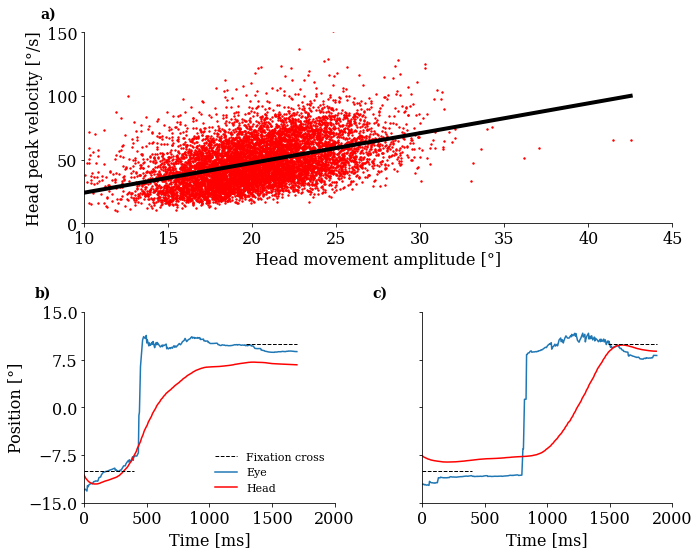

In [23]:
# head main sequence - exp 3
fig = plt.figure(figsize=[10, 8], tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

axs = [ax1, ax2, ax3]
letters = ["a)", "b)", "c)"]

for idx, plot in enumerate(["Seq", "ExampleMove", "ExampleNoMove"]):
    ax = axs[idx]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if idx == 0:
        ax.text(-0.075, 1.1, letters[idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14, fontweight= "bold")
    else:
        ax.text(-0.2, 1.1, letters[idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14, fontweight= "bold")
    
    if plot == "Seq":
        end_positions = move_data["HeadMoveAmplitudeY"] #main_sequence_plot_data["Scatter"]["EndPositions"]
        velocities = move_data["HeadMovePeakVelocityY"] #main_sequence_plot_data["Scatter"]["Velocities"]
        plot_x = np.linspace(np.min(end_positions), np.max(end_positions), 1000)
        slope, intercept = curve_fit(lin_func, end_positions, velocities)[0]
        
        print("Main Sequence")
        print("Formula: y = {} + {}x".format(np.round(intercept, 2), np.round(slope, 2)))
        
        ax.scatter(end_positions, velocities, marker="o", color="r", s=2)#, alpha=0.5)
        ax.plot(plot_x, lin_func(plot_x, slope, intercept), color="k", linewidth=4)#, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
        
        ax.set_ylabel("Head peak velocity [°/s]")
        ax.set_xlabel("Head movement amplitude [°]")
        ax.set_xticks([10,15,20,25,30,35,40,45])
        ax.set_xlim([10, 45])
        ax.set_ylim([0, 150])
        
        # slope inference
        slopes = []
        
        for sub in np.unique(move_data["SubjectID"]):
            sub_df = move_data.query('SubjectID == @sub')
            end_positions = sub_df["HeadMoveAmplitudeY"]
            velocities = sub_df["HeadMovePeakVelocityY"]
            slope, intercept = curve_fit(lin_func, end_positions, velocities)[0]
            slopes.append(slope)
            
        t,p = ttest_1samp(slopes, popmean=0, alternative="greater")
        print("Single subject slopes vs. 0 (one-sided): t({}) = {}, p = {}".format(len(slopes) - 1, np.round(t,2), np.round(p,3)))
    elif plot == "ExampleMove":
        sub, move, trial = ["ALKA", "Movement", 24] # ALKA_Movement_23
        example_df = move_data.query('SubjectID == @sub & Run == @move & Trial == @trial')

        trial_eye_df = example_df["EyeDF"].iloc[0]
        trial_head_df = example_df["HeadDF"].iloc[0]
        
        new_col = {"SDYaw": [np.nan] + list(trial_head_df["Yaw"])[:-1]}
        trial_head_df = trial_head_df.assign(**new_col)
        trial_head_df = trial_head_df.query('Yaw != SDYaw')
        
        new_col = {"SDEyeAngle_Y": [np.nan] + list(trial_eye_df["EyeAngle_Y"])[:-1]}
        trial_eye_df = trial_eye_df.assign(**new_col)
        trial_eye_df = trial_eye_df.query('SDEyeAngle_Y != EyeAngle_Y')
        
        # print_df(trial_eye_df.head(10))

        d_timing_files = np.sort(bf.get_data(stats_p.joinpath("data","Round Effmann", "Preprocessed"),"pickle","timings", []))
        timing_df = pd.read_pickle([x for x in d_timing_files if sub in x and "_{}_".format(move) in x][0])
        trial_timing_df = timing_df.query('Trial == @trial')

        trial, pre, start, end, f_onset, f_offset, s_onset, s_offset = trial_timing_df.iloc[0] 
        f_onset, f_offset, s_onset, s_offset = [(x - start) / 1_000_000 for x in [f_onset, f_offset, s_onset, s_offset]]

        example_trial_dict = {"EyeDF": trial_eye_df, "HeadDF": trial_head_df, "FirstStimulus": [f_onset, f_offset], "SecondStimulus": [s_onset, s_offset]}
        
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("Position [°]")
        ylims = [-15, 15]
        ax.set_ylim(ylims)
        ax.set_yticks([-15,-7.5,0,7.5,15])
        
        first_stim_info = example_trial_dict["FirstStimulus"]
        second_stim_info = example_trial_dict["SecondStimulus"]
        line_width = 1
        ax.hlines(-10, xmin=first_stim_info[0], xmax=first_stim_info[-1], color="k", ls="--", lw=line_width, zorder=10, label="Fixation cross")
        ax.hlines(10, xmin=second_stim_info[0], xmax=second_stim_info[-1], color="k", ls="--", lw=line_width, zorder=10)
        
        eye_time = example_trial_dict["EyeDF"]["Time"]
        eye_pos = example_trial_dict["EyeDF"]["EyeAngle_Y"]
        
        head_time = example_trial_dict["HeadDF"]["Time"]
        head_pos = example_trial_dict["HeadDF"]["Yaw"]
        
        ax.plot(eye_time, eye_pos, color="tab:blue", label="Eye")
        ax.plot(head_time, head_pos, color="r", label="Head")
        
        
        times = list(eye_time) + list(head_time)
        ax.set_xlim([0, 2000])
        ax.legend(loc="lower right", frameon=False, fontsize="11")
    elif plot == "ExampleNoMove":
        sub, move, trial = ["ALKA", "NoMovement", 65] # ALKA_Movement_23
        example_df = move_data.query('SubjectID == @sub & Run == @move & Trial == @trial')

        trial_eye_df = example_df["EyeDF"].iloc[0]
        trial_head_df = example_df["HeadDF"].iloc[0]
        
        new_col = {"SDYaw": [np.nan] + list(trial_head_df["Yaw"])[:-1]}
        trial_head_df = trial_head_df.assign(**new_col)
        trial_head_df = trial_head_df.query('Yaw != SDYaw')
        
        new_col = {"SDEyeAngle_Y": [np.nan] + list(trial_eye_df["EyeAngle_Y"])[:-1]}
        trial_eye_df = trial_eye_df.assign(**new_col)
        trial_eye_df = trial_eye_df.query('SDEyeAngle_Y != EyeAngle_Y')

        d_timing_files = np.sort(bf.get_data(stats_p.joinpath("data","Round Effmann", "Preprocessed"),"pickle","timings", []))
        timing_df = pd.read_pickle([x for x in d_timing_files if sub in x and "_{}_".format(move) in x][0])
        trial_timing_df = timing_df.query('Trial == @trial')

        trial, pre, start, end, f_onset, f_offset, s_onset, s_offset = trial_timing_df.iloc[0] 
        f_onset, f_offset, s_onset, s_offset = [(x - start) / 1_000_000 for x in [f_onset, f_offset, s_onset, s_offset]]

        example_trial_dict = {"EyeDF": trial_eye_df, "HeadDF": trial_head_df, "FirstStimulus": [f_onset, f_offset], "SecondStimulus": [s_onset, s_offset]}
        
        ax.set_xlabel("Time [ms]")
        # ax.set_ylabel("Position [°]")
        ylims = [-15, 15]
        ax.set_ylim(ylims)
        ax.set_yticks([-15,-7.5,0,7.5,15])
        ax.set_yticklabels([])
        
        first_stim_info = example_trial_dict["FirstStimulus"]
        second_stim_info = example_trial_dict["SecondStimulus"]
        line_width = 1
        ax.hlines(-10, xmin=first_stim_info[0], xmax=first_stim_info[-1], color="k", ls="--", lw=line_width, zorder=10, label="Fixation cross")
        ax.hlines(10, xmin=second_stim_info[0], xmax=second_stim_info[-1], color="k", ls="--", lw=line_width, zorder=10)
        
        eye_time = example_trial_dict["EyeDF"]["Time"]
        eye_pos = example_trial_dict["EyeDF"]["EyeAngle_Y"]
        
        head_time = example_trial_dict["HeadDF"]["Time"]
        head_pos = example_trial_dict["HeadDF"]["Yaw"]
        
        ax.plot(eye_time, eye_pos, color="tab:blue", label="Eye")
        ax.plot(head_time, head_pos, color="r", label="Head")
        
        times = list(eye_time) + list(head_time)
        ax.set_xlim([0, 2000])
        # ax.legend(loc="upper left", frameon=False, fontsize="11")
        
plt.savefig(figure_p.joinpath("exp3_main_seq.png"), dpi=300, facecolor="white", bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp3_main_seq.pdf"), dpi=300, facecolor="white", bbox_inches="tight")

In [24]:
# Saccade amp, head parameters all exps
for exp, data in [["Exp 1", move_data_2.query('Run == "Eye"')], ["Exp 2", move_data_2.query('Run == "HeadEye"')], ["Exp 3", move_data]]:
    print(exp)
    move_data_part_means = data.groupby(["SubjectID"]).mean().reset_index()

    print("Head")
    if exp == "Exp 1":
        col = "MeanHeadPos"
        mean, sd, se = get_mean_sd_se(move_data_part_means, col)
        print(col, mean, se)
        t, p = ttest_1samp(move_data_part_means[col], popmean=0,alternative="two-sided")
        print("Head Mean Pos: t({}) = {:.2f}, p = {:.3f}".format(len(list(move_data_part_means[col])) - 1, t, p))
    else:
        for col in ["HeadMovePeakVelocityY", "HeadMoveAmplitudeY", "HeadMoveDurationY"]:
            mean, sd, se = get_mean_sd_se(move_data_part_means, col)
            print(col, mean, se)

    print("Eye")
    sacc_dict = {}
    keys = ["Sub_Mean_Sacc_Amp", "Sub_Mean_Sacc_Dur"]
    for key in keys:
        sacc_dict[key] = []

    for sub in np.unique(data["SubjectID"]):
        sub_df = data.query('SubjectID == @sub')
        
        vals = []
        for idx, col in enumerate(["SaccadeAmplitudes", "SaccadeDurations"]):
            if col == "SaccadeAmplitudes":
                col_vals = [np.sum(x) for x in list(sub_df[col]) if len(x) > 0]
            else:
                col_vals = [np.mean(x) for x in list(sub_df[col]) if len(x) > 0]
            vals.append(col_vals)
            
        for key, val in zip(keys, vals):
            sacc_dict[key].append(np.mean(val))

    for key in keys:
        mean = round(np.mean(sacc_dict[key]), 2)
        sd = round(np.std(sacc_dict[key]), 2)
        se = round(np.std(sacc_dict[key]) / np.sqrt(len(sacc_dict[key])), 2)
        print("{}: Mean: {}, SD: {}, SE: {}".format(key, mean, sd, se))
        
    if exp == "Exp 1":
        print("")

Exp 1
Head
MeanHeadPos 1.28 0.48
Head Mean Pos: t(23) = 2.61, p = 0.015
Eye
Sub_Mean_Sacc_Amp: Mean: 16.78, SD: 1.57, SE: 0.32
Sub_Mean_Sacc_Dur: Mean: 37.57, SD: 5.62, SE: 1.15

Exp 2
Head
HeadMovePeakVelocityY 37.01 1.83
HeadMoveAmplitudeY 18.83 0.46
HeadMoveDurationY 765.4 28.55
Eye
Sub_Mean_Sacc_Amp: Mean: 17.97, SD: 1.87, SE: 0.38
Sub_Mean_Sacc_Dur: Mean: 41.85, SD: 12.3, SE: 2.51
Exp 3
Head
HeadMovePeakVelocityY 48.14 2.63
HeadMoveAmplitudeY 20.25 0.32
HeadMoveDurationY 940.73 44.63
Eye
Sub_Mean_Sacc_Amp: Mean: 17.38, SD: 1.31, SE: 0.26
Sub_Mean_Sacc_Dur: Mean: 47.97, SD: 18.93, SE: 3.71


In [25]:
# exp 1 - saccade differences across conditions
stat_df = move_data_2.query('Run == "Eye"')
new_col = {"SaccAmpTotal": [np.sum(row["SaccadeAmplitudes"]) for idx, row in stat_df.iterrows()]}
stat_df = stat_df.assign(**new_col)

stat_df = stat_df.groupby(["SubjectID", "Target", "Gabor"]).mean().reset_index()

num_subs = len(list(np.unique(stat_df["SubjectID"])))

for col in ["SaccAmpTotal"]:
    print(col)
    aov = pg.rm_anova(data=stat_df, dv=col, within=["Target", "Gabor"], subject='SubjectID', detailed=True, effsize="np2")
    
    powers = []
    for idx, row in aov.iterrows():
        pow = pg.power_anova(eta=row["np2"], k=row["ddof1"] + 1, n=num_subs, alpha=0.05)
        powers.append(pow)
    
    aov = aov.assign(Power = powers)
    print(aov.round(3))
    print("\n")

exp1_amps = get_anova_desc_2(stat_df, ["Target", "Gabor"], ["SaccAmpTotal"])
exp1_amps

# print(np.unique(stat_df["SubjectID"]).shape, np.unique(stat_df["SubjectID"]))

SaccAmpTotal
           Source      SS  ddof1  ddof2      MS       F  p-unc  p-GG-corr    np2  eps  Power
0          Target  57.674      1     23  57.674  14.325  0.001      0.001  0.384  1.0  1.000
1           Gabor   0.272      1     23   0.272   0.188  0.669      0.669  0.008  1.0  0.094
2  Target * Gabor   3.774      1     23   3.774   2.172  0.154      0.154  0.086  1.0  0.550




AV                            Info   Mean    SD    SE
0  SaccAmpTotal   HE: Target - PermanentTargets  17.51  1.99  0.29
1  SaccAmpTotal   HE: Target - TemporaryTargets  15.96  2.18  0.31
2  SaccAmpTotal               HE: Gabor - Gabor  16.68  2.21  0.32
3  SaccAmpTotal             HE: Gabor - NoGabor  16.79  2.24  0.32
4  SaccAmpTotal    IE: PermanentTargets - Gabor  17.65  1.43  0.29
5  SaccAmpTotal  IE: PermanentTargets - NoGabor  17.36  2.41  0.49
6  SaccAmpTotal    IE: TemporaryTargets - Gabor  15.71  2.41  0.49
7  SaccAmpTotal  IE: TemporaryTargets - NoGabor  16.21  1.89  0.39

In [26]:
# func for exclusion of pf trials based on movement data - exp 2
def check_if_in_move_df_2(pf_df, move_df):
    inc = []
    
    for idx, row in pf_df.iterrows():
        # HeadEye_Movement_NoGain_PermanentTargets_NoGabor	
        run, move, gain, target, gabor = row["Version"].split("_")
        
        trial = row["TrialNum"]
        sub = row["SubjectID"]
            
        # print(cond_info, [move, gain])
        move_d = move_df.query('SubjectID == @sub & Run == @run & Move == @move & Target == @target & Gabor == @gabor & Trial == @trial')
        
        if move_d.shape[0] == 1:
            inc.append(True)
        else:
            inc.append(False)
            # print(move_d.shape[0])
            
    # if len([x for x in inc if x]) < pf_df.shape[0]:
    #     print("Exlcuded trials for: {}".format([sub, move, gain]))
            
    pf_df = pf_df.assign(**{"Inc": inc})
            
    # print(len([x for x in inc if x]), len(inc))
    return pf_df.query('Inc == True')
        
# test_f = [x for x in d_files if "ARCA_MovementGain" in x][0]
# df = df_from_file(test_f)
# df = df.query('TrialNum > 10')
# df = check_if_in_move_df(df, move_data)

def fit_func_2(fig, ax, psy_func_d, title, xlable, ylable, line_col, marker, markersize, label, plot_pf):
    #print(psy_func_d["Lvl_Arr"])
    start = psy_func_d["Lvl_Arr"][0]
    stop = psy_func_d["Lvl_Arr"][-1]
    t = np.linspace(start,stop, 1000) 
    
    x = psy_func_d["Lvl_Arr"]
    y = psy_func_d["Resp_Arr"]
    
    ax.set_title(title, pad=20)
    ax.set_xlabel(xlable)
    ax.set_ylabel(ylable)

    # plot norm cdf func
    pse, jnd = curve_fit(norm.cdf, x, y, p0=[bf.mean(x), 1], maxfev=20000, method="dogbox")[0] # method{‘lm’, ‘trf’, ‘dogbox’}, trf "robust", dogbox works 2
    pf_r2 = calc_r2(y, [norm.cdf(x, pse, jnd) for x in x])
    
    # print(a, b, c)
    
    # if plot_pf:
    ax.plot(t, norm.cdf(t, pse, jnd), line_col)
    fit_func = " pf"
    
    pse_ir = False
    if pse >= start and pse <= stop:
        pse_ir = True
    
    # done this way as we have 12 data points for each gain lvl, 3x the amount for 0 so positive neutral and negative gain all have 36 data points
    points = bf.mean(psy_func_d["Num_Points"])

    # plot raw data
    ax.plot(psy_func_d["Lvl_Arr"], psy_func_d["Resp_Arr"], marker, ms=markersize, label=label)
    
    plt.legend(loc='lower right')
    ax.set_ylim(-0.1, 1.025) # 025
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ret_arr = [pse, jnd, pf_r2, pse_ir, points, x, y]
    
    return ret_arr

def pfs_2(df, av_col, lvl_col, plot_p):
    plot_dir = plot_p.joinpath("psy_funcs") #, "pfs") #, plot_p.joinpath("psy_funcs", "parabolas")]
    
    # for p_dir in plot_dir:
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir, exist_ok=True)
    
    keys = ["SubjectID", "Version", "PSE", "JND", "PF_R2", "PSE_IR", "DataPoints", "Lvl_Arr", "Resp_Arr"]
    
    r_dict = {}
    for key in keys:
        r_dict[key] = []
    
    subs = np.sort(list(set(df["SubjectID"])))
    sub = list(subs)[0]
    versions = np.sort(list(set(df["Version"])))
    # print(versions)
    
    xlable = "Horizontal target pos [cm]"
    ylable = "Ref to the right [pr.]"
    
    colors = [["ko", "-k", 10], ["gh", "-g", 10], ["rd", "-r", 10]]
    colors_2 = [["ks", "--k", 10], ["gH", "--g", 10], ["rD", "--r", 10]]
    
    for ver in versions:
        fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=[12,8])
        cut_df = df[(df["Version"] == ver)]
        trials = cut_df["TrialNum"]
        pf_d = prob_stim_lvl(cut_df, lvl_col, av_col)
        # print(pf_d)
        
        mar, col, mar_size = colors[0]
        
        if cut_df.shape[0] != 0:
            res = fit_func_2(fig, ax, pf_d, sub, xlable, ylable, col, mar, mar_size, "{}".format(ver), True)
            
            # print(sub, movement, pretty_movement, gains[gain_idx], cut_df.shape)
            # print_df(cut_df.describe())
            # print_df(cut_df.head(5))
            
            for key, val in zip(keys, [sub, ver] + res): #, trials
                r_dict[key].append(val)
        # else:
        #     print(sub, ver)
    
        pse, jnd = [round(x,2) for x in res[0:2]]
        plt.savefig(plot_dir.joinpath("{}_{}_{}.png".format(sub, ver, [pse, jnd])), facecolor="white")
        plt.close()
        
    # for key in r_dict.keys():
    #     print(key, len(r_dict[key]))
        
    return pd.DataFrame(r_dict)

In [27]:
# pf prep - exp 2
scripts_p = path.Path.cwd()
stats_p = scripts_p.parents[1]
data_p = stats_p.joinpath("effmann 2", "data", "Raw")
d_files = np.sort(bf.get_data(data_p,"csv","", ["timings", "head","eye"]))
subs = np.sort(np.unique([x.split("\\")[-1].split("_")[0] for x in d_files]))
subs = [sub for sub in subs if sub in inc_subs_2]

final_df = pd.DataFrame()
size_dict = {"Initial": [], "After": []}

for sub in subs:
    sub_files = [x for x in d_files if sub in x]
    sub_df = pd.DataFrame()
    
    for sub_file in sub_files:
        df = df_from_file(sub_file)
        df = df.query('TrialNum > 10')
        size_dict["Initial"].append(df.shape[0])
        
        version = sub_file.split("\\")[-1].split(".")[0].split("_")[1:6]
        for idx, ele in enumerate(version):
            if idx == 0:
                version_str = ele 
            else:
                version_str = version_str + "_" + ele
        
        df["Version"] = [version_str] * df.shape[0]
        df = check_if_in_move_df_2(df, move_data_2)
        size_dict["After"].append(df.shape[0])
        
        sub_df = pd.concat([sub_df, df])
        
    if sub_df.shape[0] > 0:
        ret_df = pfs_2(sub_df, "Response", "TargetHoriPos", stats_p.joinpath("effmann 2", "plots", "psy_funcs"))
        final_df = pd.concat([final_df, ret_df])
    else:
        print("Failed for: {}".format(sub))
    
clean_pse_df_2 = final_df[(final_df["PSE"] <= 1.37) & (final_df["PSE"] >= -1.37)]

keys = ["Run", "Movement", "Gain", "Target", "Gabor"]
new_cols = {}
for key in keys:
    new_cols[key] = []
    
for idx, row in clean_pse_df_2.iterrows():
    run, move, gain, target, gabor = row["Version"].split("_")
    
    for key, val in zip(keys, [run, move, gain, target, gabor]):
        new_cols[key].append(val)
        
balanced_pse_df_2 = clean_pse_df_2.assign(**new_cols)

# balanced_pse_df_2 = balance_data(clean_pse_df_2, "SubjectID", ["Movement", "Gain"])
balanced_pse_df_2.head(2)

c:\Users\serda\Desktop\CodeProjects\Python\analysis_venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


SubjectID                                       Version       PSE       JND     PF_R2  PSE_IR  DataPoints                                       Lvl_Arr                                  Resp_Arr  Run  Movement    Gain            Target    Gabor
0      AD21    Eye_Movement_NoGain_PermanentTargets_Gabor  0.673413  1.184385  0.794787    True         8.0  [-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]  [0.0, 0.25, 0.12, 0.25, 0.5, 0.38, 0.88]  Eye  Movement  NoGain  PermanentTargets    Gabor
1      AD21  Eye_Movement_NoGain_PermanentTargets_NoGabor -0.017103  0.603368  0.900664    True         8.0  [-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]   [0.0, 0.12, 0.25, 0.38, 1.0, 0.75, 1.0]  Eye  Movement  NoGain  PermanentTargets  NoGabor

In [28]:
# check exclusions in eye and head eye
    # create fixed list of included participants, put this at start of script
    
subs = np.unique(balanced_pse_df_2["SubjectID"])
subs_to_inc = []

for sub in subs:
    cut_df = balanced_pse_df_2.query('SubjectID == @sub')
    
    # if cut_df.shape[0] != 12:
    #     print(sub, cut_df.shape[0])
    # else:
    #     subs_to_inc.append(sub)
        
# exclude these from all analyses

# len(subs_to_inc)

SM03 Eye Movement Gabor PermanentTargets
0.3707846558187201 0.5833552930285568
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.12, 0.12, 0.12, 0.25, 0.5, 0.88, 1.0]
SM03 Eye Movement NoGabor PermanentTargets
-0.2813974213764387 0.44031253146314364
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.0, 0.0, 0.38, 0.75, 0.88, 1.0, 1.0]
SM03 HeadEye Movement Gabor PermanentTargets
0.08364639986979346 0.6100980033776396
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.0, 0.0, 0.0, 0.71, 0.62, 0.83, 1.0]
SM03 HeadEye Movement NoGabor PermanentTargets
0.5381521470065269 0.44835291263581356
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.0, 0.14, 0.12, 0.12, 0.38, 0.88, 0.88]
ST07 Eye Movement Gabor PermanentTargets
0.24431732141676632 0.3808676232432248
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.0, 0.12, 0.0, 0.25, 0.75, 0.88, 1.0]
ST07 Eye Movement NoGabor PermanentTargets
0.5103478489273872 0.6120220317441696
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.0, 0.0, 0.0, 0.12, 0.62, 0.67, 0.

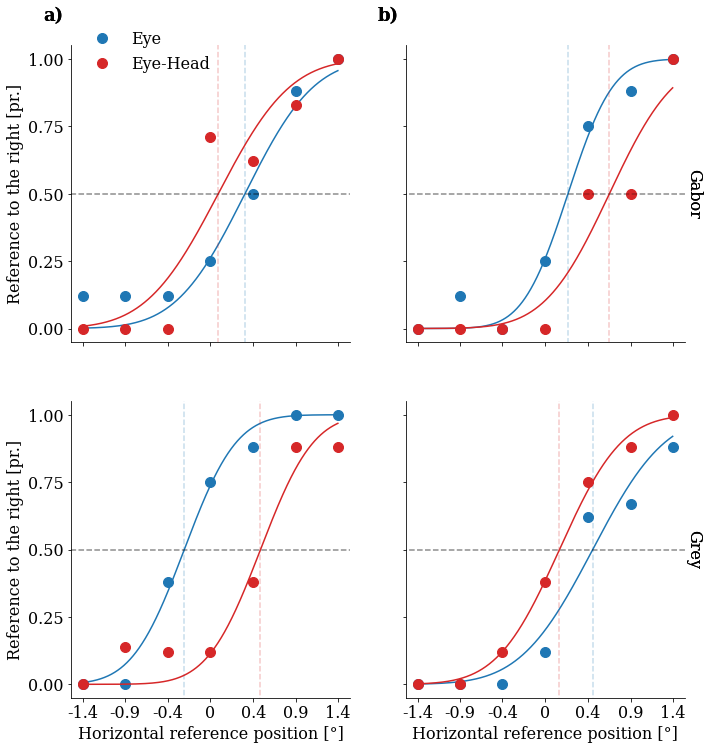

In [29]:
# exp 1 / 2 - example pf funcs
ex_subs = ["SM03", "ST07"] # "AT23", "FH26"

fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=[11, 12])#, constrained_layout=True)
target = "PermanentTargets"
move = "Movement"
markersize = 10

for sub_idx, sub in enumerate(ex_subs):
    for run in ["Eye", "HeadEye"]:
        for gabor_idx, gabor in enumerate(["Gabor", "NoGabor"]):
            if sub_idx == 0:
                ax_col = 0
                ax = axs[gabor_idx, ax_col]
                ax.set_ylabel("Reference to the right [pr.]")
            else:
                ax_col = 1
                ax = axs[gabor_idx, ax_col]
                
                gabor_label = "Gabor"
                if gabor == "NoGabor":
                    gabor_label = "Grey"
                
                ax.text(1, 0.5, gabor_label, horizontalalignment='left', verticalalignment='center', 
                        transform=ax.transAxes, font=font, rotation=270, color="k")
            
            if gabor_idx == 1:
                ax.set_xlabel("Horizontal reference position [°]")
                
            if ax == axs[0,0]:
                ax.text(-0.1, 1.1, "a)", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
            elif ax == axs[0,1]:
                ax.text(-0.1, 1.1, "b)", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
                
            ax.spines[['right', 'top']].set_visible(False)
            ax.set_ylim(-0.05, 1.05)
            ax.set_yticks([0, 0.25, 0.5, 0.75,1])
            ax.set_xlim([-1.5, 1.5])
            x_ticks = [-1.37, -0.92, -0.46, 0, 0.46, 0.92, 1.37]
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(["-1.4", "-0.9", "-0.4", "0", "0.4", "0.9", "1.4"])
            
            cut_pse_df = balanced_pse_df_2.query('SubjectID == @sub & Run == @run & Movement == @move & Target == @target & Gabor == @gabor')
            # print(sub, run, gabor, cut_pse_df.shape[0])
            # print(cut_pse_df.columns)
            
            data_x = cut_pse_df["Lvl_Arr"].iloc[0]
            data_y = cut_pse_df["Resp_Arr"].iloc[0]
            pse, jnd, pf_r2, pse_ir, points, x, y = fit_func(data_x, data_y, [0,0])
            
            cond = "Eye"
            if "Head" in run:
                cond = "Head"
            color = colors[cond][0]
            
            # print(run, gabor, color)
            
            lin_space = np.linspace(data_x[0], data_x[-1], 1000)
            ax.plot(lin_space, norm.cdf(lin_space, pse, jnd), color, ls="-")
            
            if run == "Eye":
                label = "Eye"
            else:
                label = "Eye-Head"
            
            if sub_idx == 0:
                ax.plot(data_x, data_y, "o", ms=markersize, markerfacecolor=color, markeredgecolor=color, label=label)
                
                if gabor_idx == 0:
                    ax.legend(frameon=False, bbox_to_anchor=[0.55,1.1])
            else:
                ax.plot(data_x, data_y, "o", ms=markersize, markerfacecolor=color, markeredgecolor=color)
            
            ax.hlines(y=0.5, xmin=-3, xmax=3, ls="--", color="k", alpha=0.25)
            ax.vlines(x=pse, ymin=-1, ymax=2, ls="--", color=color, alpha=0.25)
            
            print(sub, run, move, gabor, target)
            print(pse, jnd)
            print(data_x)
            print(data_y)
           
plt.savefig(figure_p.joinpath("exp2_example_pfs.png"), dpi=300, facecolor="white", bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp2_example_pfs.pdf"), dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

In [30]:
# exp 1 - mean pse jnd
stat_df = balanced_pse_df_2.query('Run == "Eye"')
vals = stat_df["PSE"]
jnds = stat_df["JND"]
print("Mean PSE: {:1.2f} (SE = {:1.2f})".format(np.mean(vals), np.std(vals) / np.sqrt(len(vals))))
print("Mean JND: {:1.2f} (SE = {:1.2f})".format(np.mean(jnds), np.std(jnds) / np.sqrt(len(jnds))))

Mean PSE: -0.26 (SE = 0.05)
Mean JND: 0.75 (SE = 0.03)


In [31]:
# exp 1 - 0.25 / 0.75 values
data_p_2 = stats_p.joinpath("effmann 2", "data", "Raw")
d_files_2 = np.sort(bf.get_data(data_p_2, "csv","", ["timings", "_eye.", "_head_app.", "_head."])) #
d_files_2 = [x for x in d_files_2 if "_Eye_" in x]

df_025_075_2 = pd.DataFrame()
inc_subs_2 = np.unique(balanced_pse_df_2["SubjectID"])

for sub in inc_subs_2:
    sub_files = [x for x in d_files_2 if sub in x]
    
    for sub_file in sub_files:
        df = df_from_file(sub_file)
        
        ver = sub_file.split("\\")[-1].split(".")[0].split("_")[1:6]
        ver_str = str(ver[0])
        for x in ver[1:]:
           ver_str = ver_str + "_{}".format(x)
           
        col = {"Version": [ver_str] * df.shape[0]}
        df = df.assign(**col)
        
        df_025_075_2 = pd.concat([df_025_075_2, df])
        
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_025_075_pse_2 = single_sub_25_75(df_025_075_2, "Response", "TargetHoriPos")
    
for col in ["PSE_0.25", "PSE_0.75"]:
    vals = df_025_075_pse_2[col]
    print("{}: {:1.2f} ({:1.2f})".format(col, np.mean(vals), np.std(vals) / np.sqrt(len(vals))))

PSE_0.25: -0.83 (0.06)
PSE_0.75: 0.36 (0.08)


In [32]:
# exp 1 - pf analysis
stat_df = balanced_pse_df_2.query('Run == "Eye"')
stat_df = stat_df.groupby(["SubjectID", 'Run', 'Movement', 'Gain', 'Target', 'Gabor']).mean().reset_index()
num_subs = len(list(np.unique(stat_df["SubjectID"])))

for col in ["PSE", "JND"]:
    print(col)
    aov = pg.rm_anova(data=stat_df, dv=col, within=["Target", "Gabor"], subject='SubjectID', detailed=True, effsize="np2")
    
    powers = []
    for idx, row in aov.iterrows():
        pow = pg.power_anova(eta=row["np2"], k=row["ddof1"] + 1, n=num_subs, alpha=0.05)
        powers.append(pow)
    
    aov = aov.assign(Power = powers)
    print(aov.round(3))
    print("\n")

    print_df(get_anova_desc_2(stat_df, ["Target", "Gabor"], [col]))

PSE
           Source     SS  ddof1  ddof2     MS       F  p-unc  p-GG-corr    np2  eps  Power
0          Target  4.328      1     23  4.328  16.893  0.000      0.000  0.423  1.0  1.000
1           Gabor  0.987      1     23  0.987   9.905  0.005      0.005  0.301  1.0  0.994
2  Target * Gabor  0.037      1     23  0.037   0.302  0.588      0.588  0.013  1.0  0.122




JND
           Source     SS  ddof1  ddof2     MS      F  p-unc  p-GG-corr    np2  eps  Power
0          Target  0.859      1     23  0.859  6.930  0.015      0.015  0.232  1.0  0.961
1           Gabor  0.044      1     23  0.044  0.614  0.441      0.441  0.026  1.0  0.198
2  Target * Gabor  0.015      1     23  0.015  0.130  0.722      0.722  0.006  1.0  0.080




In [33]:
#plot pse anova - exp 1 - eye
plot_df = balanced_pse_df_2.query('Run == "Eye"').groupby(["SubjectID", "Target", "Gabor"]).mean().reset_index()

plot_dict = {}
moves = ["Movement"]#, "NoMovement"]
targets = ["PermanentTargets", "TemporaryTargets"]
gabors = ["Gabor", "NoGabor"]

for move in targets:
    plot_dict[move] = {}

for df_info, df in plot_df.groupby(["Target", "Gabor"]):
    target, gabor = list(df_info)
    plot_dict[target][gabor] = {}
    plot_dict[target][gabor]["pses"] = df["PSE"].values
    plot_dict[target][gabor]["jnds"] = df["JND"].values
    plot_dict[target][gabor]["subs"] = df["SubjectID"].values
    
# plotting
fig, axs = plt.subplots(1,2, figsize=[14,6], sharey=False)
letters = ["a)", "b)"]

for av_idx, av in enumerate(["pses", "jnds"]):
    ax = axs[av_idx]
    ax.text(-0.22, 1.05, letters[av_idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
    gains = ["Baseline", "Low", "High"]
    x_ticks = [0.25,1.25,2.25, 3.25]

    ax.set_xticks(x_ticks, fontdict=font)
    # labels = ["{}_{}".format(l1, l2) for l1 in ["PerTar", "TmpTar"] for l2 in ["Gab", "NoG"]]
    labels = ["{}_{}".format(l1, l2) for l1 in targets for l2 in gabors]
    labels = ["SG", "SN", "NG", "NN"]
    ax.set_xticklabels(labels)#, fontsize=7)

    # ax.set_xlabel("Visual velocity gain", fontdict=font)
    # ax.set_xlim([0,2.5])

    if av_idx == 0:
        ax.set_ylim([-0.8, 0.2])
    else:
        ax.set_ylim([0.6, 1])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for move in moves:
        if move == "NoMovement":
            color, alpha = colors["restricted"]
            label = "Restricted"
            coef = 0.025
        else:
            color, alpha = colors["unrestricted"]
            label = "Unrestricted"
            coef = -0.025
            
        for target in targets:
            d = [plot_dict[target][gabor][av] for target in [target] for gabor in gabors]
            
            if target == "PermanentTargets":
                x_ticks = [0.25,1.25]
                cond_x_ticks = [x + coef for x in x_ticks]
                ax.scatter(cond_x_ticks, [np.mean(arr) for arr in d], label=label, color=colors["Eye"][0], alpha=alpha, s=150)
            else:
                x_ticks = [2.25, 3.25]
                cond_x_ticks = [x + coef for x in x_ticks]
                ax.scatter(cond_x_ticks, [np.mean(arr) for arr in d], color=colors["Eye"][0], alpha=alpha, s=150)
            
            ax.plot(x_ticks, [np.mean(arr) for arr in d], color=colors["Eye"][0], alpha=alpha) #label=move, 
            # ax.scatter([[gain]*len(d[idx]) for idx, gain in enumerate(gains)], [arr for arr in d])
            ax.errorbar(cond_x_ticks, [np.mean(arr) for arr in d], yerr=[np.std(arr) / np.sqrt(len(arr)) for arr in d], lw=1, c="k", linestyle="", capsize=10)

    # ax.legend(loc="upper center", frameon=False, fontsize=font_size)
    
    if av == "pses":
        ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
        
        ax.hlines(y=0, xmin=0, xmax=3.5, ls="--", color="k")
        ax.set_xlim([0, 3.5])
    else:
        # ax.set_yticks([0.4, 0.85, 1.3, 1.75, 2.2])
        ax.set_yticks([0.4, 0.7, 1, 1.3, 1.6])
        ax.set_ylim([0.4, 1.6])
    
    if av_idx == 0:
        ax.set_ylabel("PHA [°]", fontdict=font)
    else:
        ax.set_ylabel("JND [°]", fontdict=font)
        
plt.savefig(figure_p.joinpath("exp1_pf.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp1_pf.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.close()

#### exp 2

In [34]:
# exp 2 - saccade amp / head amp across conditions (df for spss anovas since 3 factors)
stat_df = move_data_2.query('Run == "HeadEye"')
new_col = {"SaccAmpTotal": [np.sum(row["SaccadeAmplitudes"]) for idx, row in stat_df.iterrows()]}
stat_df = stat_df.assign(**new_col)
stat_df = stat_df.groupby(["SubjectID", "Move", "Target", "Gabor"]).mean().reset_index()
    
spss_df = df_to_spss_df(stat_df, ['Move', 'Target', 'Gabor'], ["SaccAmpTotal", "HeadMoveAmplitudeY"])
spss_df.to_csv(results_p.joinpath("exp2_head_eye_spss_df.csv"))

desc_res = get_anova_desc_2(stat_df, ["Move", "Target", "Gabor"], ["HeadMoveAmplitudeY", "SaccAmpTotal"])
exp2_amps = desc_res

desc_res

AV                                         Info   Mean    SD    SE
0   HeadMoveAmplitudeY                          HE: Move - Movement  18.50  3.34  0.34
1   HeadMoveAmplitudeY                        HE: Move - NoMovement  18.86  3.18  0.32
2   HeadMoveAmplitudeY                HE: Target - PermanentTargets  19.16  2.65  0.27
3   HeadMoveAmplitudeY                HE: Target - TemporaryTargets  18.20  3.73  0.38
4   HeadMoveAmplitudeY                            HE: Gabor - Gabor  18.92  3.57  0.36
5   HeadMoveAmplitudeY                          HE: Gabor - NoGabor  18.44  2.92  0.30
6   HeadMoveAmplitudeY              IE: Movement - PermanentTargets  19.31  2.60  0.38
7   HeadMoveAmplitudeY              IE: Movement - TemporaryTargets  17.69  3.78  0.55
8   HeadMoveAmplitudeY            IE: NoMovement - PermanentTargets  19.00  2.69  0.39
9   HeadMoveAmplitudeY            IE: NoMovement - TemporaryTargets  18.72  3.61  0.52
10  HeadMoveAmplitudeY                         IE: Movement - Gabor  19.00  3.78  0.55
11  HeadMoveAmplitudeY                       IE: Movement - NoGabor  18.00  2.75  0.40
12  HeadMoveAmplitudeY                       IE: NoMovement - Gabor  18.83  3.34  0.48
13  HeadMoveAmplitudeY                     IE: NoMovement - NoGabor  18.89  3.02  0.44
14  HeadMoveAmplitudeY                 IE: PermanentTargets - Gabor  19.21  2.87  0.41
15  HeadMoveAmplitudeY               IE: PermanentTargets - NoGabor  19.11  2.41  0.35
16  HeadMoveAmplitudeY                 IE: TemporaryTargets - Gabor  18.62  4.13  0.60
17  HeadMoveAmplitudeY               IE: TemporaryTargets - NoGabor  17.78  3.22  0.46
18  HeadMoveAmplitudeY      IE: Movement - PermanentTargets - Gabor  19.68  3.09  0.63
19  HeadMoveAmplitudeY    IE: Movement - PermanentTargets - NoGabor  18.95  1.93  0.39
20  HeadMoveAmplitudeY      IE: Movement - TemporaryTargets - Gabor  18.33  4.26  0.87
21  HeadMoveAmplitudeY    IE: Movement - TemporaryTargets - NoGabor  17.04  3.09  0.63
22  HeadMoveAmplitudeY    IE: NoMovement - PermanentTargets - Gabor  18.74  2.54  0.52
23  HeadMoveAmplitudeY  IE: NoMovement - PermanentTargets - NoGabor  19.26  2.80  0.57
24  HeadMoveAmplitudeY    IE: NoMovement - TemporaryTargets - Gabor  18.91  3.98  0.81
25  HeadMoveAmplitudeY  IE: NoMovement - TemporaryTargets - NoGabor  18.52  3.18  0.65
26        SaccAmpTotal                          HE: Move - Movement  17.66  2.40  0.24
27        SaccAmpTotal                        HE: Move - NoMovement  18.17  2.77  0.28
28        SaccAmpTotal                HE: Target - PermanentTargets  18.58  2.13  0.22
29        SaccAmpTotal                HE: Target - TemporaryTargets  17.25  2.85  0.29
30        SaccAmpTotal                            HE: Gabor - Gabor  17.83  2.24  0.23
31        SaccAmpTotal                          HE: Gabor - NoGabor  18.00  2.91  0.30
32        SaccAmpTotal              IE: Movement - PermanentTargets  18.43  2.10  0.30
33        SaccAmpTotal              IE: Movement - TemporaryTargets  16.88  2.43  0.35
34        SaccAmpTotal            IE: NoMovement - PermanentTargets  18.72  2.14  0.31
35        SaccAmpTotal            IE: NoMovement - TemporaryTargets  17.61  3.17  0.46
36        SaccAmpTotal                         IE: Movement - Gabor  17.75  2.26  0.33
37        SaccAmpTotal                       IE: Movement - NoGabor  17.56  2.53  0.37
38        SaccAmpTotal                       IE: NoMovement - Gabor  17.90  2.22  0.32
39        SaccAmpTotal                     IE: NoMovement - NoGabor  18.44  3.20  0.46
40        SaccAmpTotal                 IE: PermanentTargets - Gabor  18.41  2.12  0.31
41        SaccAmpTotal               IE: PermanentTargets - NoGabor  18.75  2.12  0.31
42        SaccAmpTotal                 IE: TemporaryTargets - Gabor  17.24  2.20  0.32
43        SaccAmpTotal               IE: TemporaryTargets - NoGabor  17.25  3.37  0.49
44        SaccAmpTotal      IE: Movement - PermanentTargets - Gabor  18.43  2.04  0.42
45        SaccAmpT

In [35]:
# solve interactions
## sacc amp - move * gabor
int_df = stat_df.groupby(["SubjectID", "Move", "Gabor"]).mean().reset_index()

arr1 = int_df.query('Move == "NoMovement" & Gabor == "Gabor"')["SaccAmpTotal"]
arr2 = int_df.query('Move == "NoMovement" & Gabor == "NoGabor"')["SaccAmpTotal"]
# dep_ttest(arr1, arr2, "two-sided", 1, True)

## head amp - move * target
int_df = stat_df.groupby(["SubjectID", "Move", "Target"]).mean().reset_index()

arr1 = int_df.query('Move == "NoMovement" & Target == "PermanentTargets"')["SaccAmpTotal"]
arr2 = int_df.query('Move == "NoMovement" & Target == "TemporaryTargets"')["SaccAmpTotal"]
_ = dep_ttest(arr1, arr2, "two-sided", 1, True)

t(23) = 3.12, p = 0.005


In [36]:
# exp 2 - eye fixation during head movement
data = move_data_2.query('Run == "HeadEye"')
col = {"RightCrossFixEyeDuringHeadMovement_Y": [x if type(x) not in [list] else np.nan for x in data["RightCrossFixEyeDuringHeadMovement_Y"]]}
data = data.assign(**col)
move_data_means = data.groupby(["SubjectID", "Run", "Move", "Target", "Gabor"]).mean().reset_index()
col = {"RightCrossFixEyeDuringHeadMovement_Y_per": [row["RightCrossFixEyeDuringHeadMovement_Y"] / row["HeadMoveDurationY"] for _, row in move_data_means.iterrows()]}
move_data_means = move_data_means.assign(**col)

for col in ["EyeArrivedFirstY", "RightCrossFixEyeDuringHeadMovement_Y_per"]: #
    move_data_means[col] = [x * 100 for x in move_data_means[col]]
    
move_data_means = move_data_means.rename(columns={"RightCrossFixEyeDuringHeadMovement_Y_per": "RightCrossFixEyeDuringHeadMovementYPer"})

spss_df = df_to_spss_df(move_data_means, ['Move', 'Target', 'Gabor'], ["EyeArrivedFirstY", "RightCrossFixEyeDuringHeadMovementYPer"])
spss_df.to_csv(results_p.joinpath("exp2_head_eye_fix_spss_df.csv"))

exp2_eye_desc = get_anova_desc_2(move_data_means, ["Move", "Target", "Gabor"], ["EyeArrivedFirstY", "RightCrossFixEyeDuringHeadMovementYPer"])
print("exp2_eye_desc")
exp2_eye_desc

exp2_eye_desc


AV                                         Info   Mean     SD    SE
0                         EyeArrivedFirstY                          HE: Move - Movement  85.62  23.06  2.35
1                         EyeArrivedFirstY                        HE: Move - NoMovement  89.39  19.86  2.03
2                         EyeArrivedFirstY                HE: Target - PermanentTargets  90.08  20.41  2.08
3                         EyeArrivedFirstY                HE: Target - TemporaryTargets  84.93  22.44  2.29
4                         EyeArrivedFirstY                            HE: Gabor - Gabor  88.22  22.25  2.27
5                         EyeArrivedFirstY                          HE: Gabor - NoGabor  86.80  20.92  2.13
6                         EyeArrivedFirstY              IE: Movement - PermanentTargets  89.60  19.76  2.85
7                         EyeArrivedFirstY              IE: Movement - TemporaryTargets  81.64  25.33  3.66
8                         EyeArrivedFirstY            IE: NoMovement - PermanentTargets  90.56  21.03  3.04
9                         EyeArrivedFirstY            IE: NoMovement - TemporaryTargets  88.22  18.55  2.68
10                        EyeArrivedFirstY                         IE: Movement - Gabor  88.37  22.46  3.24
11                        EyeArrivedFirstY                       IE: Movement - NoGabor  82.87  23.33  3.37
12                        EyeArrivedFirstY                       IE: NoMovement - Gabor  88.06  22.04  3.18
13                        EyeArrivedFirstY                     IE: NoMovement - NoGabor  90.73  17.32  2.50
14                        EyeArrivedFirstY                 IE: PermanentTargets - Gabor  90.47  20.61  2.97
15                        EyeArrivedFirstY               IE: PermanentTargets - NoGabor  89.70  20.21  2.92
16                        EyeArrivedFirstY                 IE: TemporaryTargets - Gabor  85.97  23.56  3.40
17                        EyeArrivedFirstY               IE: TemporaryTargets - NoGabor  83.90  21.21  3.06
18                        EyeArrivedFirstY      IE: Movement - PermanentTargets - Gabor  91.46  18.36  3.75
19                        EyeArrivedFirstY    IE: Movement - PermanentTargets - NoGabor  87.74  20.90  4.27
20                        EyeArrivedFirstY      IE: Movement - TemporaryTargets - Gabor  85.29  25.54  5.21
21                        EyeArrivedFirstY    IE: Movement - TemporaryTargets - NoGabor  78.00  24.58  5.02
22                        EyeArrivedFirstY    IE: NoMovement - PermanentTargets - Gabor  89.47  22.59  4.61
23                        EyeArrivedFirstY  IE: NoMovement - PermanentTargets - NoGabor  91.65  19.29  3.94
24                        EyeArrivedFirstY    IE: NoMovement - TemporaryTargets - Gabor  86.65  21.38  4.36
25                        EyeArrivedFirstY  IE: NoMovement - TemporaryTargets - NoGabor  89.80  15.03  3.07
26  RightCrossFixEyeDuringHeadMovementYPer                          HE: Move - Movement  80.28  16.53  1.69
27  RightCrossFixEyeDuringHeadMovementYPer                        HE: Move - NoMovement  89.64  16.45  1.68
28  RightCrossFixEyeDuringHeadMovementYPer                HE: Target - PermanentTargets  89.23  12.84  1.31
29  RightCrossFixEyeDuringHeadMovementYPer                HE: Target - TemporaryTargets  80.68  19.66  2.01
30  RightCrossFixEyeDuringHeadMovementYPer                            HE: Gabor - Gabor  84.51  17.47  1.78
31  RightCrossFixEyeDuringHeadMovementYPer                          HE: Gabor - NoGabor  85.40  16.79  1.71
32  RightCrossFixEyeDuringHeadMovementYPer              IE: Movement - PermanentTargets  84.17  12.62  1.82
33  RightCrossFixEyeDuringHeadMovementYPer              IE: Movement - TemporaryTargets  76.38  18.89  2.73
34  RightCrossFixEyeDuringHeadMovementYPer            IE: NoMovement - PermanentTargets  94.30  10.90  1.57
35  RightCrossFixEyeDuringHeadMovementYPer            IE: NoMovement - TemporaryTargets  84.97  19.47  2.81
36  RightCrossFixEyeDuringHeadMovementYPer  

In [37]:
# exp 2 - mean pse jnd
stat_df = balanced_pse_df_2.query('Run == "HeadEye"')
vals = stat_df["PSE"]
jnds = stat_df["JND"]
print("Mean PSE: {:1.2f} (SE = {:1.2f})".format(np.mean(vals), np.std(vals) / np.sqrt(len(vals))))
print("Mean JND: {:1.2f} (SE = {:1.2f})".format(np.mean(jnds), np.std(jnds) / np.sqrt(len(jnds))))

Mean PSE: 0.12 (SE = 0.04)
Mean JND: 0.86 (SE = 0.03)


In [38]:
# exp 2 - 0.25 / 0.75 values
data_p_2 = stats_p.joinpath("effmann 2", "data", "Raw")
d_files_2 = np.sort(bf.get_data(data_p_2, "csv","", ["timings", "_eye.", "_head_app.", "_head."])) #
d_files_2 = [x for x in d_files_2 if "_HeadEye_" in x]

df_025_075_2 = pd.DataFrame()
inc_subs_2 = np.unique(balanced_pse_df_2["SubjectID"])

for sub in inc_subs_2:
    sub_files = [x for x in d_files_2 if sub in x]
    
    for sub_file in sub_files:
        df = df_from_file(sub_file)
        
        ver = sub_file.split("\\")[-1].split(".")[0].split("_")[1:6]
        ver_str = str(ver[0])
        for x in ver[1:]:
           ver_str = ver_str + "_{}".format(x)
           
        col = {"Version": [ver_str] * df.shape[0]}
        df = df.assign(**col)
        
        df_025_075_2 = pd.concat([df_025_075_2, df])
        
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_025_075_pse_2 = single_sub_25_75(df_025_075_2, "Response", "TargetHoriPos")
    
for col in ["PSE_0.25", "PSE_0.75"]:
    vals = df_025_075_pse_2[col]
    print("{}: {:1.2f} ({:1.2f})".format(col, np.mean(vals), np.std(vals) / np.sqrt(len(vals))))

PSE_0.25: -0.52 (0.08)
PSE_0.75: 0.83 (0.07)


In [39]:
# exp 2 - pse / jnd across conditions (df for spss anovas since 3 factors)
stat_df = balanced_pse_df_2.query('Run == "HeadEye"')
stat_df = stat_df.groupby(["SubjectID", "Movement", "Target", "Gabor"]).mean().reset_index()
    
spss_df = df_to_spss_df(stat_df, ['Movement', 'Target', 'Gabor'], ["PSE", "JND"])
spss_df.to_csv(results_p.joinpath("exp2_pf_spss_df.csv"))

desc_res = get_anova_desc_2(stat_df, ["Movement", "Target", "Gabor"], ["PSE", "JND"])
desc_res

AV                                         Info  Mean    SD    SE
0   PSE                      HE: Movement - Movement  0.10  0.58  0.06
1   PSE                    HE: Movement - NoMovement  0.14  0.52  0.05
2   PSE                HE: Target - PermanentTargets  0.24  0.43  0.04
3   PSE                HE: Target - TemporaryTargets -0.00  0.63  0.06
4   PSE                            HE: Gabor - Gabor  0.21  0.54  0.06
5   PSE                          HE: Gabor - NoGabor  0.03  0.55  0.06
6   PSE              IE: Movement - PermanentTargets  0.22  0.46  0.07
7   PSE              IE: Movement - TemporaryTargets -0.03  0.66  0.09
8   PSE            IE: NoMovement - PermanentTargets  0.26  0.40  0.06
9   PSE            IE: NoMovement - TemporaryTargets  0.02  0.60  0.09
10  PSE                         IE: Movement - Gabor  0.15  0.58  0.08
11  PSE                       IE: Movement - NoGabor  0.05  0.57  0.08
12  PSE                       IE: NoMovement - Gabor  0.27  0.48  0.07
13  PSE                     IE: NoMovement - NoGabor  0.00  0.52  0.08
14  PSE                 IE: PermanentTargets - Gabor  0.35  0.39  0.06
15  PSE               IE: PermanentTargets - NoGabor  0.13  0.45  0.06
16  PSE                 IE: TemporaryTargets - Gabor  0.07  0.63  0.09
17  PSE               IE: TemporaryTargets - NoGabor -0.08  0.62  0.09
18  PSE      IE: Movement - PermanentTargets - Gabor  0.33  0.41  0.08
19  PSE    IE: Movement - PermanentTargets - NoGabor  0.12  0.49  0.10
20  PSE      IE: Movement - TemporaryTargets - Gabor -0.04  0.67  0.14
21  PSE    IE: Movement - TemporaryTargets - NoGabor -0.02  0.64  0.13
22  PSE    IE: NoMovement - PermanentTargets - Gabor  0.36  0.36  0.07
23  PSE  IE: NoMovement - PermanentTargets - NoGabor  0.15  0.40  0.08
24  PSE    IE: NoMovement - TemporaryTargets - Gabor  0.18  0.57  0.12
25  PSE  IE: NoMovement - TemporaryTargets - NoGabor -0.14  0.59  0.12
26  JND                      HE: Movement - Movement  0.84  0.40  0.04
27  JND                    HE: Movement - NoMovement  0.88  0.37  0.04
28  JND                HE: Target - PermanentTargets  0.76  0.32  0.03
29  JND                HE: Target - TemporaryTargets  0.96  0.42  0.04
30  JND                            HE: Gabor - Gabor  0.87  0.39  0.04
31  JND                          HE: Gabor - NoGabor  0.85  0.38  0.04
32  JND              IE: Movement - PermanentTargets  0.73  0.30  0.04
33  JND              IE: Movement - TemporaryTargets  0.95  0.45  0.07
34  JND            IE: NoMovement - PermanentTargets  0.79  0.33  0.05
35  JND            IE: NoMovement - TemporaryTargets  0.96  0.38  0.06
36  JND                         IE: Movement - Gabor  0.88  0.44  0.06
37  JND                       IE: Movement - NoGabor  0.80  0.35  0.05
38  JND                       IE: NoMovement - Gabor  0.86  0.33  0.05
39  JND                     IE: NoMovement - NoGabor  0.89  0.40  0.06
40  JND                 IE: PermanentTargets - Gabor  0.77  0.29  0.04
41  JND               IE: PermanentTargets - NoGabor  0.76  0.34  0.05
42  JND                 IE: TemporaryTargets - Gabor  0.98  0.45  0.06
43  JND               IE: TemporaryTargets - NoGabor  0.93  0.39  0.06
44  JND      IE: Movement - PermanentTargets - Gabor  0.75  0.30  0.06
45  JND    IE: Movement - PermanentTargets - NoGabor  0.72  0.30  0.06
46  JND      IE: Movement - TemporaryTargets - Gabor  1.02  0.51  0.10
47  JND    IE: Movement - TemporaryTargets - NoGabor  0.88  0.37  0.08
48  JND    IE: NoMovement - PermanentTargets - Gabor  0.79  0.27  0.06
49  JND  IE: NoMovement - PermanentTargets - NoGabor  0.80  0.38  0.08
50  JND    IE: NoMovement - TemporaryTargets - Gabor  0.94  0.36  0.07
51  JND  IE: NoMovement - TemporaryTargets - NoGabor  0.98  0.40  0.08

In [40]:
#plot pse anova - exp 2 - headeye
plot_df = balanced_pse_df_2.query('Run == "HeadEye"').groupby(["SubjectID", "Movement", "Target", "Gabor"]).mean().reset_index()

test = plot_df.query('JND <= 5')

subs = np.unique(test["SubjectID"])
new_inc_subs = []

for sub in subs:
    sub_df = test.query('SubjectID == @sub')
    
    if sub_df.shape[0] == 8:
        new_inc_subs.append(sub)
        
test = test.query('SubjectID.isin(@new_inc_subs)')
plot_df = test

plot_dict = {}
moves = ["Movement", "NoMovement"]
targets = ["PermanentTargets", "TemporaryTargets"]
gabors = ["Gabor", "NoGabor"]

for move in moves:
    plot_dict[move] = {}
    for target in targets:
        plot_dict[move][target] = {}

for df_info, df in plot_df.groupby(["Movement", "Target", "Gabor"]):
    movement, target, gabor = list(df_info)
    plot_dict[movement][target][gabor] = {}
    plot_dict[movement][target][gabor]["pses"] = df["PSE"].values
    plot_dict[movement][target][gabor]["jnds"] = df["JND"].values
    plot_dict[movement][target][gabor]["subs"] = df["SubjectID"].values
    
# plotting
fig, axs = plt.subplots(1,2, figsize=[14,6], sharey=False)
letters = ["a)", "b)"]

for av_idx, av in enumerate(["pses", "jnds"]):
    ax = axs[av_idx]
    ax.text(-0.22, 1.05, letters[av_idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
    gains = ["Baseline", "Low", "High"]

    ax.set_xticks(x_ticks, fontdict=font)
    # labels = ["{}_{}".format(l1, l2) for l1 in ["PerTar", "TmpTar"] for l2 in ["Gab", "NoG"]]
    labels = ["{}_{}".format(l1, l2) for l1 in targets for l2 in gabors]
    labels = ["SG", "SN", "NG", "NN"]

    # ax.set_xlabel("Visual velocity gain", fontdict=font)
    # ax.set_xlim([0,2.5])

    if av_idx == 0:
        ax.set_ylim([-0.2, 0.6])
    else:
        ax.set_ylim([0.6, 2.2])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for move in moves:
        for target in targets:
            if target == "PermanentTargets":
                x_ticks = [0.25,1.25]
            else:
                x_ticks = [2.25, 3.25]
            
            d = [plot_dict[move][target][gabor][av] for target in [target] for gabor in gabors]
            
            if move == "NoMovement":
                color, alpha = colors["restricted"]
                label = "Restricted"
                coef = 0.025
            else:
                color, alpha = colors["unrestricted"]
                label = "Unrestricted"
                coef = -0.025
            
            cond_x_ticks = [x + coef for x in x_ticks]
            
            if target == "PermanentTargets":
                ax.scatter(cond_x_ticks, [np.mean(arr) for arr in d], label=label, color=color, alpha=alpha, s=150)
            else:
                ax.scatter(cond_x_ticks, [np.mean(arr) for arr in d], color=color, alpha=alpha, s=150)
                
            ax.plot(x_ticks, [np.mean(arr) for arr in d], color=color, alpha=alpha) #label=move, 
            # ax.scatter([[gain]*len(d[idx]) for idx, gain in enumerate(gains)], [arr for arr in d])
            ax.errorbar(cond_x_ticks, [np.mean(arr) for arr in d], yerr=[np.std(arr) / np.sqrt(len(arr)) for arr in d], lw=1, c="k", linestyle="", capsize=10)

    ax.set_xticks([0.25,1.25,2.25, 3.25])
    ax.set_xticklabels(labels)#, fontsize=7)
    
    if av == "pses":
        ax.legend(loc="upper center", frameon=False, fontsize=font_size)
        ax.set_ylabel("PHA [°]", fontdict=font)
        ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
        ax.hlines(y=0, xmin=0, xmax=3.5, ls="--", color="k")
        ax.set_xlim([0, 3.5])
    else:
        ax.set_ylabel("JND [°]", fontdict=font)
        ax.set_yticks([0.4, 0.7, 1, 1.3, 1.6])
        ax.set_ylim([0.4, 1.6])
        
plt.savefig(figure_p.joinpath("exp2_pf.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp2_pf.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.close()

In [41]:
#plot pse anova - exp 2 - headeye - with move parameters (saccade + head amplitudes)
plot_df = balanced_pse_df_2.query('Run == "HeadEye"').groupby(["SubjectID", "Movement", "Target", "Gabor"]).mean().reset_index()

plot_dict = {}
moves = ["Movement", "NoMovement"]
targets = ["PermanentTargets", "TemporaryTargets"]
gabors = ["Gabor", "NoGabor"]

for move in moves:
    plot_dict[move] = {}
    for target in targets:
        plot_dict[move][target] = {}

for df_info, df in plot_df.groupby(["Movement", "Target", "Gabor"]):
    movement, target, gabor = list(df_info)
    plot_dict[movement][target][gabor] = {}
    plot_dict[movement][target][gabor]["pses"] = df["PSE"].values
    plot_dict[movement][target][gabor]["jnds"] = df["JND"].values
    plot_dict[movement][target][gabor]["subs"] = df["SubjectID"].values
    
# plotting
fig, axs = plt.subplots(2,2, figsize=[16, 8])
letters = ["a)", "b)", "c)", "d)"]
labels = ["SG", "SN", "NG", "NN"]
counter = -1

for idx in [0,1]:
    for ax in axs[idx]:
        counter = counter + 1
        ax.spines[['right', 'top']].set_visible(False)
        ax.text(-0.15, 1.05, letters[counter], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
        ax.set_xlim([0, 3.5])
        ax.set_xticks([0.25,1.25,2.25, 3.25])
        ax.set_xticklabels(labels)

for av_idx, av in enumerate(["pses", "jnds"]):
    if av_idx == 0:
        ax = axs[0,0]
        ax.set_ylim([-0.2, 0.6])
        ax.set_ylabel("PHA [°]", fontdict=font)
        ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
        ax.hlines(y=0, xmin=0, xmax=3.5, ls="--", color="k")
    else:
        ax = axs[0,1]
        ax.set_ylabel("JND [°]", fontdict=font)
        ax.set_yticks([0.4, 0.7, 1, 1.3, 1.6])
        ax.set_ylim([0.4, 1.6])
        
    for move in moves:
        for target in targets:
            if target == "PermanentTargets":
                x_ticks = [0.25,1.25]
            else:
                x_ticks = [2.25, 3.25]
            
            d = [plot_dict[move][target][gabor][av] for target in [target] for gabor in gabors]
            
            if move == "NoMovement":
                color, alpha = colors["restricted"]
                label = "Restricted"
                coef = 0.025
            else:
                color, alpha = colors["unrestricted"]
                label = "Unrestricted"
                coef = -0.025
            
            cond_x_ticks = [x + coef for x in x_ticks]
            
            if target == "PermanentTargets":
                ax.scatter(cond_x_ticks, [np.mean(arr) for arr in d], label=label, color=color, alpha=alpha, s=150)
            else:
                ax.scatter(cond_x_ticks, [np.mean(arr) for arr in d], color=color, alpha=alpha, s=150)
                
            ax.plot(x_ticks, [np.mean(arr) for arr in d], color=color, alpha=alpha) #label=move, 
            ax.errorbar(cond_x_ticks, [np.mean(arr) for arr in d], yerr=[np.std(arr) / np.sqrt(len(arr)) for arr in d], lw=1, c="k", linestyle="", capsize=10)
            
    axs[0,0].legend(loc="upper center", frameon=False, fontsize=font_size)

# plot move parameters
ax = axs[1,0]
ax.set_ylabel("Amplitude [°]", fontdict=font)
ax.set_yticks([15, 16.4, 17.8, 19.2, 20.6, 22])
ax.set_ylim([15, 22])
coef = 0

for av, color in [["SaccAmpTotal", "tab:blue"], ["HeadMoveAmplitudeY", "tab:red"]]:
    exp2_amps_cut = exp2_amps.query('AV == @av & (Info.str.contains("IE: PermanentTargets - ") | Info.str.contains("IE: TemporaryTargets - "))').tail(4)
    
    if "Head" in av:
        label ="Head"
    else:
        label ="Eye"
    
    for part in ["head", "tail"]:
        if part == "head":
            exp2_amps_cut_cut = exp2_amps_cut.head(2)
            x_ticks = [0.25,1.25]
        else:
            exp2_amps_cut_cut = exp2_amps_cut.tail(2)
            x_ticks = [2.25, 3.25]
        
        means = exp2_amps_cut_cut["Mean"]
        ses = exp2_amps_cut_cut["SE"]
        
        cond_x_ticks = [x + coef for x in x_ticks]
        if part == "head":
            ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label=label)
        else:
            ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150,)
            
        ax.plot(x_ticks, means, color=color, alpha=alpha) #label=move, 
        ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)
        
ax.legend(loc="lower left", frameon=False)
ax.hlines(y=20, xmin=0, xmax=3.4, ls="--", color="k")
ax.set_xlim([0, 3.5])
        
# fixation
ax = axs[1,1]
ax.set_ylabel("Fixation duration [%]", fontdict=font)
ax.set_yticks([75, 80, 85,90,95])
ax.set_ylim([75, 95])
coef = 0
color = "tab:cyan" #colors["Eye"][0]

exp2_eye_desc_cut = exp2_eye_desc.query('AV == "RightCrossFixEyeDuringHeadMovementYPer" & (Info.str.contains("IE: PermanentTargets - ") | Info.str.contains("IE: TemporaryTargets - "))').tail(4)
    
# print_df(exp2_eye_desc_cut)
    
for part in ["head", "tail"]:
    if part == "head":
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.head(2)
        x_ticks = [0.25,1.25]
    else:
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.tail(2)
        x_ticks = [2.25, 3.25]
    
    means = exp2_eye_desc_cut_cut["Mean"]
    ses = exp2_eye_desc_cut_cut["SE"]
    
    cond_x_ticks = [x + coef for x in x_ticks]
    if part == "head":
        ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label=label)
    else:
        ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150,)
        
    ax.plot(x_ticks, means, color=color, alpha=alpha) #label=move, 
    ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)

plt.savefig(figure_p.joinpath("exp2_pf_enhanced_sacc.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp2_pf_enhanced_sacc.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.close()

In [42]:
#plot pse anova - exp 2 - headeye - with move parameters (head amplitudes left)
plot_df = balanced_pse_df_2.query('Run == "HeadEye"').groupby(["SubjectID", "Movement", "Target", "Gabor"]).mean().reset_index()

plot_dict = {}
moves = ["Movement", "NoMovement"]
targets = ["PermanentTargets", "TemporaryTargets"]
gabors = ["Gabor", "NoGabor"]

for move in moves:
    plot_dict[move] = {}
    for target in targets:
        plot_dict[move][target] = {}

for df_info, df in plot_df.groupby(["Movement", "Target", "Gabor"]):
    movement, target, gabor = list(df_info)
    plot_dict[movement][target][gabor] = {}
    plot_dict[movement][target][gabor]["pses"] = df["PSE"].values
    plot_dict[movement][target][gabor]["jnds"] = df["JND"].values
    plot_dict[movement][target][gabor]["subs"] = df["SubjectID"].values
    
# plotting
fig, axs = plt.subplots(2,2, figsize=[16, 8])
letters = ["a)", "b)", "c)", "d)"]
labels = ["SG", "SN", "NG", "NN"]
counter = -1

for idx in [0,1]:
    for ax in axs[idx]:
        counter = counter + 1
        ax.spines[['right', 'top']].set_visible(False)
        ax.text(-0.15, 1.05, letters[counter], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
        ax.set_xlim([0, 3.5])
        ax.set_xticks([0.25,1.25,2.25, 3.25])
        ax.set_xticklabels(labels)

for av_idx, av in enumerate(["pses", "jnds"]):
    if av_idx == 0:
        ax = axs[0,0]
        ax.set_ylim([-0.2, 0.6])
        ax.set_ylabel("PHA [°]", fontdict=font)
        ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
        ax.hlines(y=0, xmin=0, xmax=3.5, ls="--", color="k")
    else:
        ax = axs[0,1]
        ax.set_ylabel("JND [°]", fontdict=font)
        ax.set_yticks([0.4, 0.7, 1, 1.3, 1.6])
        ax.set_ylim([0.4, 1.6])
        
    for move in moves:
        for target in targets:
            if target == "PermanentTargets":
                x_ticks = [0.25,1.25]
            else:
                x_ticks = [2.25, 3.25]
            
            d = [plot_dict[move][target][gabor][av] for target in [target] for gabor in gabors]
            
            if move == "NoMovement":
                color, alpha = colors["restricted"]
                label = "Restricted"
                coef = 0.025
            else:
                color, alpha = colors["unrestricted"]
                label = "Unrestricted"
                coef = -0.025
            
            cond_x_ticks = [x + coef for x in x_ticks]
            
            if target == "PermanentTargets":
                ax.scatter(cond_x_ticks, [np.mean(arr) for arr in d], label=label, color=color, alpha=alpha, s=150)
            else:
                ax.scatter(cond_x_ticks, [np.mean(arr) for arr in d], color=color, alpha=alpha, s=150)
                
            ax.plot(x_ticks, [np.mean(arr) for arr in d], color=color, alpha=alpha) #label=move, 
            ax.errorbar(cond_x_ticks, [np.mean(arr) for arr in d], yerr=[np.std(arr) / np.sqrt(len(arr)) for arr in d], lw=1, c="k", linestyle="", capsize=10)
            
    axs[0,0].legend(loc="upper center", frameon=False, fontsize=font_size)

# plot move parameters
ax = axs[1,0]
ax.set_ylabel("Amplitude [°]", fontdict=font)
ax.set_yticks([15, 16.4, 17.8, 19.2, 20.6, 22])
ax.set_ylim([15, 22])
coef = 0

for av, color in [["HeadMoveAmplitudeY", "tab:red"]]:
    for move in ["Movement", "NoMovement"]:
        exp2_amps_cut = exp2_amps.query('AV == @av & Info.str.contains("IE: ") & Info.str.contains(" {}".format(@move))').tail(4)
        
        # print_df(exp2_amps_cut)
        
        label = "Unrestricted"
        color, alpha = colors["unrestricted"]
        
        if move == "NoMovement":
            label ="Restricted"
            color, alpha = colors["restricted"]
        
        for part in ["head", "tail"]:
            if part == "head":
                exp2_amps_cut_cut = exp2_amps_cut.head(2)
                x_ticks = [0.25,1.25]
            else:
                exp2_amps_cut_cut = exp2_amps_cut.tail(2)
                x_ticks = [2.25, 3.25]
            
            means = exp2_amps_cut_cut["Mean"]
            ses = exp2_amps_cut_cut["SE"]
            
            cond_x_ticks = [x + coef for x in x_ticks]
            if part == "head":
                ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label=label)
            else:
                ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150,)
                
            ax.plot(x_ticks, means, color=color, alpha=alpha) #label=move, 
            ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)
        
ax.hlines(y=20, xmin=0, xmax=3.4, ls="--", color="k")
ax.set_xlim([0, 3.5])
        
# fixation
ax = axs[1,1]
ax.set_ylabel("Fixation duration [%]", fontdict=font)
ax.set_yticks([75, 80, 85,90,95])
ax.set_ylim([75, 95])
coef = 0
color = "tab:cyan" #colors["Eye"][0]

exp2_eye_desc_cut = exp2_eye_desc.query('AV == "RightCrossFixEyeDuringHeadMovementYPer" & (Info.str.contains("IE: PermanentTargets - ") | Info.str.contains("IE: TemporaryTargets - "))').tail(4)
    
# print_df(exp2_eye_desc_cut)
    
for part in ["head", "tail"]:
    if part == "head":
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.head(2)
        x_ticks = [0.25,1.25]
    else:
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.tail(2)
        x_ticks = [2.25, 3.25]
    
    means = exp2_eye_desc_cut_cut["Mean"]
    ses = exp2_eye_desc_cut_cut["SE"]
    
    cond_x_ticks = [x + coef for x in x_ticks]
    if part == "head":
        ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label=label)
    else:
        ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150,)
        
    ax.plot(x_ticks, means, color=color, alpha=alpha) #label=move, 
    ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)

plt.savefig(figure_p.joinpath("exp2_pf_enhanced.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp2_pf_enhanced.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.close()

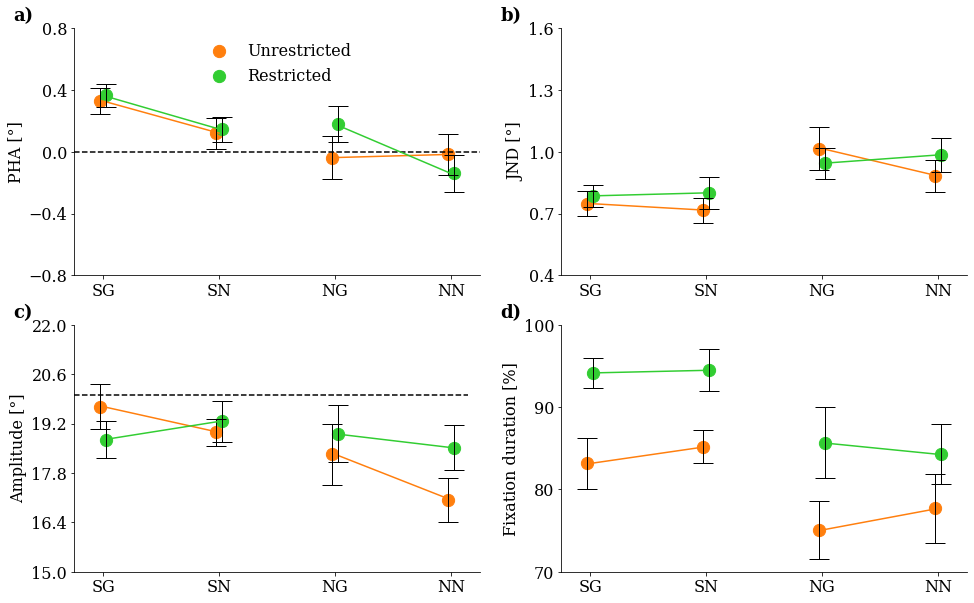

In [43]:
#plot pse anova - exp 2 - headeye - with move parameters (head amplitudes left)
plot_df = balanced_pse_df_2.query('Run == "HeadEye"').groupby(["SubjectID", "Movement", "Target", "Gabor"]).mean().reset_index()

plot_dict = {}
moves = ["Movement", "NoMovement"]
targets = ["PermanentTargets", "TemporaryTargets"]
gabors = ["Gabor", "NoGabor"]

for move in moves:
    plot_dict[move] = {}
    for target in targets:
        plot_dict[move][target] = {}

for df_info, df in plot_df.groupby(["Movement", "Target", "Gabor"]):
    movement, target, gabor = list(df_info)
    plot_dict[movement][target][gabor] = {}
    plot_dict[movement][target][gabor]["pses"] = df["PSE"].values
    plot_dict[movement][target][gabor]["jnds"] = df["JND"].values
    plot_dict[movement][target][gabor]["subs"] = df["SubjectID"].values
    
# plotting
fig, axs = plt.subplots(2,2, figsize=[16, 10])
letters = ["a)", "b)", "c)", "d)"]
labels = ["SG", "SN", "NG", "NN"]
counter = -1

for idx in [0,1]:
    for ax in axs[idx]:
        counter = counter + 1
        ax.spines[['right', 'top']].set_visible(False)
        ax.text(-0.15, 1.05, letters[counter], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
        ax.set_xlim([0, 3.5])
        ax.set_xticks([0.25,1.25,2.25, 3.25])
        ax.set_xticklabels(labels)

for av_idx, av in enumerate(["pses", "jnds"]):
    if av_idx == 0:
        ax = axs[0,0]
        ax.set_ylim([-0.2, 0.6])
        ax.set_ylabel("PHA [°]", fontdict=font)
        ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
        ax.hlines(y=0, xmin=0, xmax=3.5, ls="--", color="k")
    else:
        ax = axs[0,1]
        ax.set_ylabel("JND [°]", fontdict=font)
        ax.set_yticks([0.4, 0.7, 1, 1.3, 1.6])
        ax.set_ylim([0.4, 1.6])
        
    for move in moves:
        for target in targets:
            if target == "PermanentTargets":
                x_ticks = [0.25,1.25]
            else:
                x_ticks = [2.25, 3.25]
            
            d = [plot_dict[move][target][gabor][av] for target in [target] for gabor in gabors]
            
            if move == "NoMovement":
                color, alpha = colors["restricted"]
                label = "Restricted"
                coef = 0.025
            else:
                color, alpha = colors["unrestricted"]
                label = "Unrestricted"
                coef = -0.025
            
            cond_x_ticks = [x + coef for x in x_ticks]
            
            if target == "PermanentTargets":
                ax.scatter(cond_x_ticks, [np.mean(arr) for arr in d], label=label, color=color, alpha=alpha, s=150)
            else:
                ax.scatter(cond_x_ticks, [np.mean(arr) for arr in d], color=color, alpha=alpha, s=150)
                
            ax.plot(x_ticks, [np.mean(arr) for arr in d], color=color, alpha=alpha) #label=move, 
            ax.errorbar(cond_x_ticks, [np.mean(arr) for arr in d], yerr=[np.std(arr) / np.sqrt(len(arr)) for arr in d], lw=1, c="k", linestyle="", capsize=10)
            
    axs[0,0].legend(loc="upper center", frameon=False, fontsize=font_size)

# plot move parameters
ax = axs[1,0]
ax.set_ylabel("Amplitude [°]", fontdict=font)
ax.set_yticks([15, 16.4, 17.8, 19.2, 20.6, 22])
ax.set_ylim([15, 22])

for av, color in [["HeadMoveAmplitudeY", "tab:red"]]:
    for move in ["Movement", "NoMovement"]:
        exp2_amps_cut = exp2_amps.query('AV == @av & Info.str.contains("IE: ") & Info.str.contains(" {}".format(@move))').tail(4)
        
        # print_df(exp2_amps_cut)
        
        label = "Unrestricted"
        color, alpha = colors["unrestricted"]
        coef = -0.025
        
        if move == "NoMovement":
            label ="Restricted"
            color, alpha = colors["restricted"]
            coef = 0.025
        
        for part in ["head", "tail"]:
            if part == "head":
                exp2_amps_cut_cut = exp2_amps_cut.head(2)
                x_ticks = [0.25,1.25]
            else:
                exp2_amps_cut_cut = exp2_amps_cut.tail(2)
                x_ticks = [2.25, 3.25]
            
            means = exp2_amps_cut_cut["Mean"]
            ses = exp2_amps_cut_cut["SE"]
            
            cond_x_ticks = [x + coef for x in x_ticks]
            if part == "head":
                ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label=label)
            else:
                ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150,)
                
            ax.plot(x_ticks, means, color=color, alpha=alpha) #label=move, 
            ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)
        
ax.hlines(y=20, xmin=0, xmax=3.4, ls="--", color="k")
ax.set_xlim([0, 3.5])
        
# fixation
ax = axs[1,1]
ax.set_ylabel("Fixation duration [%]", fontdict=font)
ax.set_yticks([70, 80, 90, 100])
ax.set_ylim([70, 100])

exp2_eye_desc_cut = exp2_eye_desc.query('AV == "RightCrossFixEyeDuringHeadMovementYPer"').tail(8)
    
# print_df(exp2_eye_desc_cut)
    
for cond in ["Movement", "NoMovement"]:
    exp2_eye_desc_cut_cond = exp2_eye_desc_cut.query('Info.str.contains(" {}".format(@cond))')
    
    if cond == "Movement":
        color = colors["unrestricted"][0]
        coef = -0.025
    else:
        color = colors["restricted"][0]
        coef = 0.025
    
    # print_df(exp2_eye_desc_cut_cond)
    
    for part in ["head", "tail"]:
        if part == "head":
            exp2_eye_desc_cut_cut = exp2_eye_desc_cut_cond.head(2)
            x_ticks = [0.25,1.25]
        else:
            exp2_eye_desc_cut_cut = exp2_eye_desc_cut_cond.tail(2)
            x_ticks = [2.25, 3.25]
        
        means = exp2_eye_desc_cut_cut["Mean"]
        ses = exp2_eye_desc_cut_cut["SE"]
        
        cond_x_ticks = [x + coef for x in x_ticks]
        if part == "head":
            ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label=label)
        else:
            ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150,)
            
        ax.plot(x_ticks, means, color=color, alpha=alpha) #label=move, 
        ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)

plt.savefig(figure_p.joinpath("exp2_pf_enhanced_split.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp2_pf_enhanced_split.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.show()

In [44]:
# exp 2 vs exp 1 - pf analyses
stat_df = balanced_pse_df_2.groupby(["SubjectID", "Run"]).mean().reset_index() #, "Movement", "Target", "Gabor"

for col in ["PSE", "JND"]:
    print(col)
    aov = pg.rm_anova(data=stat_df, dv=col, within=["Run"], subject='SubjectID', detailed=True, effsize="np2")
    
    powers = []
    for idx, row in aov.iterrows():
        pow = pg.power_anova(eta=row["np2"], k=row["DF"] + 1, n=num_subs, alpha=0.05)
        powers.append(pow)
    
    aov = aov.assign(Power = powers)
    print(aov.round(3))
    print("\n")
    
    print_df(get_anova_desc_2(stat_df, ["Run"], [col]))
    print("\n")

PSE
  Source     SS  DF     MS       F  p-unc    np2  eps  Power
0    Run  1.678   1  1.678  47.483    0.0  0.674  1.0    1.0
1  Error  0.813  23  0.035     NaN    NaN    NaN  NaN    NaN






JND
  Source     SS  DF     MS      F  p-unc    np2  eps  Power
0    Run  0.132   1  0.132  5.769  0.025  0.201  1.0  0.925
1  Error  0.528  23  0.023    NaN    NaN    NaN  NaN    NaN




In [45]:
# exp 1 vs 2
plot_df = balanced_pse_df_2.groupby(["SubjectID", "Run", "Movement", "Target", "Gabor"]).mean().reset_index()
plot_df = plot_df.replace({"Movement": "M", "NoMovement": "NM", "PermanentTargets": "P", "TemporaryTargets": "T", "Gabor": "G", "NoGabor": "NG"})

# plotting
fig, axs = plt.subplots(1,2, figsize=[12, 6])#, sharey=True)
letters = ["a)", "b)"]

for av_idx, av in enumerate(["PSE", "JND"]):
    ax = axs[av_idx]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-0.22, 1.05, letters[av_idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
    
    if av == "PSE":
        ax.set_ylabel("PHA (°)")
    else:
        ax.set_ylabel("JND (°)")

    for av_idx, plot in enumerate(["HeadEye", "Eye"]): # 
        cut_df = plot_df.query('Run == @plot').groupby(["Movement", "Target", "Gabor"]).mean().reset_index()

        if plot == "HeadEye":
            x_ticks = np.linspace(0, 10, int(cut_df.shape[0] / 2))
            ax.set_xticks(x_ticks, fontdict=font)
            labels = np.unique(["{}_{}".format(row["Target"], row["Gabor"]) for idx, row in cut_df.iterrows()])
            # labels = ["PG", "PN", "TG", "TN"]
            labels = ["SG", "SN", "NG", "NN"]
            ax.set_xticklabels(labels)#, fontsize=11)
        else:
            x_ticks = np.linspace(0, 10, int(cut_df.shape[0]))
            
        # ax.hlines(xmin=x_ticks[0] - 1, xmax=x_ticks[-1] + 1, y=0, linestyles="dashed", colors="k")
        # ax.set_xlim([x_ticks[0] - 1, x_ticks[-1] + 1])

        if av_idx == 0:
            for move in ["M"]:#, "NM"]:
                for target in ["P", "T"]:
                    if target == "P":
                        new_x_ticks = x_ticks[:2]
                    else:
                        new_x_ticks = x_ticks[2:]
                    
                    move_l = "U"
                    if move == "NM":
                        move_l = "R"
                    
                    move_df = plot_df.query('Run == @plot & Movement == @move & Target == @target')
                    
                    means = []
                    ses = []
                    for info, df in move_df.groupby(["Gabor"]):
                        means.append(np.mean(df[av]))
                        ses.append(np.std(df[av]) / np.sqrt(df.shape[0]))
                    
                    # print("Head", len(list(df[av])))
                
                    if move == "M":
                        coef = 0
                    else:
                        coef = 0.5
                        
                    new_ticks = [x + coef for x in new_x_ticks]
                    # ax.plot(x_ticks, means, label=move, ls="")
                    key = "Eye"
                    if plot == "HeadEye":
                        key = "Head"
                    
                    if target == "P":
                        ax.scatter(new_ticks, means,s=200, label="Eye-Head".format(move_l), color=colors[key][0])
                    else:
                        ax.scatter(new_ticks, means,s=200, color=colors[key][0])
                        
                    ax.plot(new_ticks, means, color=colors[key][0])
                    ax.errorbar(new_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)
                
            # ax.legend(loc="lower left", frameon=False)
        else:
            move_df = plot_df.query('Run == "Eye"')
            
            # print(move_df.columns)
            # print(np.unique(move_df["Target"]))
            # print(np.unique(move_df["Gabor"]))
            
            for target in ["P", "T"]:
                means = []
                ses = []
                
                for gabor in ["G", "NG"]:
                    # for info, df in move_df.groupby(["Target", "Gabor"]):
                    cut_move_df = move_df.query('Target == @target & Gabor == @gabor')
                    # print(target, gabor, cut_move_df.shape[0])
                    means.append(np.mean(cut_move_df[av]))
                    ses.append(np.std(cut_move_df[av]) / np.sqrt(cut_move_df.shape[0]))

                if target == "P":
                    new_x_ticks = x_ticks[:2]
                else:
                    new_x_ticks = x_ticks[2:]

                coef = -0.5
                new_ticks = [x + coef for x in new_x_ticks]
                # ax.plot(x_ticks, means, ls="")
                ax.plot(new_ticks, means, color=colors["Eye"][0])
                ax.errorbar(new_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)
                
                if target == "P":
                    ax.scatter(new_ticks, means, s=200, label="Eye", color=colors["Eye"][0])
                else:
                    ax.scatter(new_ticks, means, s=200, color=colors["Eye"][0])
    
    if av == "PSE":
        ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
        ax.legend(loc="upper center", frameon=False)
        ax.hlines(y=0, xmin=-1, xmax=11, ls="--", color="k")
        ax.set_xlim([-1,11])
        
        ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
        ax.set_ylim([-0.8, 0.8])
    else:
        ax.set_yticks([0.4, 0.7, 1, 1.3, 1.6])
        ax.set_ylim([0.4, 1.6])
        
plt.savefig(figure_p.joinpath("exp1_exp2_pf.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp1_exp2_pf.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.close()

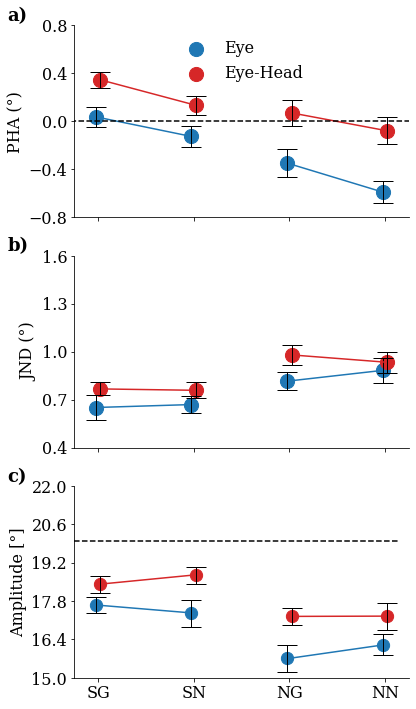

In [46]:
# exp 1 vs 2 - movement parameters
plot_df = balanced_pse_df_2.groupby(["SubjectID", "Run", "Movement", "Target", "Gabor"]).mean().reset_index()
plot_df = plot_df.replace({"Movement": "M", "NoMovement": "NM", "PermanentTargets": "P", "TemporaryTargets": "T", "Gabor": "G", "NoGabor": "NG"})

# plotting
fig, axs = plt.subplots(3,1, figsize=[6, 12])#, sharey=True)
letters = ["a)", "b)", "c)", "d)"]
labels = ["SG", "SN", "NG", "NN"]
counter = -1
xticks = [0.25,1.25,2.25, 3.25]

# for idx in [0,1]:
for ax in axs:#[idx]:
    counter = counter + 1
    ax.spines[['right', 'top']].set_visible(False)
    ax.text(-0.2, 1.05, letters[counter], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
    ax.set_xlim([0, 3.5])
    ax.set_xticks(xticks)
    
    if ax == axs[-1]:
        ax.set_xticklabels(labels)
    else:
        ax.set_xticklabels([])
        
for run, key in [["Eye", "Eye"], ["HeadEye", "Head"]]:
    coef = -0.025
    
    if run == "HeadEye":
        coef = 0.025
    
    for av, ax in [["PSE", axs[0]], ["JND", axs[1]]]:
        if av == "PSE":
            ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
            ax.set_ylim([-0.8, 0.8])
            ax.set_ylabel("PHA (°)")
        else:
            ax.set_yticks([0.4, 0.7, 1, 1.3, 1.6])
            ax.set_ylim([0.4, 1.6])
            ax.set_ylabel("JND (°)")
        
        for target in ["P", "T"]:
            cut_df = plot_df.query('Run == @run & Target == @target')
            
            if run == "HeadEye":
                cut_df = cut_df.groupby(["SubjectID", "Gabor"]).mean().reset_index()
        
            gabor = cut_df.query('Gabor == "G"')
            no_gabor = cut_df.query('Gabor == "NG"')
            
            means = [np.mean(gabor[av]), np.mean(no_gabor[av])]
            ses = [np.std(gabor[av]) / np.sqrt(gabor[av].shape[0]), np.std(no_gabor[av]) / np.sqrt(no_gabor[av].shape[0])]
            
            if target == "P":
                new_ticks = xticks[:2]
            else:
                new_ticks = xticks[2:]
                
            new_ticks = [x + coef for x in new_ticks]
            
            if target == "P":
                label = key
                if key == "Head":
                    label = "Eye-Head"
                
                ax.scatter(new_ticks, means,s=200, label=label, color=colors[key][0])
            else:
                ax.scatter(new_ticks, means,s=200, color=colors[key][0])
                
            ax.plot(new_ticks, means, color=colors[key][0])
            ax.errorbar(new_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)
            
axs[0].legend(loc="upper center", frameon=False)
axs[0].hlines(y=0, xmin=-1, xmax=11, ls="--", color="k")

# plot eye amps
exp1_amps = exp1_amps.assign(**{"Exp": ["Exp1"] * exp1_amps.shape[0]})
exp2_amps = exp2_amps.assign(**{"Exp": ["Exp2"] * exp2_amps.shape[0]})
exp12_amps = pd.concat([exp1_amps, exp2_amps])

ax = axs[2]#,0]
ax.set_ylabel("Amplitude [°]", fontdict=font)
ax.set_yticks([15, 16.4, 17.8, 19.2, 20.6, 22])
ax.set_ylim([15, 22])

for exp in ["Exp1", "Exp2"]:
    av = "SaccAmpTotal"
    exp2_amps_cut = exp12_amps.query('Exp == @exp & AV == @av & (Info.str.contains("IE: PermanentTargets - ") | Info.str.contains("IE: TemporaryTargets - "))').tail(4)
    
    if exp == "Exp1":
        label = "Eye"
        color = "tab:blue"
        coef = -0.025
    else:
        label = "Eye Head"
        color = "tab:red"
        coef = 0.025
    
    for part in ["head", "tail"]:
        if part == "head":
            exp2_amps_cut_cut = exp2_amps_cut.head(2)
            x_ticks = [0.25,1.25]
        else:
            exp2_amps_cut_cut = exp2_amps_cut.tail(2)
            x_ticks = [2.25, 3.25]
        
        means = exp2_amps_cut_cut["Mean"]
        ses = exp2_amps_cut_cut["SE"]
        
        cond_x_ticks = [x + coef for x in x_ticks]
        if part == "head":
            ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label=label)
        else:
            ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150,)
            
        ax.plot(x_ticks, means, color=color, alpha=alpha) #label=move, 
        ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)
        
axs[2].hlines(y=20, xmin=0, xmax=3.4, ls="--", color="k")
axs[2].set_xlim([0, 3.5])

plt.savefig(figure_p.joinpath("exp1_exp2_pf_enhanced.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp1_exp2_pf_enhanced.pdf"), facecolor="white", dpi=300, bbox_inches="tight")

In [81]:
# saccade amplitudes exp 1 vs exp 2 (no move split)

stat_df = move_data_2#.query('Run == "Eye"')
new_col = {"SaccAmpTotal": [np.sum(row["SaccadeAmplitudes"]) for idx, row in stat_df.iterrows()]}
stat_df = stat_df.assign(**new_col)

stat_df = stat_df.groupby(["SubjectID", "Run", "Target", "Gabor"]).mean().reset_index()

stat_df = stat_df[["SubjectID","Run","Target","Gabor", "SaccAmpTotal"]]

spss_df = df_to_spss_df(stat_df, ["Run","Target","Gabor"], ["SaccAmpTotal"])
spss_df.to_csv(r"C:\Users\serda\Desktop\CodeProjects\UE\ada_head_rot_eyetracking\Z_Stats\manuscript_2\dfs\sacc_amp_exp1_vs_2.csv")

get_anova_desc_2(stat_df, ["Run", "Target"], ["SaccAmpTotal"])

AV                            Info   Mean    SD    SE
0  SaccAmpTotal                   HE: Run - Eye  16.73  2.23  0.23
1  SaccAmpTotal               HE: Run - HeadEye  17.92  2.24  0.23
2  SaccAmpTotal   HE: Target - PermanentTargets  18.06  1.99  0.20
3  SaccAmpTotal   HE: Target - TemporaryTargets  16.60  2.38  0.24
4  SaccAmpTotal      IE: Eye - PermanentTargets  17.51  1.99  0.29
5  SaccAmpTotal      IE: Eye - TemporaryTargets  15.96  2.18  0.31
6  SaccAmpTotal  IE: HeadEye - PermanentTargets  18.61  1.84  0.26
7  SaccAmpTotal  IE: HeadEye - TemporaryTargets  17.23  2.40  0.35

In [88]:
# phas exp 1 vs exp 2 (no move split)
stat_df = balanced_pse_df_2.query('Movement == "Movement"')
stat_df = stat_df.groupby(["SubjectID", "Run", "Target", "Gabor"]).mean().reset_index()

spss_df = df_to_spss_df(stat_df, ["Run", "Target", "Gabor"], ["PSE", "JND"])
spss_df.to_csv(r"C:\Users\serda\Desktop\CodeProjects\UE\ada_head_rot_eyetracking\Z_Stats\manuscript_2\dfs\pse_exp1_vs_2.csv")

get_anova_desc_2(stat_df, ["Run", "Target", "Gabor"], ["PSE", "JND"])

AV                                      Info  Mean    SD    SE
0   PSE                             HE: Run - Eye -0.26  0.53  0.05
1   PSE                         HE: Run - HeadEye  0.10  0.58  0.06
2   PSE             HE: Target - PermanentTargets  0.09  0.47  0.05
3   PSE             HE: Target - TemporaryTargets -0.25  0.64  0.06
4   PSE                         HE: Gabor - Gabor -0.00  0.58  0.06
5   PSE                       HE: Gabor - NoGabor -0.15  0.58  0.06
6   PSE                IE: Eye - PermanentTargets -0.04  0.43  0.06
7   PSE                IE: Eye - TemporaryTargets -0.47  0.53  0.08
8   PSE            IE: HeadEye - PermanentTargets  0.22  0.46  0.07
9   PSE            IE: HeadEye - TemporaryTargets -0.03  0.66  0.09
10  PSE                           IE: Eye - Gabor -0.15  0.53  0.08
11  PSE                         IE: Eye - NoGabor -0.36  0.50  0.07
12  PSE                       IE: HeadEye - Gabor  0.15  0.58  0.08
13  PSE                     IE: HeadEye - NoGabor  0.05  0.57  0.08
14  PSE              IE: PermanentTargets - Gabor  0.18  0.43  0.06
15  PSE            IE: PermanentTargets - NoGabor -0.00  0.49  0.07
16  PSE              IE: TemporaryTargets - Gabor -0.19  0.64  0.09
17  PSE            IE: TemporaryTargets - NoGabor -0.30  0.62  0.09
18  PSE        IE: Eye - PermanentTargets - Gabor  0.04  0.40  0.08
19  PSE      IE: Eye - PermanentTargets - NoGabor -0.13  0.45  0.09
20  PSE        IE: Eye - TemporaryTargets - Gabor -0.35  0.58  0.12
21  PSE      IE: Eye - TemporaryTargets - NoGabor -0.59  0.45  0.09
22  PSE    IE: HeadEye - PermanentTargets - Gabor  0.33  0.41  0.08
23  PSE  IE: HeadEye - PermanentTargets - NoGabor  0.12  0.49  0.10
24  PSE    IE: HeadEye - TemporaryTargets - Gabor -0.04  0.67  0.14
25  PSE  IE: HeadEye - TemporaryTargets - NoGabor -0.02  0.64  0.13
26  JND                             HE: Run - Eye  0.75  0.34  0.03
27  JND                         HE: Run - HeadEye  0.84  0.40  0.04
28  JND             HE: Target - PermanentTargets  0.70  0.32  0.03
29  JND             HE: Target - TemporaryTargets  0.90  0.40  0.04
30  JND                         HE: Gabor - Gabor  0.81  0.40  0.04
31  JND                       HE: Gabor - NoGabor  0.79  0.34  0.04
32  JND                IE: Eye - PermanentTargets  0.66  0.33  0.05
33  JND                IE: Eye - TemporaryTargets  0.85  0.33  0.05
34  JND            IE: HeadEye - PermanentTargets  0.73  0.30  0.04
35  JND            IE: HeadEye - TemporaryTargets  0.95  0.45  0.07
36  JND                           IE: Eye - Gabor  0.73  0.34  0.05
37  JND                         IE: Eye - NoGabor  0.78  0.34  0.05
38  JND                       IE: HeadEye - Gabor  0.88  0.44  0.06
39  JND                     IE: HeadEye - NoGabor  0.80  0.35  0.05
40  JND              IE: PermanentTargets - Gabor  0.70  0.35  0.05
41  JND            IE: PermanentTargets - NoGabor  0.69  0.28  0.04
42  JND              IE: TemporaryTargets - Gabor  0.92  0.42  0.06
43  JND            IE: TemporaryTargets - NoGabor  0.88  0.37  0.05
44  JND        IE: Eye - PermanentTargets - Gabor  0.65  0.38  0.08
45  JND      IE: Eye - PermanentTargets - NoGabor  0.67  0.27  0.05
46  JND        IE: Eye - TemporaryTargets - Gabor  0.82  0.27  0.05
47  JND      IE: Eye - TemporaryTargets - NoGabor  0.88  0.37  0.08
48  JND    IE: HeadEye - PermanentTargets - Gabor  0.75  0.30  0.06
49  JND  IE: HeadEye - PermanentTargets - NoGabor  0.72  0.30  0.06
50  JND    IE: HeadEye - TemporaryTargets - Gabor  1.02  0.51  0.10
51  JND  IE: HeadEye - TemporaryTargets - NoGabor  0.88  0.37  0.08

#### exp 3

In [47]:
# prep saccade info - exp 3
sacc_dict = {}
keys = ["SubjectID", "Movement", "Gain", "Sub_Mean_Sacc_Amp", "Sub_Mean_Sacc_Dur"]
for key in keys:
    sacc_dict[key] = []

for sub in np.unique(move_data["SubjectID"]):
    for move in ["Restricted", "Unrestricted"]:
        for gain in ["Baseline", "Low", "High"]:
            cut_df = move_data.query('SubjectID == @sub & Movement == @move & Gain == @gain')
            
            vals = [sub, move, gain]
            for idx, col in enumerate(["SaccadeAmplitudes", "SaccadeDurations"]):
                col_vals = [np.sum(x) for x in list(cut_df[col]) if len(x) > 0]
                vals.append(np.mean(col_vals))
                
            for key, val in zip(keys, vals):
                sacc_dict[key].append(val)
                
exp3_eye_df = pd.DataFrame(sacc_dict)
print("exp3_eye_df")
exp3_eye_df.head(2)

exp3_eye_df


SubjectID    Movement      Gain  Sub_Mean_Sacc_Amp  Sub_Mean_Sacc_Dur
0      ALKA  Restricted  Baseline          18.568181          85.234249
1      ALKA  Restricted       Low          18.239524         103.509431

In [48]:
# saccade inference - pingouin - exp 3
num_subs = len(list(np.unique(exp3_eye_df["SubjectID"])))

for col in ["Sub_Mean_Sacc_Amp"]: # , "Sub_Mean_Sacc_Dur"
    print(col)
    aov = pg.rm_anova(data=exp3_eye_df, dv=col, within=["Movement", "Gain"], subject='SubjectID', detailed=True, effsize="np2")
    
    powers = []
    for idx, row in aov.iterrows():
        pow = pg.power_anova(eta=row["np2"], k=row["ddof1"] + 1, n=num_subs, alpha=0.05)
        powers.append(pow)
    
    aov = aov.assign(Power = powers)
    print(aov.round(3))
    print("\n")

Sub_Mean_Sacc_Amp
            Source     SS  ddof1  ddof2     MS      F  p-unc  p-GG-corr    np2    eps  Power
0         Movement  3.773      1     25  3.773  3.845  0.061      0.061  0.133  1.000  0.792
1             Gain  1.433      2     50  0.716  1.210  0.307      0.304  0.046  0.888  0.381
2  Movement * Gain  1.066      2     50  0.533  0.578  0.565      0.539  0.023  0.853  0.200




In [49]:
# saccade desc - exp 3
saccade_desc = get_anova_desc(exp3_eye_df, ["Movement", "Gain"], ["Sub_Mean_Sacc_Amp"]) # , "Sub_Mean_Sacc_Dur"
exp3_sacc_amp = saccade_desc
saccade_desc

AV                     Info   Mean    SD    SE
0   Sub_Mean_Sacc_Amp    Movement - Restricted  17.53  1.47  0.17
1   Sub_Mean_Sacc_Amp  Movement - Unrestricted  17.22  1.61  0.18
2   Sub_Mean_Sacc_Amp          Gain - Baseline  17.48  1.29  0.18
3   Sub_Mean_Sacc_Amp              Gain - High  17.25  1.72  0.24
4   Sub_Mean_Sacc_Amp               Gain - Low  17.39  1.59  0.22
5   Sub_Mean_Sacc_Amp    Restricted - Baseline  17.55  1.15  0.23
6   Sub_Mean_Sacc_Amp         Restricted - Low  17.52  1.76  0.34
7   Sub_Mean_Sacc_Amp        Restricted - High  17.52  1.42  0.28
8   Sub_Mean_Sacc_Amp  Unrestricted - Baseline  17.41  1.41  0.28
9   Sub_Mean_Sacc_Amp       Unrestricted - Low  17.26  1.40  0.27
10  Sub_Mean_Sacc_Amp      Unrestricted - High  16.98  1.94  0.38

In [50]:
# exp 3 - eye - move vs no move
move_data_means = move_data.groupby(["SubjectID", "Movement", "Gain"]).mean().reset_index()
col = {"RightCrossFixEyeDuringHeadMovement_Y_per": [row["RightCrossFixEyeDuringHeadMovement_Y"] / row["HeadMoveDurationY"] for _, row in move_data_means.iterrows()]}
move_data_means = move_data_means.assign(**col)

for col in ["EyeArrivedFirstY", "RightCrossFixEyeDuringHeadMovement_Y_per"]: #
    move_data_means[col] = [x * 100 for x in move_data_means[col]]

exp3_eye_desc = get_anova_desc(move_data_means, ["Movement", "Gain"], ["EyeArrivedFirstY", "RightCrossFixEyeDuringHeadMovement_Y_per"])
print("exp3_eye_desc")

exp3_eye_desc


In [51]:
# exp 2 vs 3 - right fixation during head movement
exp3_stat_df = move_data.groupby(["SubjectID", "Movement", "Gain"]).mean().reset_index()
col = {"RightCrossFixEyeDuringHeadMovement_Y_per": [row["RightCrossFixEyeDuringHeadMovement_Y"] / row["HeadMoveDurationY"] for _, row in exp3_stat_df.iterrows()]}
exp3_stat_df = exp3_stat_df.assign(**col)

for col in ["EyeArrivedFirstY", "RightCrossFixEyeDuringHeadMovement_Y_per"]: #
    exp3_stat_df[col] = [x * 100 for x in exp3_stat_df[col]]
    
exp3_stat_df = exp3_stat_df[["SubjectID", "Movement", "Gain", "RightCrossFixEyeDuringHeadMovement_Y_per"]].groupby(["SubjectID", "Movement"]).mean().reset_index()
exp3_stat_df#.head(5)

keys = ["SubjectID", "RightCrossFixEyeDuringHeadMovementYPer"]
exp3_stat_df_new = {}
for key in keys:
    exp3_stat_df_new[key] = []
    
for sub in np.unique(exp3_stat_df["SubjectID"]):
    cut_df = exp3_stat_df.query('SubjectID == @sub')
    
    if cut_df.shape[0] != 2:
        print(sub, "Problem")
    else:
        move = cut_df.query('Movement == "Unrestricted"')["RightCrossFixEyeDuringHeadMovement_Y_per"].iloc[0]
        nomove = cut_df.query('Movement == "Restricted"')["RightCrossFixEyeDuringHeadMovement_Y_per"].iloc[0]
        diff = nomove - move
        
    for key, val in zip(keys, [sub, diff]):
        exp3_stat_df_new[key].append(val)
        
exp3_stat_df_new = pd.DataFrame(exp3_stat_df_new)
exp3_stat_df_new

exp2_stat_df = move_data_2.query('Run == "HeadEye"')
col = {"RightCrossFixEyeDuringHeadMovement_Y": [x if type(x) not in [list] else np.nan for x in exp2_stat_df["RightCrossFixEyeDuringHeadMovement_Y"]]}
exp2_stat_df = exp2_stat_df.assign(**col)
exp2_stat_df = exp2_stat_df.groupby(["SubjectID", "Run", "Move", "Target", "Gabor"]).mean().reset_index()
col = {"RightCrossFixEyeDuringHeadMovement_Y_per": [row["RightCrossFixEyeDuringHeadMovement_Y"] / row["HeadMoveDurationY"] for _, row in exp2_stat_df.iterrows()]}
exp2_stat_df = exp2_stat_df.assign(**col)

for col in ["EyeArrivedFirstY", "RightCrossFixEyeDuringHeadMovement_Y_per"]: #
    exp2_stat_df[col] = [x * 100 for x in exp2_stat_df[col]]
    
exp2_stat_df = exp2_stat_df.rename(columns={"RightCrossFixEyeDuringHeadMovement_Y_per": "RightCrossFixEyeDuringHeadMovementYPer"})

exp2_stat_df = exp2_stat_df[["SubjectID", "Run", "Move", "Target", "Gabor", "RightCrossFixEyeDuringHeadMovementYPer"]]

exp2_stat_df = exp2_stat_df.groupby(["SubjectID", "Move"]).mean().reset_index()

##
keys = ["SubjectID", "RightCrossFixEyeDuringHeadMovementYPer"]
exp2_stat_df_new = {}
for key in keys:
    exp2_stat_df_new[key] = []
    
for sub in np.unique(exp2_stat_df["SubjectID"]):
    cut_df = exp2_stat_df.query('SubjectID == @sub')
    
    if cut_df.shape[0] != 2:
        print(sub, "Problem")
    else:
        move = cut_df.query('Move == "Movement"')["RightCrossFixEyeDuringHeadMovementYPer"].iloc[0]
        nomove = cut_df.query('Move == "NoMovement"')["RightCrossFixEyeDuringHeadMovementYPer"].iloc[0]
        diff = nomove - move
        
    for key, val in zip(keys, [sub, diff]):
        exp2_stat_df_new[key].append(val)
        
exp2_stat_df_new = pd.DataFrame(exp2_stat_df_new)
exp2_stat_df_new

arr1 = exp2_stat_df_new["RightCrossFixEyeDuringHeadMovementYPer"]
arr2 = exp3_stat_df_new["RightCrossFixEyeDuringHeadMovementYPer"]

t,p = ttest_ind(arr1, arr2, alternative="two-sided")
print("t({}) = {:.2f}, p = {:.2f}".format(arr1.shape[0], t, p))

print("Exp2: {:.2f} ({:.2f})".format(np.mean(arr1), np.std(arr1) / np.sqrt(arr1.shape[0])))
print("Exp3: {:.2f} ({:.2f})".format(np.mean(arr2), np.std(arr2) / np.sqrt(arr2.shape[0])))

t(24) = -3.02, p = 0.00
Exp2: 9.36 (1.32)
Exp3: 16.60 (1.90)


In [52]:
# head inference stats desc - exp 3
move_data_means = move_data.groupby(["SubjectID", "Movement", "Gain"]).mean().reset_index()
head_desc = get_anova_desc(move_data_means, ["Movement", "Gain"], ["HeadMovePeakVelocityY", "HeadMoveAmplitudeY", "HeadMoveDurationY"])
exp3_head_desc = head_desc
print("exp3_head_desc")
# head_desc.head(2)

exp3_head_desc


In [53]:
# pf funcs exp 3
def check_if_in_move_df(pf_df, move_df):
    inc = []
    
    for idx, row in pf_df.iterrows():
        cond_info = row["Version"]
        move = "Unrestricted"
        gain = "Baseline"
        trial = row["TrialNum"]
        sub = row["SubjectID"]
        
        if "NoMovement" in cond_info:
            move = "Restricted"
            
        if "GainHigh" in cond_info:
            gain = "Low"
        elif "Gain" in cond_info:
            gain = "High"
            
        # print(cond_info, [move, gain])
        move_d = move_df.query('SubjectID == @sub & Movement == @move & Gain == @gain & Trial == @trial')
        
        if move_d.shape[0] == 1:
            inc.append(True)
        else:
            inc.append(False)
            # print(move_d.shape[0])
            
    # if len([x for x in inc if x]) < pf_df.shape[0]:
    #     print("Exlcuded trials for: {}".format([sub, move, gain]))
            
    pf_df = pf_df.assign(**{"Inc": inc})
            
    # print(len([x for x in inc if x]), len(inc))
    return pf_df.query('Inc == True')
        
# check_if_in_move_df(sub_df, move_data)

# scripts_p = path.Path.cwd()
# stats_p = scripts_p.parents[1]
# data_p = stats_p.joinpath("data","Round Effmann", "Raw")
# d_files = np.sort(bf.get_data(data_p,"csv","", ["timings", "head","eye"]))

# 'ARCA', 'Unrestricted', 'Low'
# test_f = [x for x in d_files if "ARCA_MovementGain" in x][0]
# df = df_from_file(test_f)
# df = df.query('TrialNum > 10')
# df = check_if_in_move_df(df, move_data)

In [54]:
# pf prep - exp 3 (exclusion based on head amplitude)
scripts_p = path.Path.cwd()
stats_p = scripts_p.parents[1]
data_p = stats_p.joinpath("data","Round Effmann", "Raw")
d_files = np.sort(bf.get_data(data_p,"csv","", ["timings", "head","eye"]))
subs = np.sort(np.unique([x.split("\\")[-1].split("_")[0] for x in d_files]))
subs = [sub for sub in subs if sub in inc_subs]

final_df = pd.DataFrame()
size_dict = {"Initial": [], "After": []}

for sub in subs:
    sub_files = [x for x in d_files if sub in x]
    sub_df = pd.DataFrame()
    
    for sub_file in sub_files:
        df = df_from_file(sub_file)
        df = df.query('TrialNum > 10')
        size_dict["Initial"].append(df.shape[0])
        
        df = check_if_in_move_df(df, move_data)
        size_dict["After"].append(df.shape[0])
        
        sub_df = pd.concat([sub_df, df])
        
    if sub_df.shape[0] > 0:
        ret_df = pfs(sub_df, "Response", "TargetHoriPos", plot_p)
        final_df = pd.concat([final_df, ret_df])
    else:
        print("Failed for: {}".format(sub))
    
clean_pse_df = final_df[(final_df["PSE"] <= 1.37) & (final_df["PSE"] >= -1.37)]
balanced_clean_pse_df = balance_data(clean_pse_df, "SubjectID", ["Movement", "Gain"])
balanced_clean_pse_df.head(2)

# Shift in cm: -3, visual angle: -1.37
# Shift in cm: -2, visual angle: -0.92
# Shift in cm: -1, visual angle: -0.46
# Shift in cm: 0, visual angle: 0.0
# Shift in cm: 1, visual angle: 0.46
# Shift in cm: 2, visual angle: 0.92
# Shift in cm: 3, visual angle: 1.37

SubjectID  Movement  Gain       PSE       JND     PF_R2  PSE_IR  DataPoints                                             X                                       Y
0      ALKA  Movement  0.00  0.257423  0.446035  0.991959    True        7.43  [-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]  [0.0, 0.0, 0.0, 0.29, 0.71, 0.86, 1.0]
1      ALKA  Movement  0.15  0.557890  0.670308  0.851021    True        8.00  [-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]  [0.0, 0.0, 0.0, 0.12, 0.5, 0.88, 0.62]

JNSE Movement 0
0.22997986105436463 0.4576917016037813
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.0, 0.0, 0.12, 0.25, 0.75, 0.88, 1.0]
JNSE Movement 0.15
-1.620266457172723e-11 0.38792059746020535
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.0, 0.0, 0.12, 0.5, 0.88, 1.0, 1.0]
JNSE Movement 0.3
0.07864223511359594 0.5531428388185915
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.0, 0.0, 0.25, 0.38, 0.75, 1.0, 1.0]
JNSE NoMovement 0
0.5133759548313096 0.48310161804939566
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.0, 0.0, 0.0, 0.12, 0.5, 0.75, 1.0]
JNSE NoMovement 0.15
-0.029427105907768772 0.096330463397097
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.0, 0.0, 0.0, 0.62, 1.0, 0.88, 1.0]
JNSE NoMovement 0.3
0.07893583380013457 0.36291694448986794
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.0, 0.0, 0.12, 0.38, 0.88, 1.0, 1.0]
PRDE Movement 0
-0.17858180089075915 0.4403794838736386
[-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37]
[0.0, 0.12, 0.25, 0.62, 1.0, 1.0, 1.0]
PRDE M

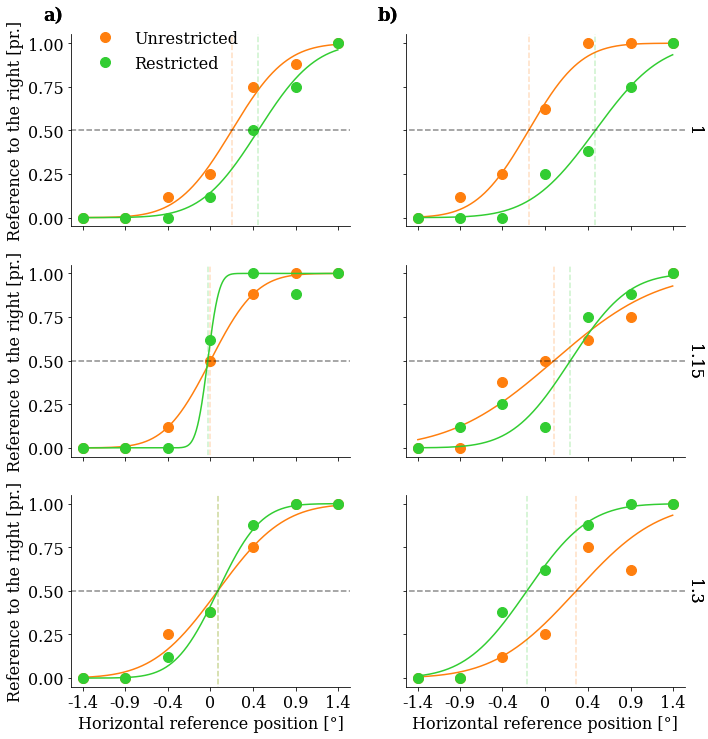

In [55]:
# exp 3 - example pfs
ex_subs = ["JNSE", "PRDE"] # "JNSE", "MLCA", "PRDE", "WGAE", "YNCE"

fig, axs = plt.subplots(3,2, sharex=True, sharey=True, figsize=[11, 12])#, constrained_layout=True)
markersize = 10
gain_list = [[0, "1", "k"], [0.15, "1.15", "tab:green"], [0.3, "1.3", "tab:red"]]

for sub_idx, sub in enumerate(ex_subs):
        
    for move_idx, move in enumerate([["Unrestricted", "Movement", colors["unrestricted"]], ["Restricted", "NoMovement", colors["restricted"]]]):
        move_name, move, move_color = move
        move_color, color_alpha = move_color
        for gain_idx, gain_info in enumerate(gain_list):
            gain, gain_name, gain_color = gain_info
            
            if sub_idx == 0:
                ax_col = 0
                ax = axs[gain_idx, ax_col]
                ax.set_ylabel("Reference to the right [pr.]")
            else:
                ax_col = 1
                ax = axs[gain_idx, ax_col]
                ax.text(1, 0.5, gain_name, horizontalalignment='left', verticalalignment='center', 
                        transform=ax.transAxes, font=font, rotation=270, color="k")
                
            if gain_idx == 2:
                ax.set_xlabel("Horizontal reference position [°]")
                
            if ax == axs[0,0]:
                ax.text(-0.1, 1.1, "a)", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
            elif ax == axs[0,1]:
                ax.text(-0.1, 1.1, "b)", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
                
            ax.spines[['right', 'top']].set_visible(False)
            ax.set_ylim(-0.05, 1.05)
            ax.set_yticks([0, 0.25, 0.5, 0.75,1])
            ax.set_xlim([-1.5, 1.5])
            x_ticks = [-1.37, -0.92, -0.46, 0, 0.46, 0.92, 1.37]
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(["-1.4", "-0.9", "-0.4", "0", "0.4", "0.9", "1.4"])
            
            # Shift in cm: -3, visual angle: -1.37
            # Shift in cm: -2, visual angle: -0.92
            # Shift in cm: -1, visual angle: -0.46
            # Shift in cm: 0, visual angle: 0.0
            # Shift in cm: 1, visual angle: 0.46
            # Shift in cm: 2, visual angle: 0.92
            # Shift in cm: 3, visual angle: 1.37
            
            cut_pse_df = balanced_clean_pse_df.query('SubjectID == @sub & Movement == @move & Gain == @gain')
            data_x = cut_pse_df["X"].iloc[0]
            data_y = cut_pse_df["Y"].iloc[0]
            pse, jnd, pf_r2, pse_ir, points, x, y = fit_func(data_x, data_y, [0,0])
            
            lin_space = np.linspace(data_x[0], data_x[-1], 1000)
            ax.plot(lin_space, norm.cdf(lin_space, pse, jnd), move_color, ls="-")
            
            if move_color == "k":
                alpha = 0.5
            else:
                alpha = 1
            
            if sub_idx == 0:
                ax.plot(data_x, data_y, "o", ms=markersize, markerfacecolor=move_color, markeredgecolor=move_color, label=move_name, alpha=alpha)
                
                if gain_idx == 0:
                    ax.legend(frameon=False, bbox_to_anchor=[0.65,1.1])
            else:
                ax.plot(data_x, data_y, "o", ms=markersize, markerfacecolor=move_color, markeredgecolor=move_color, alpha=alpha)
            
            print(sub, move, gain)
            print(pse, jnd)
            print(data_x)
            print(data_y)
            
            ax.hlines(y=0.5, xmin=-3, xmax=3, ls="--", color="k", alpha=0.25)
            ax.vlines(x=pse, ymin=-1, ymax=2, ls="--", color=move_color, alpha=0.25)
           
plt.savefig(figure_p.joinpath("exp3_example_pfs.png"), dpi=300, facecolor="white", bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp3_example_pfs.pdf"), dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

In [56]:
# exp 3 - pf inference
# av_res = AnovaRM(balanced_clean_pse_df, "PSE", "SubjectID", ["Movement", "Gain"], aggregate_func="mean").fit() # balanced_clean_pse_df
# display(HTML(av_res.summary().as_html()))
num_subs = len(list(np.unique(balanced_clean_pse_df["SubjectID"])))

for col in ["PSE", "JND"]:
    print(col)
    aov = pg.rm_anova(data=balanced_clean_pse_df, dv=col, within=["Movement", "Gain"], subject='SubjectID', detailed=True, effsize="np2")
    
    powers = []
    for idx, row in aov.iterrows():
        pow = pg.power_anova(eta=row["np2"], k=row["ddof1"] + 1, n=num_subs, alpha=0.05)
        powers.append(pow)
    
    aov = aov.assign(Power = powers)
    print(aov.round(3))
    print("\n")

PSE
            Source     SS  ddof1  ddof2     MS      F  p-unc  p-GG-corr    np2    eps  Power
0         Movement  0.750      1     24  0.750  7.156  0.013      0.013  0.230  1.000  0.966
1             Gain  0.248      2     48  0.124  1.071  0.351      0.347  0.043  0.918  0.342
2  Movement * Gain  0.077      2     48  0.038  0.432  0.652      0.644  0.018  0.961  0.159


JND
            Source     SS  ddof1  ddof2     MS      F  p-unc  p-GG-corr    np2    eps  Power
0         Movement  0.014      1     24  0.014  0.090  0.767      0.767  0.004  1.000  0.071
1             Gain  1.276      2     48  0.638  0.796  0.457      0.387  0.032  0.525  0.263
2  Movement * Gain  1.516      2     48  0.758  1.073  0.350      0.317  0.043  0.548  0.342




In [57]:
# exp 3 - mean pse / jnd
stat_df = balanced_clean_pse_df.query('SubjectID.isin(@inc_subs)')
vals = stat_df["PSE"]
jnds = stat_df["JND"]
print("Mean PSE: {:1.2f} (SE = {:1.2f})".format(np.mean(vals), np.std(vals) / np.sqrt(len(vals))))
print("Mean JND: {:1.2f} (SE = {:1.2f})".format(np.mean(jnds), np.std(jnds) / np.sqrt(len(jnds))))

Mean PSE: 0.22 (SE = 0.04)
Mean JND: 0.69 (SE = 0.07)


In [58]:
# exp 3 - 0.25 / 0.75 values
df_025_075 = pd.DataFrame()
data_p = stats_p.joinpath("data","Round Effmann", "Raw")
d_files = np.sort(bf.get_data(data_p,"csv","", ["timings", "head","eye"]))

for sub in inc_subs:
    sub_files = [x for x in d_files if sub in x]
    
    for sub_file in sub_files:
        df = df_from_file(sub_file)
        df_025_075 = pd.concat([df_025_075, df])
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_025_075_pse = single_sub_25_75(df_025_075, "Response", "TargetHoriPos")

for col in ["PSE_0.25", "PSE_0.75"]:
    vals = df_025_075_pse[col]
    print("{}: {:1.2f} ({:1.2f})".format(col, np.mean(vals), np.std(vals) / np.sqrt(len(vals))))

PSE_0.25: -0.23 (0.08)
PSE_0.75: 0.80 (0.08)


In [59]:
# plot pse anova - exp 3
plot_dict = {}
for movement in ["Movement", "NoMovement"]:
    plot_dict[movement] = {}

for df_info, df in balanced_clean_pse_df.groupby(["Movement", "Gain"]):
    movement, gain = list(df_info)
    plot_dict[movement][gain] = {}
    plot_dict[movement][gain]["pses"] = df["PSE"].values
    plot_dict[movement][gain]["jnds"] = df["JND"].values
    plot_dict[movement][gain]["subs"] = df["SubjectID"].values

# plotting
# for av in ["pses", "jnds"]:
fig, axs = plt.subplots(1,2, figsize=[12,6], sharey=False)
letters = ["a)", "b)"]

for av_idx, av in enumerate(["pses", "jnds"]):#, "jnds"]):
    ax = axs[av_idx]
    ax.text(-0.22, 1.05, letters[av_idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
    gains = [0, 0.15, 0.3] # ["Baseline", "Low", "High"]
    x_ticks = [0.25,1.25,2.25]

    ax.set_xticks(x_ticks, fontdict=font)
    ax.set_xticklabels(["1", "1.15", "1.3"], fontdict=font)

    ax.set_xlabel("Visual velocity gain", fontdict=font)
    ax.set_xlim([0,2.5])

    if av == "pses":
        ax.set_ylim([-0.1, 0.6])
    else:
        ax.set_ylim([0.2, 1.6])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for move in ["Movement", "NoMovement"]:
        coef = -0.025
        if move == "NoMovement":
            coef = 0.025
        
        cond_x_ticks = [x + coef for x in x_ticks]
        d = [plot_dict[move][gain][av] for gain in gains]
        
        if move == "NoMovement":
            color, alpha = colors["restricted"]
            label = "Restricted"
        else:
            color, alpha = colors["unrestricted"]
            label = "Unrestricted"
        
        ax.plot(x_ticks, [np.mean(arr) for arr in d], color=color, alpha=alpha) # label=move, 
        ax.scatter(cond_x_ticks, [np.mean(arr) for arr in d], label=label, color=color, alpha=alpha, s=150, zorder=3)
        # ax.scatter([[gain]*len(d[idx]) for idx, gain in enumerate(gains)], [arr for arr in d])
        ax.errorbar(cond_x_ticks, [np.mean(arr) for arr in d], yerr=[np.std(arr) / np.sqrt(len(arr)) for arr in d], lw=1, c="k", linestyle="", capsize=10)
        
        # if av == "pses":
        x = []
        y = []
        x_vals = [1,1.15,1.3]
        
        for idx, arr in enumerate(d):
            for val in arr:
                x.append(x_vals[idx])
                y.append(val)
        
        slope, intercept = curve_fit(lin_func, x, y)[0]
        print(av, move, "y = {:.2f} + {:.2f}x".format(intercept, slope), [np.mean(arr) for arr in d])

    ax.legend(loc="upper center", frameon=False, fontsize=font_size)
    
    if av == "pses":
        ax.set_ylabel("PHA [°]", fontdict=font)
        ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
        ax.hlines(y=0, xmin=0, xmax=2.4, ls="--", color="k")
        ax.set_xlim([0, 2.4])
    else:
        ax.set_ylabel("JND [°]", fontdict=font)
        ax.set_yticks([0.4, 0.7, 1, 1.3, 1.6])
        ax.set_ylim([0.4, 1.6])
    
plt.savefig(figure_p.joinpath("exp3_pf.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp3_pf.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.close()

pses Movement y = -0.34 + 0.43x [0.06135042879588454, 0.1925481002053518, 0.18919091196866425]
pses NoMovement y = 0.06 + 0.20x [0.26217828424351974, 0.2835146609744875, 0.3217737670691291]
jnds Movement y = 0.39 + 0.25x [0.6511481470615069, 0.6505917511511652, 0.726618976208289]
jnds NoMovement y = 1.93 + -1.08x [0.9528583568297596, 0.5022299397660794, 0.6302419906414677]


Movement
[0.06135042879588454, 0.1925481002053518, 0.18919091196866425]
[0.08294348793093889, 0.0986417191512242, 0.0970970955430098]
pses Movement y = -0.34 + 0.43x [0.06135042879588454, 0.1925481002053518, 0.18919091196866425]
NoMovement
[0.26217828424351974, 0.2835146609744875, 0.3217737670691291]
[0.09266215790981087, 0.06608485024141351, 0.09587089243000532]
pses NoMovement y = 0.06 + 0.20x [0.26217828424351974, 0.2835146609744875, 0.3217737670691291]
Movement
[0.6511481470615069, 0.6505917511511652, 0.726618976208289]
[0.10203507941937169, 0.06144003120847741, 0.1586283956431884]
jnds Movement y = 0.39 + 0.25x [0.6511481470615069, 0.6505917511511652, 0.726618976208289]
NoMovement
[0.9528583568297596, 0.5022299397660794, 0.6302419906414677]
[0.37899530136524173, 0.04983354721542309, 0.04940402535490774]
jnds NoMovement y = 1.93 + -1.08x [0.9528583568297596, 0.5022299397660794, 0.6302419906414677]


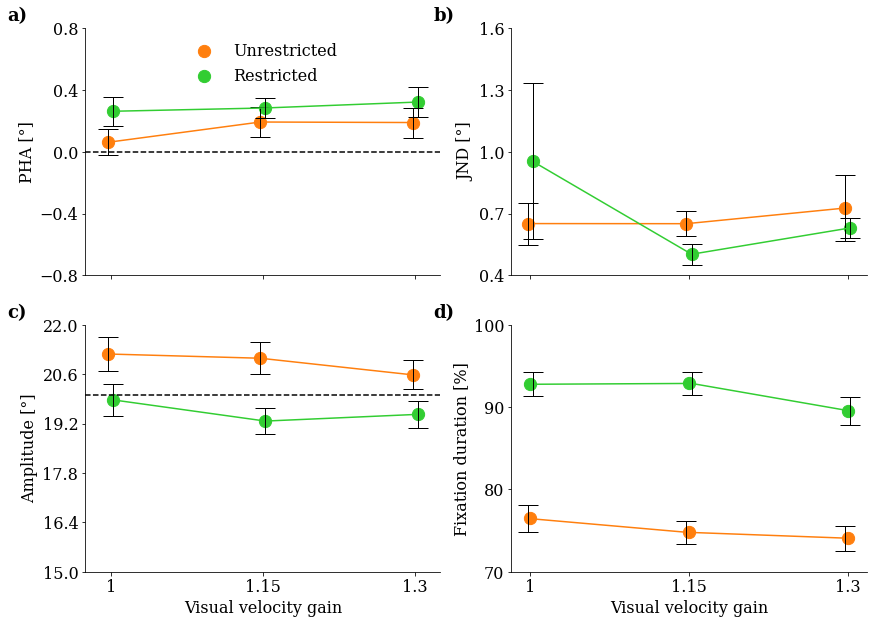

In [60]:
# plot pse anova - exp 3
plot_dict = {}
for movement in ["Movement", "NoMovement"]:
    plot_dict[movement] = {}

for df_info, df in balanced_clean_pse_df.groupby(["Movement", "Gain"]):
    movement, gain = list(df_info)
    plot_dict[movement][gain] = {}
    plot_dict[movement][gain]["pses"] = df["PSE"].values
    plot_dict[movement][gain]["jnds"] = df["JND"].values
    plot_dict[movement][gain]["subs"] = df["SubjectID"].values

# plotting
# for av in ["pses", "jnds"]:
fig, axs = plt.subplots(2,2, figsize=[14,10], sharey=False)
letters = ["a)", "b)", "c)", "d)"]
counter = -1
x_ticks = [1,1.15,1.3]

for idx in [0,1]:
    for ax in axs[idx]:
        counter = counter + 1
        ax.text(-0.22, 1.05, letters[counter], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")
        ax.set_xticks(x_ticks, fontdict=font)
        ax.spines[['top', "right"]].set_visible(False)
        
        if counter in [2, 3]:
            ax.set_xticklabels(["1", "1.15", "1.3"], fontdict=font)
            ax.set_xlabel("Visual velocity gain", fontdict=font)
        else:
            ax.set_xticklabels([])

for av_idx, av in enumerate(["pses", "jnds"]):#, "jnds"]):
    if av == "pses":
        ax = axs[0,0]
    else:
        ax = axs[0,1]
        
    gains = [0, 0.15, 0.3] # ["Baseline", "Low", "High"]

    # ax.set_xlim([0,2.5])

    if av == "pses":
        ax.set_ylim([-0.1, 0.6])
    else:
        ax.set_ylim([0.2, 1.6])

    for move in ["Movement", "NoMovement"]:
        coef = -0.0025
        if move == "NoMovement":
            coef = 0.0025
        
        cond_x_ticks = [x + coef for x in x_ticks]
        d = [plot_dict[move][gain][av] for gain in gains]
        
        if move == "NoMovement":
            color, alpha = colors["restricted"]
            label = "Restricted"
        else:
            color, alpha = colors["unrestricted"]
            label = "Unrestricted"
        
        # print(cond_x_ticks)
        
        print(move)
        print([np.mean(arr) for arr in d], )
        print([np.std(arr) / np.sqrt(len(arr)) for arr in d])
        
        ax.plot(cond_x_ticks, [np.mean(arr) for arr in d], color=color, alpha=alpha) # label=move, 
        ax.scatter(cond_x_ticks, [np.mean(arr) for arr in d], label=label, color=color, alpha=alpha, s=150)#, zorder=3)
        # ax.scatter([[gain]*len(d[idx]) for idx, gain in enumerate(gains)], [arr for arr in d])
        ax.errorbar(cond_x_ticks, [np.mean(arr) for arr in d], yerr=[np.std(arr) / np.sqrt(len(arr)) for arr in d], lw=1, c="k", linestyle="", capsize=10)
        
        # if av == "pses":
        x = []
        y = []
        x_vals = [1,1.15,1.3]
        
        for idx, arr in enumerate(d):
            for val in arr:
                x.append(x_vals[idx])
                y.append(val)
        
        slope, intercept = curve_fit(lin_func, x, y)[0]
        print(av, move, "y = {:.2f} + {:.2f}x".format(intercept, slope), [np.mean(arr) for arr in d])

    if av == "pses":
        ax.set_ylabel("PHA [°]", fontdict=font)
        ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
        # ax.set_xlim([0, 2.4])
        ax.legend(loc="upper center", frameon=False, fontsize=font_size)
    else:
        ax.set_ylabel("JND [°]", fontdict=font)
        ax.set_yticks([0.4, 0.7, 1, 1.3, 1.6])
        ax.set_ylim([0.4, 1.6])
        
# plot move parameters
exp3_amps = pd.concat([exp3_head_desc, exp3_eye_desc, exp3_sacc_amp])

ax = axs[1,0]
ax.set_ylabel("Amplitude [°]", fontdict=font)
ax.set_yticks([15, 16.4, 17.8, 19.2, 20.6, 22])
ax.set_ylim([15, 22])
coef = 0

for av, color in [["HeadMoveAmplitudeY", "tab:red"]]: #, ["Sub_Mean_Sacc_Amp", "tab:blue"]]:
    exp2_amps_cut = exp3_amps.query('AV == @av').tail(6)
    
    for part in ["head", "tail"]:
        if part == "head":
            exp2_eye_desc_cut_cut = exp2_amps_cut.head(3)
            label ="Restricted"
            color = colors["restricted"][0]
            coef = 0.0025
        else:
            exp2_eye_desc_cut_cut = exp2_amps_cut.tail(3)
            label ="Unrestricted"
            color = colors["unrestricted"][0]
            coef = -0.0025
    
        # print_df(exp2_eye_desc_cut_cut)
        
        means = exp2_eye_desc_cut_cut["Mean"]
        ses = exp2_eye_desc_cut_cut["SE"]
        
        cond_x_ticks = [x + coef for x in x_ticks]
        ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label=label)
        ax.plot(cond_x_ticks, means, color=color, alpha=alpha) #label=move, 
        ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)
        
# fixation
ax = axs[1,1]
ax.set_ylabel("Fixation duration [%]", fontdict=font)
ax.set_yticks([70, 80,90,100])
ax.set_ylim([70, 100])
coef = 0

exp2_eye_desc_cut = exp3_amps.query('AV == "RightCrossFixEyeDuringHeadMovement_Y_per"').tail(6)
    
# print_df(exp2_eye_desc_cut)
    
for part in ["head", "tail"]:
    if part == "head":
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.head(3)
        color = colors["restricted"][0]
        coef = 0.0025
    else:
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.tail(3)
        color = colors["unrestricted"][0]
        coef = -0.0025
    
    means = exp2_eye_desc_cut_cut["Mean"]
    ses = exp2_eye_desc_cut_cut["SE"]
    
    if part == "head":
        ax.scatter(x_ticks, means, color=color, alpha=alpha, s=150, label=label)
    else:
        ax.scatter(x_ticks, means, color=color, alpha=alpha, s=150,)
        
    cond_x_ticks = [x + coef for x in x_ticks]
    ax.plot(cond_x_ticks, means, color=color, alpha=alpha) #label=move, 
    ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)

axs[0,0].hlines(y=0, xmin=0.975, xmax=1.325, ls="--", color="k")
axs[0,0].set_xlim([0.975, 1.325])

axs[1,0].hlines(y=20, xmin=0.975, xmax=1.325, ls="--", color="k")
axs[1,0].set_xlim([0.975, 1.325])
    
plt.savefig(figure_p.joinpath("exp3_pf_enhanced.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp3_pf_enhanced.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.show()

In [61]:
# exp 3 - regression analysis - intercept - move vs. no-mmove
stat_df = balanced_clean_pse_df #.groupby(["SubjectID", "Movement"]).mean().reset_index()

# move vs no move
for av in ["PSE", "JND"]:
    print(av)
    keys = ["SubjectID", "Move", "Slope", "Intercept"]
    exp3_slope_ana_move = {}
    for key in keys:
        exp3_slope_ana_move[key] = []

    for sub in np.unique(stat_df["SubjectID"]):
        for move in ["Movement", "NoMovement"]:
            cut_df = stat_df.query('SubjectID == @sub & Movement == @move')
            slope, intercept = curve_fit(lin_func, cut_df["Gain"], cut_df[av])[0]
            
            for key, val in zip(keys, [sub, move, slope, intercept]):
                exp3_slope_ana_move[key].append(val)
                
    exp3_slope_ana_move = pd.DataFrame(exp3_slope_ana_move)

    arr1 = exp3_slope_ana_move.query('Move == "Movement"')["Intercept"]
    arr2 = exp3_slope_ana_move.query('Move == "NoMovement"')["Intercept"]

    _ = dep_ttest(arr1, arr2,side="two-sided",corr=1, b_print=True)

    print("Move: {:.2f} ({:.2f})".format(np.mean(arr1), np.std(arr1) / np.sqrt(arr1.shape[0])))
    print("NoMove: {:.2f} ({:.2f})".format(np.mean(arr2), np.std(arr2) / np.sqrt(arr2.shape[0])))

PSE
t(24) = -2.90, p = 0.008
Move: 0.08 (0.08)
NoMove: 0.26 (0.08)
JND
t(24) = -0.79, p = 0.435
Move: 0.64 (0.07)
NoMove: 0.86 (0.31)


In [62]:
# exp 3 - regression analysis - slope - vs. 0 (move split)
stat_df = balanced_clean_pse_df #.groupby(["SubjectID", "Movement"]).mean().reset_index()

# move vs no move
for av in ["PSE", "JND"]:
    print(av)
    keys = ["SubjectID", "Move", "Slope", "Intercept"]
    exp3_slope_ana_move = {}
    for key in keys:
        exp3_slope_ana_move[key] = []

    for sub in np.unique(stat_df["SubjectID"]):
        for move in ["Movement", "NoMovement"]:
            cut_df = stat_df.query('SubjectID == @sub & Movement == @move')
            slope, intercept = curve_fit(lin_func, cut_df["Gain"], cut_df[av])[0]
            
            for key, val in zip(keys, [sub, move, slope, intercept]):
                exp3_slope_ana_move[key].append(val)
                
    exp3_slope_ana_move = pd.DataFrame(exp3_slope_ana_move)

    arr1 = exp3_slope_ana_move.query('Move == "Movement"')["Slope"]
    arr2 = exp3_slope_ana_move.query('Move == "NoMovement"')["Slope"]

    print(ttest_1samp(arr1, 0, alternative="greater"))
    print("Move: {:.2f} ({:.2f})".format(np.mean(arr1), np.std(arr1) / np.sqrt(arr1.shape[0])))

    print(ttest_1samp(arr2, 0, alternative="greater"))
    print("No Move: {:.2f} ({:.2f})".format(np.mean(arr2), np.std(arr2) / np.sqrt(arr2.shape[0])))

PSE
Ttest_1sampResult(statistic=2.032764071004559, pvalue=0.026640733895038803)
Move: 0.43 (0.21)
Ttest_1sampResult(statistic=0.6278841454247786, pvalue=0.26800459248594505)
No Move: 0.20 (0.31)
JND
Ttest_1sampResult(statistic=0.8454269957632485, pvalue=0.20311124485980664)
Move: 0.25 (0.29)
Ttest_1sampResult(statistic=-0.8274377633414967, pvalue=0.791929561954384)
No Move: -1.08 (1.27)


In [63]:
# exp 3 - regression analysis - slope - move vs. no-mmove
stat_df = balanced_clean_pse_df #.groupby(["SubjectID", "Movement"]).mean().reset_index()

for av in ["PSE", "JND"]:
    print(av)
    # move vs no move
    keys = ["SubjectID", "Move", "Slope", "Intercept"]
    exp3_slope_ana_move = {}
    for key in keys:
        exp3_slope_ana_move[key] = []

    for sub in np.unique(stat_df["SubjectID"]):
        for move in ["Movement", "NoMovement"]:
            cut_df = stat_df.query('SubjectID == @sub & Movement == @move')
            slope, intercept = curve_fit(lin_func, cut_df["Gain"], cut_df[av])[0]
            
            for key, val in zip(keys, [sub, move, slope, intercept]):
                exp3_slope_ana_move[key].append(val)
                
    exp3_slope_ana_move = pd.DataFrame(exp3_slope_ana_move)

    arr1 = exp3_slope_ana_move.query('Move == "Movement"')["Slope"]
    arr2 = exp3_slope_ana_move.query('Move == "NoMovement"')["Slope"]

    _ = dep_ttest(arr1, arr2,side="two-sided",corr=1, b_print=True)

PSE
t(24) = 0.63, p = 0.532
JND
t(24) = 0.87, p = 0.391


In [64]:
# exp 3 - regression analysis - slope - vs. 0 (no move split)
stat_df = balanced_clean_pse_df.groupby(["SubjectID", "Gain"]).mean().reset_index()

# move vs no move
keys = ["SubjectID", "Slope", "Intercept"]
exp3_slope_ana_gain = {}
for key in keys:
    exp3_slope_ana_gain[key] = []

for sub in np.unique(stat_df["SubjectID"]):
    
    cut_df = stat_df.query('SubjectID == @sub')
    slope, intercept = curve_fit(lin_func, cut_df["Gain"], cut_df["PSE"])[0]
    
    for key, val in zip(keys, [sub, slope, intercept]):
        exp3_slope_ana_gain[key].append(val)
            
exp3_slope_ana_gain = pd.DataFrame(exp3_slope_ana_gain)

print(ttest_1samp(exp3_slope_ana_gain["Slope"], 0, alternative="greater"))

Ttest_1sampResult(statistic=1.5636588975313683, pvalue=0.0654944663907182)


### final panels

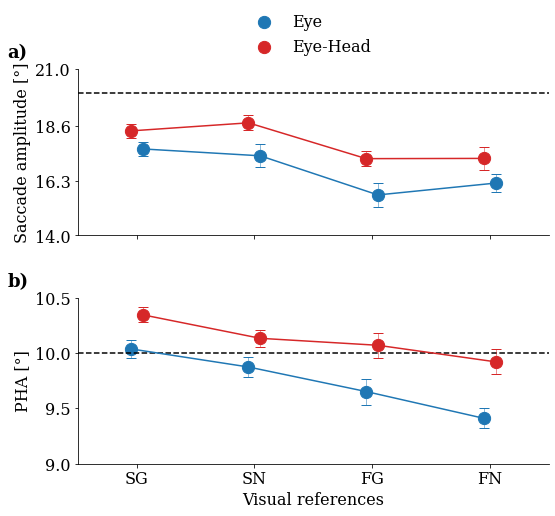

In [65]:
# exp 2 panel - new arrangement no bar
fig = plt.figure(figsize=[8, 10], tight_layout=True)
gs = gridspec.GridSpec(3, 4)

ax1 = fig.add_subplot(gs[0, :])
# ax2 = fig.add_subplot(gs[0, :2])
# ax3 = fig.add_subplot(gs[0, 2:])
ax4 = fig.add_subplot(gs[1, :])

axs = [ax1, ax4]#ax2, ax3, 
x_ticks = [1, 1.1, 1.2, 1.3]
labels = ["SG", "SN", "FG", "FN"]
# labels.reverse()

for ax in axs:
    ax.spines[['top', "right"]].set_visible(False)
    
# plot amplitudes
ax = ax1
ax.set_ylabel("Saccade amplitude [°]", fontdict=font)
# ax.set_xlabel("Visual references")

ax.set_xticks(x_ticks)
ax.set_xticklabels([])#labels
ax.set_xlim([0.95, 1.35])

ax.set_yticks([14, 16.3, 18.6, 21])
ax.set_ylim([14, 21])
ax.hlines(y=20, xmin=0.95, xmax=1.35, ls="--", color="k")

for av, color in [["SaccAmpTotal", "tab:blue"]]: # ["HeadMoveAmplitudeY", "tab:red"]]: #, 
    exp2_amps_cut = exp12_amps.query('AV == @av').query('Exp == "Exp1"').tail(4)
    
    # print_df(exp2_amps_cut)
    
    for part in ["head"]: #"tail", 
        if part == "head":
            exp2_eye_desc_cut_cut = exp2_amps_cut.head(4)
            label ="Restricted"
            coef = 0.005
        
        means = list(exp2_eye_desc_cut_cut["Mean"])
        ses = list(exp2_eye_desc_cut_cut["SE"])
        
        # means.reverse()
        # ses.reverse()
        
        cond_x_ticks = [x + coef for x in x_ticks]
        
        if part == "head":
            ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label="Eye")
        else:
            ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150)
            
        ax.plot(cond_x_ticks, means, color=color, alpha=alpha) #label=move, 
        ax.errorbar(cond_x_ticks, means, yerr=ses, lw=0.5, c=color, linestyle="", capsize=5)
        
        # print(av, part, color)
        
for av, color in [["SaccAmpTotal", "tab:blue"]]: # ["HeadMoveAmplitudeY", "tab:red"]]: #, 
    exp2_amps_cut = exp12_amps.query('AV == @av').tail(12).head(4)
    
    # print_df(exp2_amps_cut)
    
    color = colors["Head"][0]
    exp2_eye_desc_cut_cut = exp2_amps_cut.head(4)
    label ="Eye-Head"
    coef = -0.005
        
    means = list(exp2_eye_desc_cut_cut["Mean"])
    ses = list(exp2_eye_desc_cut_cut["SE"])
    
    # means.reverse()
    # ses.reverse()
    
    cond_x_ticks = [x + coef for x in x_ticks]
    
    ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label=label)
    ax.plot(cond_x_ticks, means, color=color, alpha=alpha) #label=move, 
    ax.errorbar(cond_x_ticks, means, yerr=ses, lw=0.5, c=color, linestyle="", capsize=5)

# plot psychometric examples
# run = "Eye"
if False:
    target = "PermanentTargets"
    gabor = "Gabor"

    for ax, sub in zip([ax2, ax3], ["TK15", "SM03"]):# AO23
        ax.hlines(y=0.5, xmin=8.5, xmax=11.5, ls="--", color="k") # , alpha=0.25
        ax.set_xlim([8.5, 11.5])
        ax.set_xticks([8.5, 9.25, 10, 10.75,  11.5])
        
        ax.set_ylim(-0.05, 1.05)
        ax.set_yticks([0, 0.25, 0.5, 0.75,1])
        # ax.set_xticklabels(["-1.5", "0", "1.5"])
        ax.set_xlabel("Reference [°]")
        
        if ax == ax3:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Perceived right [pr.]")
            
        for run in ["Eye", "HeadEye"]:
            label = "Eye-Head"
            color = colors["Head"][0]
            if run == "Eye":
                color = colors["Eye"][0]
                label = "Eye"
                
            for move in ["Movement"]:
                cut_pse_df = balanced_pse_df_2.query('SubjectID == @sub & Run == @run & Movement == @move & Target == @target & Gabor == @gabor')
                data_x = cut_pse_df["Lvl_Arr"].iloc[0]
                data_x = [x + 10 for x in data_x]
                data_y = cut_pse_df["Resp_Arr"].iloc[0]
                pse, jnd, pf_r2, pse_ir, points, x, y = fit_func(data_x, data_y, [0,0])
                lin_space = np.linspace(data_x[0], data_x[-1], 1000)

                ax.plot(lin_space, norm.cdf(lin_space, pse, jnd), color, ls="-", label=label)
                ax.plot(data_x, data_y, "o", ms=markersize, markerfacecolor=color, markeredgecolor=color)
                ax.hlines(y=0.5, xmin=-3, xmax=3, ls="--", color="k", alpha=0.25)
                ax.vlines(x=pse, ymin=-1, ymax=2, ls="--", color=color, alpha=0.25)
    
# plot pha
ax = ax4
ax.set_ylim([9, 10.5])
# ticks = [-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]
# ticks = [x +10 for x in ticks]
# ax.set_yticks(ticks)
ax.set_ylabel("PHA [°]")#, fontdict=font)
ax.set_xlabel("Visual references")

ax.hlines(y=10, xmin=0.95, xmax=1.35, ls="--", color="k")
ax.set_xlim([0.95, 1.35])

ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)

for run in ["Eye", "Head"]:
    if run == "Eye":
        stat_df = balanced_pse_df_2.groupby(["SubjectID", "Run", "Movement", "Target", "Gabor"]).mean().reset_index()
        stat_df = stat_df.query('Run == "Eye"')

        means = []
        ses = []

        moves = ["Movement"] #, "NoMovement"

        for move in moves:
            for target in ["PermanentTargets", "TemporaryTargets"]:
                for gabor in ["Gabor", "NoGabor"]:
                    cut_df = stat_df.query('Movement == @move & Target == @target & Gabor == @gabor')
                    
                    vals = cut_df["PSE"]
                    means.append(np.mean(vals))
                    ses.append(np.std(vals) / np.sqrt(len(list(vals))))
    else:
        stat_df = balanced_pse_df_2.groupby(["SubjectID", "Run", "Target", "Gabor"]).mean().reset_index()
        stat_df = stat_df.query('Run == "HeadEye"')
        
        means = []
        ses = []

        moves = ["Movement", "NoMovement"]

        # for move in moves:
        for target in ["PermanentTargets", "TemporaryTargets"]:
            for gabor in ["Gabor", "NoGabor"]:
                cut_df = stat_df.query('Target == @target & Gabor == @gabor')
                
                vals = cut_df["PSE"]
                means.append(np.mean(vals))
                ses.append(np.std(vals) / np.sqrt(len(list(vals))))
    
    coef = 0
    color = colors["unrestricted"][0]
    label = "Unrestricted"
    cond_means = means[:4]
    cond_ses = ses[:4]
    
    if run == "Head":
        coef = 0.005
        color = colors["Head"][0]
        label = "Eye-Head"
        cond_means = means[:4]
        cond_ses = ses[:4]
        
    if run == "Eye":
        coef = -0.005
        color = colors["Eye"][0]
        label = "Eye"
        
    # cond_means.reverse()
    # cond_ses.reverse()
    
    cond_means = [x + 10 for x in cond_means]
        
    cond_x_ticks = [x + coef for x in x_ticks]
    ax.scatter(cond_x_ticks, cond_means, color=color, alpha=alpha, s=150) #, label=label
    ax.plot(cond_x_ticks, cond_means, color=color, alpha=alpha) #, width = 0.04
    ax.errorbar(cond_x_ticks, cond_means, yerr=cond_ses, lw=0.5, c=color, linestyle="", capsize=5)
    
# ax2.legend(frameon=False, bbox_to_anchor=(1.8,1.7)) #, bbox_transform=ax.transAxes loc="upper left"

# ax1.legend(frameon=False, loc='lower left')#, fontsize = 13) #bbox_to_anchor=(0.8, 1.02), mode="expand", , borderaxespad=0.
ax1.legend(frameon=False, bbox_to_anchor=[0.33,1])#, fontsize = 13) #bbox_to_anchor=(0.8, 1.02), mode="expand", , borderaxespad=0.

letters = ["a)", "a)", "b)"]
xpos = [-0.15, -0.33, -0.15]
ypos = [1.1] *3

for idx, ax in enumerate([ax1,ax2,ax4]):
    ax.text(xpos[idx], ypos[idx], letters[idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")

plt.savefig(figure_p.joinpath("exp2_panel.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp2_panel.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.show()

In [66]:
# exp 2 panel - exp 2 no split - bar
fig = plt.figure(figsize=[10, 10], tight_layout=True)
gs = gridspec.GridSpec(3, 4)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[1, 2:])
ax4 = fig.add_subplot(gs[2, :])

axs = [ax1, ax2, ax3, ax4]
x_ticks = [1, 1.1, 1.2, 1.3]
labels = ["SG", "SN", "NG", "NN"]
# labels.reverse()

for ax in axs:
    ax.spines[['top', "right"]].set_visible(False)
    
# plot amplitudes
ax = ax1
ax.set_xlabel("Amplitude [°]", fontdict=font)
ax.set_ylabel("Visual references")

ax.set_yticks(x_ticks)
ax.set_yticklabels(labels)
ax.set_ylim([0.95, 1.35])

# ax.set_xticks([16, 1, 21])
ax.set_xlim([14, 21])
ax.vlines(x=20, ymin=0.95, ymax=1.35, ls="--", color="k")

for av, color in [["SaccAmpTotal", "tab:blue"]]: # ["HeadMoveAmplitudeY", "tab:red"]]: #, 
    exp2_amps_cut = exp12_amps.query('AV == @av').query('Exp == "Exp1"').tail(4)
    
    # print_df(exp2_amps_cut)
    
    for part in ["head"]: #"tail", 
        if part == "head":
            exp2_eye_desc_cut_cut = exp2_amps_cut.head(4)
            label ="Restricted"
            coef = 0.005
        
        means = exp2_eye_desc_cut_cut["Mean"]
        ses = exp2_eye_desc_cut_cut["SE"]
        
        cond_x_ticks = [x + coef for x in x_ticks]
        
        if part == "head":
            ax.scatter(means, cond_x_ticks, color=color, alpha=alpha, s=150, label="Eye")
        else:
            ax.scatter(means, cond_x_ticks, color=color, alpha=alpha, s=150)
            
        ax.plot(means, cond_x_ticks, color=color, alpha=alpha) #label=move, 
        ax.errorbar(means, cond_x_ticks, xerr=ses, lw=1, c="k", linestyle="", capsize=10)
        
        # print(av, part, color)
        
for av, color in [["SaccAmpTotal", "tab:blue"]]: # ["HeadMoveAmplitudeY", "tab:red"]]: #, 
    exp2_amps_cut = exp12_amps.query('AV == @av').tail(12).head(4)
    
    # print_df(exp2_amps_cut)
    
    color = colors["Head"][0]
    
    
    exp2_eye_desc_cut_cut = exp2_amps_cut.head(4)
    label ="Eye-Head"
    coef = 0
        
    means = exp2_eye_desc_cut_cut["Mean"]
    ses = exp2_eye_desc_cut_cut["SE"]
    
    cond_x_ticks = [x + coef for x in x_ticks]
    
    ax.scatter(means, cond_x_ticks, color=color, alpha=alpha, s=150, label=label)
    ax.plot(means, cond_x_ticks, color=color, alpha=alpha) #label=move, 
    ax.errorbar(means, cond_x_ticks, xerr=ses, lw=1, c="k", linestyle="", capsize=10)

# plot psychometric examples
# run = "Eye"
target = "PermanentTargets"
gabor = "Gabor"

for ax, sub in zip([ax2, ax3], ["TK15", "SM03"]):# AO23
    ax.hlines(y=0.5, xmin=-1.5, xmax=1.5, ls="--", color="k") # , alpha=0.25
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 0.25, 0.5, 0.75,1])
    ax.set_xticks([-1.5, -0.75, 0, 0.75, 1.5])
    # ax.set_xticklabels(["-1.5", "0", "1.5"])
    ax.set_xlabel("Position [°]")
    
    if ax == ax3:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Perceived right [pr.]")
        
    for run in ["Eye", "HeadEye"]:
        color = colors["Head"][0]
        if run == "Eye":
            color = colors["Eye"][0]
            
        for move in ["Movement"]:
            cut_pse_df = balanced_pse_df_2.query('SubjectID == @sub & Run == @run & Movement == @move & Target == @target & Gabor == @gabor')
            data_x = cut_pse_df["Lvl_Arr"].iloc[0]
            data_y = cut_pse_df["Resp_Arr"].iloc[0]
            pse, jnd, pf_r2, pse_ir, points, x, y = fit_func(data_x, data_y, [0,0])
            lin_space = np.linspace(data_x[0], data_x[-1], 1000)

            ax.plot(lin_space, norm.cdf(lin_space, pse, jnd), color, ls="-")
            ax.plot(data_x, data_y, "o", ms=markersize, markerfacecolor=color, markeredgecolor=color, label=label)
            ax.hlines(y=0.5, xmin=-3, xmax=3, ls="--", color="k", alpha=0.25)
            ax.vlines(x=pse, ymin=-1, ymax=2, ls="--", color=color, alpha=0.25)
    
# plot pha
ax = ax4
ax.set_ylim([-0.8, 0.6])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_ylabel("PHA [°]")#, fontdict=font)
ax.set_xlabel("Visual references")

ax.hlines(y=0, xmin=0.95, xmax=1.35, ls="--", color="k")
ax.set_xlim([0.95, 1.35])
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)

for run in ["Eye", "Head"]:
    if run == "Eye":
        stat_df = balanced_pse_df_2.groupby(["SubjectID", "Run", "Movement", "Target", "Gabor"]).mean().reset_index()
        stat_df = stat_df.query('Run == "Eye"')

        means = []
        ses = []

        moves = ["Movement"] #, "NoMovement"

        for move in moves:
            for target in ["PermanentTargets", "TemporaryTargets"]:
                for gabor in ["Gabor", "NoGabor"]:
                    cut_df = stat_df.query('Movement == @move & Target == @target & Gabor == @gabor')
                    
                    vals = cut_df["PSE"]
                    means.append(np.mean(vals))
                    ses.append(np.std(vals) / np.sqrt(len(list(vals))))
    else:
        stat_df = balanced_pse_df_2.groupby(["SubjectID", "Run", "Target", "Gabor"]).mean().reset_index()
        stat_df = stat_df.query('Run == "HeadEye"')
        
        means = []
        ses = []

        moves = ["Movement", "NoMovement"]

        # for move in moves:
        for target in ["PermanentTargets", "TemporaryTargets"]:
            for gabor in ["Gabor", "NoGabor"]:
                cut_df = stat_df.query('Target == @target & Gabor == @gabor')
                
                vals = cut_df["PSE"]
                means.append(np.mean(vals))
                ses.append(np.std(vals) / np.sqrt(len(list(vals))))
    
    coef = 0
    color = colors["unrestricted"][0]
    label = "Unrestricted"
    cond_means = means[:4]
    cond_ses = ses[:4]
    
    if run == "Head":
        coef = 0.02
        color = colors["Head"][0]
        label = "Eye-Head"
        cond_means = means[:4]
        cond_ses = ses[:4]
        
    if run == "Eye":
        coef = -0.02
        color = colors["Eye"][0]
        label = "Eye"
        
    cond_x_ticks = [x + coef for x in x_ticks]
    # ax.scatter(cond_x_ticks, cond_means, color=color, alpha=alpha, s=150
    ax.bar(cond_x_ticks, cond_means, color=color, alpha=alpha, width = 0.04, label=label)
    ax.errorbar(cond_x_ticks, cond_means, yerr=cond_ses, lw=1, c="k", linestyle="", capsize=10)
    
ax1.legend(loc="lower left", frameon=False)

letters = ["a)", "b)", "c)"]
xpos = [-0.15, -0.355, -0.15]
ypos = [1.1] *3

for idx, ax in enumerate([ax1,ax2,ax4]):
    ax.text(xpos[idx], ypos[idx], letters[idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")

plt.savefig(figure_p.joinpath("exp2_panel_bar.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp2_panel_bar.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.close()

In [67]:
# exp 1 panel - exp 2 split
fig = plt.figure(figsize=[10, 10], tight_layout=True)
gs = gridspec.GridSpec(3, 4)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[1, 2:])
ax4 = fig.add_subplot(gs[2, :])

axs = [ax1, ax2, ax3, ax4]
x_ticks = [1, 1.1, 1.2, 1.3]
labels = ["SG", "SN", "NG", "NN"]
# labels.reverse()

for ax in axs:
    ax.spines[['top', "right"]].set_visible(False)
    
# plot amplitudes
ax = ax1
ax.set_xlabel("Amplitude [°]", fontdict=font)
ax.set_ylabel("Visual references")

ax.set_yticks(x_ticks)
ax.set_yticklabels(labels)
ax.set_ylim([0.95, 1.35])

# ax.set_xticks([16, 1, 21])
ax.set_xlim([14, 21])
ax.vlines(x=20, ymin=0.95, ymax=1.35, ls="--", color="k")

for av, color in [["SaccAmpTotal", "tab:blue"]]: # ["HeadMoveAmplitudeY", "tab:red"]]: #, 
    exp2_amps_cut = exp12_amps.query('AV == @av').tail(8)
    
    # print_df(exp2_amps_cut)
    
    for part in ["tail", "head"]:
        if part == "head":
            exp2_eye_desc_cut_cut = exp2_amps_cut.head(4)
            label ="Restricted"
            color = colors["restricted"][0]
            coef = 0.005
        else:
            exp2_eye_desc_cut_cut = exp2_amps_cut.tail(4)
            label ="Unrestricted"
            color = colors["unrestricted"][0]
            coef = -0.005
        
        means = exp2_eye_desc_cut_cut["Mean"]
        ses = exp2_eye_desc_cut_cut["SE"]
        
        cond_x_ticks = [x + coef for x in x_ticks]
        
        ax.scatter(means, cond_x_ticks, color=color, alpha=alpha, s=150, label=label)
        ax.plot(means, cond_x_ticks, color=color, alpha=alpha) #label=move, 
        ax.errorbar(means, cond_x_ticks, xerr=ses, lw=1, c="k", linestyle="", capsize=10)
        
for av, color in [["SaccAmpTotal", "tab:blue"]]: # ["HeadMoveAmplitudeY", "tab:red"]]: #, 
    exp2_amps_cut = exp12_amps.query('AV == @av').query('Exp == "Exp1"').tail(4)
    
    # print_df(exp2_amps_cut)
    
    for part in ["head"]: #"tail", 
        if part == "head":
            exp2_eye_desc_cut_cut = exp2_amps_cut.head(4)
            label ="Restricted"
            coef = 0.005
        
        means = exp2_eye_desc_cut_cut["Mean"]
        ses = exp2_eye_desc_cut_cut["SE"]
        
        cond_x_ticks = [x + coef for x in x_ticks]
        
        if part == "head":
            ax.scatter(means, cond_x_ticks, color=color, alpha=alpha, s=150, label="Eye")
        else:
            ax.scatter(means, cond_x_ticks, color=color, alpha=alpha, s=150)
            
        ax.plot(means, cond_x_ticks, color=color, alpha=alpha) #label=move, 
        ax.errorbar(means, cond_x_ticks, xerr=ses, lw=1, c="k", linestyle="", capsize=10)
        
        # print(av, part, color)

# plot psychometric examples
run = "Eye"
target = "PermanentTargets"
gabor = "Gabor"

for ax, sub in zip([ax2, ax3], ["AO23", "AS27"]):
    ax.hlines(y=0.5, xmin=-1.5, xmax=1.5, ls="--", color="k") # , alpha=0.25
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 0.25, 0.5, 0.75,1])
    ax.set_xticks([-1.5, -0.75, 0, 0.75, 1.5])
    # ax.set_xticklabels(["-1.5", "0", "1.5"])
    ax.set_xlabel("Position [°]")
    
    if ax == ax3:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Perceived right [pr.]")
        
    for move in ["Movement"]:
        cut_pse_df = balanced_pse_df_2.query('SubjectID == @sub & Run == @run & Movement == @move & Target == @target & Gabor == @gabor')
        data_x = cut_pse_df["Lvl_Arr"].iloc[0]
        data_y = cut_pse_df["Resp_Arr"].iloc[0]
        pse, jnd, pf_r2, pse_ir, points, x, y = fit_func(data_x, data_y, [0,0])
        lin_space = np.linspace(data_x[0], data_x[-1], 1000)

        color = colors["Eye"][0]

        ax.plot(lin_space, norm.cdf(lin_space, pse, jnd), color, ls="-")
        ax.plot(data_x, data_y, "o", ms=markersize, markerfacecolor=color, markeredgecolor=color, label=label)
        ax.hlines(y=0.5, xmin=-3, xmax=3, ls="--", color="k", alpha=0.25)
        ax.vlines(x=pse, ymin=-1, ymax=2, ls="--", color=color, alpha=0.25)
    
# plot pha
ax = ax4
ax.set_ylim([-0.8, 0.6])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_ylabel("PHA [°]")#, fontdict=font)
ax.set_xlabel("Visual references")

ax.hlines(y=0, xmin=0.95, xmax=1.35, ls="--", color="k")
ax.set_xlim([0.95, 1.35])
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)

for run in ["Eye", "Movement", "NoMovement"]:
    if run == "Eye":
        stat_df = balanced_pse_df_2.groupby(["SubjectID", "Run", "Movement", "Target", "Gabor"]).mean().reset_index()
        stat_df = stat_df.query('Run == "Eye"')

        means = []
        ses = []

        moves = ["Movement"] #, "NoMovement"

        for move in moves:
            for target in ["PermanentTargets", "TemporaryTargets"]:
                for gabor in ["Gabor", "NoGabor"]:
                    cut_df = stat_df.query('Movement == @move & Target == @target & Gabor == @gabor')
                    
                    vals = cut_df["PSE"]
                    means.append(np.mean(vals))
                    ses.append(np.std(vals) / np.sqrt(len(list(vals))))
    else:
        stat_df = balanced_pse_df_2.groupby(["SubjectID", "Run", "Movement", "Target", "Gabor"]).mean().reset_index()
        stat_df = stat_df.query('Run == "HeadEye"')
        
        means = []
        ses = []

        moves = ["Movement", "NoMovement"]

        for move in moves:
            for target in ["PermanentTargets", "TemporaryTargets"]:
                for gabor in ["Gabor", "NoGabor"]:
                    cut_df = stat_df.query('Movement == @move & Target == @target & Gabor == @gabor')
                    
                    vals = cut_df["PSE"]
                    means.append(np.mean(vals))
                    ses.append(np.std(vals) / np.sqrt(len(list(vals))))
    
    coef = 0
    color = colors["unrestricted"][0]
    label = "Unrestricted"
    cond_means = means[:4]
    cond_ses = ses[:4]
    
    if run == "NoMovement":
        coef = 0.025
        color = colors["restricted"][0]
        label = "Restricted"
        cond_means = means[4:]
        cond_ses = ses[4:]
        
    if run == "Eye":
        coef = -0.025
        color = colors["Eye"][0]
        label = "Eye"
        
    cond_x_ticks = [x + coef for x in x_ticks]
    # ax.scatter(cond_x_ticks, cond_means, color=color, alpha=alpha, s=150
    ax.bar(cond_x_ticks, cond_means, color=color, alpha=alpha, width = 0.025, label=label)
    ax.errorbar(cond_x_ticks, cond_means, yerr=cond_ses, lw=1, c="k", linestyle="", capsize=10)
    
ax1.legend(loc="lower left", frameon=False)

letters = ["a)", "b)", "c)"]
xpos = [-0.15, -0.355, -0.15]
ypos = [1.1] *3

for idx, ax in enumerate([ax1,ax2,ax4]):
    ax.text(xpos[idx], ypos[idx], letters[idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")

# plt.savefig(figure_p.joinpath("exp1_panel_split.png"), facecolor="white", dpi=300, bbox_inches="tight")
# plt.savefig(figure_p.joinpath("exp1_panel_split.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.close()

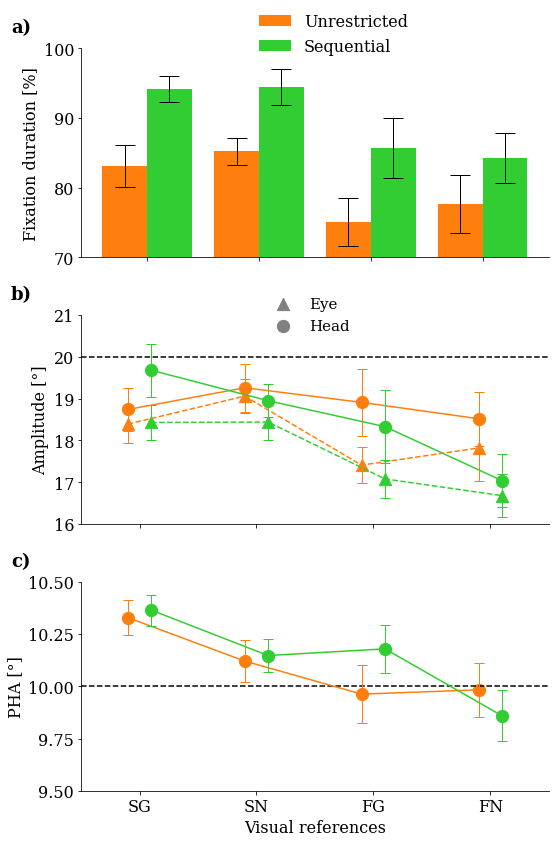

In [68]:
# exp 1 panel
fig = plt.figure(figsize=[8, 12], tight_layout=True)
gs = gridspec.GridSpec(3, 2)

ax2 = fig.add_subplot(gs[0, :])
# ax3 = fig.add_subplot(gs[0, 2:3])
# ax4 = fig.add_subplot(gs[0, 3:4])
ax1 = fig.add_subplot(gs[1, :])
ax5 = fig.add_subplot(gs[2, :])

axs = [ax1, ax2, ax5] # ax3, ax4, 
x_ticks = [1, 1.1, 1.2, 1.3]
labels = ["SG", "SN", "FG", "FN"]
# labels.reverse()

for ax in axs:
    ax.spines[['top', "right"]].set_visible(False)
    
# plot amplitudes
ax = ax1
ax.set_ylabel("Amplitude [°]", fontdict=font)
# ax.set_xlabel("Visual references")

ax.set_xticks(x_ticks)
ax.set_xticklabels([])
ax.set_xlim([0.95, 1.35])

ax.set_yticks([16, 17,18,19,20, 21])
ax.set_ylim([16, 21])

ax.hlines(y=20, xmin=0.95, xmax=1.35, ls="--", color="k")

for av, color in [["HeadMoveAmplitudeY", "tab:red"], ["SaccAmpTotal", "tab:blue"]]:
    exp2_amps_cut = exp2_amps.query('AV == @av').tail(8)
    
    # print_df(exp2_amps_cut)
    
    for part in ["tail", "head"]:
        if part == "head":
            exp2_eye_desc_cut_cut = exp2_amps_cut.head(4)
            label ="Sequential"
            color = colors["restricted"][0]
            coef = 0.01
        else:
            exp2_eye_desc_cut_cut = exp2_amps_cut.tail(4)
            label ="Unrestricted"
            color = colors["unrestricted"][0]
            coef = -0.01
        
        means = list(exp2_eye_desc_cut_cut["Mean"])
        ses = list(exp2_eye_desc_cut_cut["SE"])
        
        # means.reverse()
        # ses.reverse()
        
        cond_x_ticks = [x + coef for x in x_ticks]
        
        if av == "SaccAmpTotal":
            ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, marker="^") #, label=label
            ax.plot(cond_x_ticks, means, color=color, alpha=alpha, ls="--") #label=move, 
        else:
            ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150) #, label=label
            ax.plot(cond_x_ticks, means, color=color, alpha=alpha) #label=move, 
            
        ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c=color, linestyle="", capsize=5)

# plot fixation
ax = ax2
ax.set_ylabel("Fixation duration [%]")#, fontsize=12)
ax.set_yticks([70, 80, 90, 100])
ax.set_ylim([70, 100])
ax.set_xticks(x_ticks)
ax.set_xticklabels([])
# ax.set_xticklabels(reversed(labels))
# ax.set_xlabel("Visual references")
coef = 0

exp2_eye_desc_cut = exp2_eye_desc.query('AV == "RightCrossFixEyeDuringHeadMovementYPer"').tail(8)

# print_df(exp2_eye_desc_cut)
    
for part in ["tail", "head"]:
    if part == "head":
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.tail(4)
        color = colors["restricted"][0]
        coef = 0.02
        label = "Sequential"
    else:
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.head(4)
        color = colors["unrestricted"][0]
        coef = -0.02
        label = "Unrestricted"
    
    means = exp2_eye_desc_cut_cut["Mean"]
    ses = exp2_eye_desc_cut_cut["SE"]
    
    cond_x_ticks = [x + coef for x in x_ticks]
    ax.bar(cond_x_ticks, means, color=color, alpha=alpha, width =0.04, label=label) #label=move,  
    ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)

# plot psychometric examples
if False:
    run = "HeadEye"
    target = "PermanentTargets"
    gabor = "Gabor"

    for ax, sub in zip([ax3, ax4], ["AO23", "FS28"]):
        ax.hlines(y=0.5, xmin=-1.5, xmax=1.5, ls="--", color="k") # , alpha=0.25
        lims = [-1.6, 1.6]
        lims = [x+10 for x in lims]
        ax.set_xlim(lims)
        ax.set_ylim(-0.05, 1.05)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
        ticks = [-1.5, 0, 1.5]
        ticks = [x+10 for x in ticks]
        ax.set_xticks(ticks)
        # ax.set_xticklabels(["-1.5", "0", "1.5"])
        ax.set_xlabel("Reference [°]")
        
        if ax == ax4:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Perceived right [pr.]")#, fontsize=13)
            
        for move in ["Movement", "NoMovement"]:
            cut_pse_df = balanced_pse_df_2.query('SubjectID == @sub & Run == @run & Movement == @move & Target == @target & Gabor == @gabor')
            data_x = cut_pse_df["Lvl_Arr"].iloc[0]
            data_x = [x + 10 for x in data_x]
            data_y = cut_pse_df["Resp_Arr"].iloc[0]
            pse, jnd, pf_r2, pse_ir, points, x, y = fit_func(data_x, data_y, [0,0])

            color = colors["unrestricted"][0]
            label = "Unrestricted"
            
            if move == "NoMovement":
                color = colors["restricted"][0]
                label = "Restricted"

            lin_space = np.linspace(data_x[0], data_x[-1], 1000)
            ax.plot(lin_space, norm.cdf(lin_space, pse, jnd), color, ls="-", label=label)

            ax.plot(data_x, data_y, "o", ms=markersize, markerfacecolor=color, markeredgecolor=color) #, label=label
            ax.hlines(y=0.5, xmin=-3, xmax=3, ls="--", color="k", alpha=0.25)
            ax.vlines(x=pse, ymin=-1, ymax=2, ls="--", color=color, alpha=0.25)
    
# plot pha
ax = ax5
ax.set_ylim([9.5, 10.5])
ax.set_yticks([9.5, 9.75, 10, 10.25, 10.5])
ax.set_ylabel("PHA [°]")#, fontsize=14)
ax.set_xlabel("Visual references")#, fontsize=14)

ax.hlines(y=10, xmin=0.95, xmax=1.35, ls="--", color="k")
ax.set_xlim([0.95, 1.35])
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)

stat_df = balanced_pse_df_2.groupby(["SubjectID", "Run", "Movement", "Target", "Gabor"]).mean().reset_index()
stat_df = stat_df.query('Run == "HeadEye"')

means = []
ses = []

moves = ["Movement", "NoMovement"]

for move in moves:
    for target in ["PermanentTargets", "TemporaryTargets"]:
        for gabor in ["Gabor", "NoGabor"]:
            cut_df = stat_df.query('Movement == @move & Target == @target & Gabor == @gabor')
            
            vals = cut_df["PSE"]
            means.append(np.mean(vals))
            ses.append(np.std(vals) / np.sqrt(len(list(vals))))

for move in moves:
    coef = -0.01
    color = colors["unrestricted"][0]
    label = "Unrestricted"
    cond_means = means[:4]
    cond_ses = ses[:4]
    
    if move == "NoMovement":
        coef = 0.01
        color = colors["restricted"][0]
        label = "Restricted"
        cond_means = means[4:]
        cond_ses = ses[4:]
    
    cond_means = [x + 10 for x in cond_means]
    cond_x_ticks = [x + coef for x in x_ticks]
    
    # cond_means.reverse()
    # cond_ses.reverse()
    
    ax.scatter(cond_x_ticks, cond_means, color=color, alpha=alpha, s=150)
    ax.plot(cond_x_ticks, cond_means, color=color, alpha=alpha) #, label=label , width = 0.04
    ax.errorbar(cond_x_ticks, cond_means, yerr=cond_ses, lw=1, c=color, linestyle="", capsize=5)
    
# ax1.legend(loc="lower left", frameon=False)
# ax3.legend(frameon=False, bbox_to_anchor=(0.4, 0.97), loc='lower left', mode="expand", borderaxespad=0., bbox_transform=fig.transFigure)
# ax2.legend(frameon=False, loc='upper right', fontsize = 13) #bbox_to_anchor=(0.8, 1.02), mode="expand", , borderaxespad=0.
# ax2.legend(bbox_to_anchor=[0.275,1], frameon=False, fontsize=13)
# ax1.legend(loc="lower left", frameon=False)

ax2.legend(bbox_to_anchor=[0.35,0.9], frameon=False)

letters = ["b)", "a)", "d)"]
xpos = [-0.12, -0.27, -0.12]
ypos = [0.95, 1.1, 0.95]

# for idx, ax in enumerate([ax1,ax2,ax5]):
#     ax.text(xpos[idx], ypos[idx], letters[idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")

# ax1.text(0.785, 2.5, "ST", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")

letters = ["b)", "a)", "c)"]
xpos = [-0.15] * 3 #, -0.335, -0.15]
ypos = [1.1] *3

for idx, ax in enumerate([ax1,ax2,ax5]):
    ax.text(xpos[idx], ypos[idx], letters[idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")

ax1.scatter(0, 0, color="grey", alpha=alpha, s=150, label="Eye", marker="^")
ax1.scatter(0, 0, color="grey", alpha=alpha, s=150, label="Head")
ax1.legend(bbox_to_anchor=[0.37,0.85], frameon=False, fontsize=15)

plt.savefig(figure_p.joinpath("exp1_panel.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp1_panel.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.show()

In [69]:
# exp 1 panel - bar
fig = plt.figure(figsize=[10, 10], tight_layout=True)
gs = gridspec.GridSpec(3, 4)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[1, 2:3])
ax4 = fig.add_subplot(gs[1, 3:4])
ax5 = fig.add_subplot(gs[2, :])

axs = [ax1, ax2, ax3, ax4, ax5]
x_ticks = [1, 1.1, 1.2, 1.3]
labels = ["SG", "SN", "NG", "NN"]
# labels.reverse()

for ax in axs:
    ax.spines[['top', "right"]].set_visible(False)
    
# plot amplitudes
ax = ax1
ax.set_xlabel("Amplitude [°]", fontdict=font)
ax.set_ylabel("Visual references")

ax.set_yticks(x_ticks)
ax.set_yticklabels(labels)
ax.set_ylim([0.95, 1.35])

# ax.set_xticks([16, 1, 21])
ax.set_xlim([16, 21])

ax.vlines(x=20, ymin=0.95, ymax=1.35, ls="--", color="k")

for av, color in [["HeadMoveAmplitudeY", "tab:red"]]: #, ["Sub_Mean_Sacc_Amp", "tab:blue"]]:
    exp2_amps_cut = exp2_amps.query('AV == @av').tail(8)
    
    # print_df(exp2_amps_cut)
    
    for part in ["tail", "head"]:
        if part == "head":
            exp2_eye_desc_cut_cut = exp2_amps_cut.head(4)
            label ="Restricted"
            color = colors["restricted"][0]
            coef = 0.005
        else:
            exp2_eye_desc_cut_cut = exp2_amps_cut.tail(4)
            label ="Unrestricted"
            color = colors["unrestricted"][0]
            coef = -0.005
        
        means = exp2_eye_desc_cut_cut["Mean"]
        ses = exp2_eye_desc_cut_cut["SE"]
        
        cond_x_ticks = [x + coef for x in x_ticks]
        
        ax.scatter(means, cond_x_ticks, color=color, alpha=alpha, s=150, label=label)
        ax.plot(means, cond_x_ticks, color=color, alpha=alpha) #label=move, 
        ax.errorbar(means, cond_x_ticks, xerr=ses, lw=1, c="k", linestyle="", capsize=10)

# plot fixation
ax = ax2
ax.set_ylabel("Fixation duration [%]", fontdict=font)
ax.set_yticks([70, 80,90,100])
ax.set_ylim([70, 100])
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)
ax.set_xlabel("Visual references")
coef = 0

exp2_eye_desc_cut = exp2_eye_desc.query('AV == "RightCrossFixEyeDuringHeadMovementYPer"').tail(8)

# print_df(exp2_eye_desc_cut)
    
for part in ["tail", "head"]:
    if part == "head":
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.tail(4)
        color = colors["restricted"][0]
        coef = 0.02
    else:
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.head(4)
        color = colors["unrestricted"][0]
        coef = -0.02
    
    means = exp2_eye_desc_cut_cut["Mean"]
    ses = exp2_eye_desc_cut_cut["SE"]
    
    cond_x_ticks = [x + coef for x in x_ticks]
    ax.bar(cond_x_ticks, means, color=color, alpha=alpha, width =0.04, label=label) #label=move, 
    ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)

# plot psychometric examples
run = "HeadEye"
target = "PermanentTargets"
gabor = "Gabor"

for ax, sub in zip([ax3, ax4], ["AO23", "FS28"]):
    ax.hlines(y=0.5, xmin=-1.5, xmax=1.5, ls="--", color="k") # , alpha=0.25
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 0.25, 0.5, 0.75,1])
    ax.set_xticks([-1.5, 0, 1.5])
    ax.set_xticklabels(["-1.5", "0", "1.5"])
    ax.set_xlabel("Position [°]")
    
    if ax == ax4:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Perceived right [pr.]")
        
    for move in ["Movement", "NoMovement"]:
        cut_pse_df = balanced_pse_df_2.query('SubjectID == @sub & Run == @run & Movement == @move & Target == @target & Gabor == @gabor')
        data_x = cut_pse_df["Lvl_Arr"].iloc[0]
        data_y = cut_pse_df["Resp_Arr"].iloc[0]
        pse, jnd, pf_r2, pse_ir, points, x, y = fit_func(data_x, data_y, [0,0])

        color = colors["unrestricted"][0]
        if move == "NoMovement":
            color = colors["restricted"][0]

        lin_space = np.linspace(data_x[0], data_x[-1], 1000)
        ax.plot(lin_space, norm.cdf(lin_space, pse, jnd), color, ls="-")

        ax.plot(data_x, data_y, "o", ms=markersize, markerfacecolor=color, markeredgecolor=color, label=label)
        ax.hlines(y=0.5, xmin=-3, xmax=3, ls="--", color="k", alpha=0.25)
        ax.vlines(x=pse, ymin=-1, ymax=2, ls="--", color=color, alpha=0.25)
    
# plot pha
ax = ax5
ax.set_ylim([-0.3, 0.6])
ax.set_yticks([-0.3, 0, 0.3, 0.6])
ax.set_ylabel("PHA [°]")#, fontdict=font)
ax.set_xlabel("Visual references")

ax.hlines(y=0, xmin=0.95, xmax=1.35, ls="--", color="k")
ax.set_xlim([0.95, 1.35])
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)

stat_df = balanced_pse_df_2.groupby(["SubjectID", "Run", "Movement", "Target", "Gabor"]).mean().reset_index()
stat_df = stat_df.query('Run == "HeadEye"')

means = []
ses = []

moves = ["Movement", "NoMovement"]

for move in moves:
    for target in ["PermanentTargets", "TemporaryTargets"]:
        for gabor in ["Gabor", "NoGabor"]:
            cut_df = stat_df.query('Movement == @move & Target == @target & Gabor == @gabor')
            
            vals = cut_df["PSE"]
            means.append(np.mean(vals))
            ses.append(np.std(vals) / np.sqrt(len(list(vals))))

for move in moves:
    coef = -0.02
    color = colors["unrestricted"][0]
    label = "Unrestricted"
    cond_means = means[:4]
    cond_ses = ses[:4]
    
    if move == "NoMovement":
        coef = 0.02
        color = colors["restricted"][0]
        label = "Restricted"
        cond_means = means[4:]
        cond_ses = ses[4:]
    
    cond_x_ticks = [x + coef for x in x_ticks]
    # ax.scatter(cond_x_ticks, cond_means, color=color, alpha=alpha, s=150
    ax.bar(cond_x_ticks, cond_means, color=color, alpha=alpha, width = 0.04, label=label)
    ax.errorbar(cond_x_ticks, cond_means, yerr=cond_ses, lw=1, c="k", linestyle="", capsize=10)
    
ax1.legend(loc="lower left", frameon=False)

letters = ["a)", "b)", "d)"]
xpos = [-0.15, -0.355, -0.15]
ypos = [1.1] *3

for idx, ax in enumerate([ax1,ax2,ax5]):
    ax.text(xpos[idx], ypos[idx], letters[idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")

plt.savefig(figure_p.joinpath("exp1_panel_bar.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp1_panel_bar.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.close()

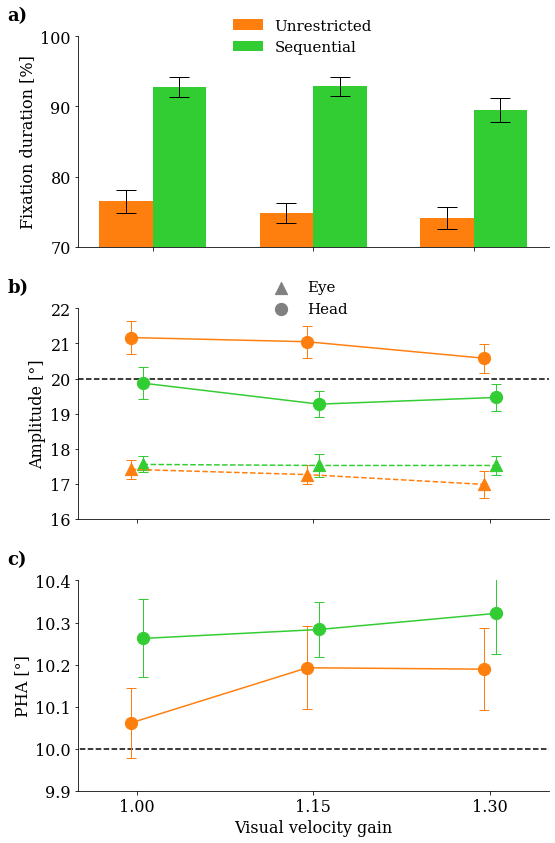

In [70]:
# exp 3 panel
fig = plt.figure(figsize=[8, 12], tight_layout=True)
gs = gridspec.GridSpec(3, 2)

ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[0, :])
# ax3 = fig.add_subplot(gs[0, 2:3])
# ax4 = fig.add_subplot(gs[0, 3:4])
ax5 = fig.add_subplot(gs[2, :])

axs = [ax1, ax2, ax5]# ax3, ax4, 
x_ticks = [1,1.15,1.3]

for ax in axs:
    ax.spines[['top', "right"]].set_visible(False)
    
# plot amplitudes
ax = ax1
ax.set_ylabel("Amplitude [°]", fontdict=font)
# ax.set_xlabel("Visual velocity gain")

ax.set_xticks(x_ticks)# 
ax.set_xticklabels([])
ax.set_xlim([0.95, 1.35])

# ax.set_yticks([18, 19, 20, 21, 22])
ax.set_ylim([16, 22])

ax.hlines(y=20, xmin=0.95, xmax=1.35, ls="--", color="k", zorder=-1)
# coef = 0
# ax.hlines(y=20, xmin=0.99, xmax=1.31, ls="--", color="k")
# ax.set_xlim([0.99, 1.31])

exp3_amps = pd.concat([exp3_head_desc, exp3_eye_desc, exp3_sacc_amp])
for av, color in [["HeadMoveAmplitudeY", "tab:red"], ["Sub_Mean_Sacc_Amp", "tab:blue"]]:
    exp2_amps_cut = exp3_amps.query('AV == @av').tail(6)
    
    for part in ["tail", "head"]:
        if part == "head":
            exp2_eye_desc_cut_cut = exp2_amps_cut.head(3)
            label ="Sequential"
            color = colors["restricted"][0]
            coef = 0.005
        else:
            exp2_eye_desc_cut_cut = exp2_amps_cut.tail(3)
            label ="Unrestricted"
            color = colors["unrestricted"][0]
            coef = -0.005
    
        # print_df(exp2_eye_desc_cut_cut)
        
        means = exp2_eye_desc_cut_cut["Mean"]
        ses = exp2_eye_desc_cut_cut["SE"]
        
        cond_x_ticks = [x + coef for x in x_ticks]
        # ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label=label)
        # ax.plot(cond_x_ticks, means, color=color, alpha=alpha) #label=move, 
        # ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)
        
        if av == "Sub_Mean_Sacc_Amp":
            ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, marker="^") #, label=label
            ax.plot(cond_x_ticks, means, color=color, alpha=alpha, ls="--") #label=move, 
        else:
            ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150)#, label=label)
            ax.plot(cond_x_ticks, means, color=color, alpha=alpha) #label=move, 
            
        ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c=color, linestyle="", capsize=5)

# plot fixation
ax = ax2
ax.set_ylabel("Fixation duration [%]", fontdict=font)
ax.set_yticks([70, 80,90,100])
ax.set_ylim([70, 100])
ax.set_xticks(x_ticks)
# ax.set_xlabel("Visual velocity gain")
ax.set_xticklabels([])
coef = 0

exp2_eye_desc_cut = exp3_amps.query('AV == "RightCrossFixEyeDuringHeadMovement_Y_per"').tail(6)
    
for part in ["tail", "head"]:
    if part == "head":
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.head(3)
        color = colors["restricted"][0]
        coef = 0.025
        label = "Sequential"
    else:
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.tail(3)
        color = colors["unrestricted"][0]
        coef = -0.025
        label = "Unrestricted"
    
    means = exp2_eye_desc_cut_cut["Mean"]
    ses = exp2_eye_desc_cut_cut["SE"]
    
    cond_x_ticks = [x + coef for x in x_ticks]
    ax.bar(cond_x_ticks, means, color=color, alpha=alpha, width =0.05, label=label) #label=move, 
    ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)

# plot psychometric examples
if False:
    sub1_move = [
        [0.22997986105436463, 0.4576917016037813],
        [-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37],
        [0.0, 0.0, 0.12, 0.25, 0.75, 0.88, 1.0]
    ]

    sub1_nomove = [
        [0.5133759548313096, 0.48310161804939566],
        [-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37],
        [0.0, 0.0, 0.0, 0.12, 0.5, 0.75, 1.0]
    ]

    sub2_move = [
        [-0.17858180089075915, 0.4403794838736386],
        [-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37],
        [0.0, 0.12, 0.25, 0.62, 1.0, 1.0, 1.0]
    ]

    sub2_nomove = [
        [0.5382047369764436, 0.5531316089135079],
        [-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37],
        [0.0, 0.0, 0.0, 0.25, 0.38, 0.75, 1.0]
    ]

    for ax_idx, ax in enumerate([ax3, ax4]):
        ax.hlines(y=0.5, xmin=-1.5, xmax=1.5, ls="--", color="k") # , alpha=0.25
        lims = [-1.5, 1.5]
        lims = [lim +10 for lim in lims]
        ax.set_xlim(lims)
        
        ax.set_ylim(-0.05, 1.05)
        ax.set_yticks([0, 0.25, 0.5, 0.75,1])
        ticks = [-1.5, 0, 1.5]
        ticks =[x+10 for x in ticks]
        ax.set_xticks(ticks)
        # ax.set_xticklabels(["-1.5", "0", "1.5"])
        ax.set_xlabel("Position [°]")
        
        if ax == ax4:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Perceived right [pr.]")
            
        if ax_idx == 0:
            data = [sub1_move, sub1_nomove]
        else:
            data = [sub2_move, sub2_nomove]
            
        counter = 0
        for color, d in zip([colors["unrestricted"][0], colors["restricted"][0]], data):
            if counter == 0:
                label = "Unrestricted"
                counter = counter + 1
            else:
                label = "Restricted"
            
            pf, x, y = d
            pse, jnd = pf
            pse = pse +10
            
            x = [val+10 for val in x]
            
            lin_space = np.linspace(x[0], x[-1], 1000)
            ax.plot(lin_space, norm.cdf(lin_space, pse, jnd), color, ls="-", label=label)
            
            ax.plot(x, y, "o", ms=10, markerfacecolor=color, markeredgecolor=color)
            ax.vlines(x=pse, ymin=-1, ymax=2, ls="--", color=color, alpha=0.75)
    
# plot pha
ax = ax5
ax.set_ylim([9.9, 10.4])
ticks = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
ticks = [9.9, 10, 10.1, 10.2, 10.3, 10.4]
ax.set_yticks(ticks)
ax.set_ylabel("PHA [°]")#, fontdict=font)
ax.set_xlabel("Visual velocity gain")

ax.hlines(y=10, xmin=0.925, xmax=1.375, ls="--", color="k", zorder=-1)
ax.set_xlim([0.95, 1.35])
ax.set_xticks(x_ticks)

move_means = [0.06135042879588454, 0.1925481002053518, 0.18919091196866425]
move_ses = [0.08294348793093889, 0.0986417191512242, 0.0970970955430098]

nomove_means = [0.26217828424351974, 0.2835146609744875, 0.3217737670691291]
nomove_ses = [0.09266215790981087, 0.06608485024141351, 0.09587089243000532]

for move, data in [["Move", [move_means, move_ses]], ["NoMove", [nomove_means, nomove_ses]]]:
    means, ses = data
    
    coef = -0.005
    color = colors["unrestricted"][0]
    label = "Unrestricted"
    
    if move == "NoMove":
        coef = 0.005
        color = colors["restricted"][0]
        label = "Restricted"
        
    means = [x + 10 for x in means]
    
    cond_x_ticks = [x + coef for x in x_ticks]
    ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150) #, label=label
    ax.plot(cond_x_ticks, means, color=color, alpha=alpha) #label=move,  , width = 0.06
    ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c=color, linestyle="", capsize=5)
    
# ax1.legend(loc="upper right", frameon=False)
# ax1.legend(frameon=False, bbox_to_anchor=(0.3, 2.7), loc='lower left', mode="expand", borderaxespad=0.)
# ax3.legend(frameon=False, bbox_to_anchor=(-2, 1.5), loc='upper left', borderaxespad=0.)#, bbox_transform=fig.transFigure)

letters = ["b)", "a)", "c)"]
xpos = [-0.15] *3
ypos = [1.1] *3

for idx, ax in enumerate([ax1,ax2,ax5]):
    ax.text(xpos[idx], ypos[idx], letters[idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")

# ax1.text(0.1, 0.4, "c)", horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold", zorder=3)
# plt.text(1.125,1.3, "Ass", zorder=3)

# ax2.text(0,1.2,"Ass")

# ax1.legend(bbox_to_anchor=[0.325,0.325], frameon=False, fontsize=15)#, fontsize=13) # 
ax2.legend(bbox_to_anchor=[0.3,0.85], frameon=False, fontsize=15)#, fontsize=13) # 


ax1.scatter(0, 0, color="grey", alpha=alpha, s=150, label="Eye", marker="^")
ax1.scatter(0, 0, color="grey", alpha=alpha, s=150, label="Head")
ax1.legend(bbox_to_anchor=[0.37,0.9], frameon=False, fontsize=15)

# ax1.text(1, 8, "GT", font=font, color="k", fontsize=font_size+2, fontweight= "bold")# transform=ax.transAxes, horizontalalignment='left', verticalalignment='center', 

plt.savefig(figure_p.joinpath("exp3_panel.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp3_panel.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.show()

In [71]:
# add gt, pp (probe position)
# in ergebnissen wirklich alle figures beschrieben
# doch hautpsächlich auge, weniger vestibulär (discussion)

In [72]:
# exp 3 panel bar
fig = plt.figure(figsize=[10, 10], tight_layout=True)
gs = gridspec.GridSpec(3, 4)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[1, 2:3])
ax4 = fig.add_subplot(gs[1, 3:4])
ax5 = fig.add_subplot(gs[2, :])

axs = [ax1, ax2, ax3, ax4, ax5]
x_ticks = [1,1.15,1.3]

for ax in axs:
    ax.spines[['top', "right"]].set_visible(False)
    
# plot amplitudes
ax = ax1
ax.set_xlabel("Amplitude [°]", fontdict=font)
ax.set_ylabel("Visual velocity gain")

ax.set_yticks(x_ticks)
ax.set_ylim([0.95, 1.35])

ax.set_xticks([18.5, 19, 19.5, 20, 20.5, 21, 21.5, 22])
ax.set_xlim([18.5, 22])

ax.vlines(x=20, ymin=0.95, ymax=1.35, ls="--", color="k")
# coef = 0
# ax.hlines(y=20, xmin=0.99, xmax=1.31, ls="--", color="k")
# ax.set_xlim([0.99, 1.31])

exp3_amps = pd.concat([exp3_head_desc, exp3_eye_desc, exp3_sacc_amp])
for av, color in [["HeadMoveAmplitudeY", "tab:red"]]: #, ["Sub_Mean_Sacc_Amp", "tab:blue"]]:
    exp2_amps_cut = exp3_amps.query('AV == @av').tail(6)
    
    for part in ["tail", "head"]:
        if part == "head":
            exp2_eye_desc_cut_cut = exp2_amps_cut.head(3)
            label ="Restricted"
            color = colors["restricted"][0]
            coef = 0.0025
        else:
            exp2_eye_desc_cut_cut = exp2_amps_cut.tail(3)
            label ="Unrestricted"
            color = colors["unrestricted"][0]
            coef = -0.0025
    
        # print_df(exp2_eye_desc_cut_cut)
        
        means = exp2_eye_desc_cut_cut["Mean"]
        ses = exp2_eye_desc_cut_cut["SE"]
        
        cond_x_ticks = [x + coef for x in x_ticks]
        # ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label=label)
        # ax.plot(cond_x_ticks, means, color=color, alpha=alpha) #label=move, 
        # ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)
        
        ax.scatter(means, cond_x_ticks, color=color, alpha=alpha, s=150, label=label)
        ax.plot(means, cond_x_ticks, color=color, alpha=alpha) #label=move, 
        ax.errorbar(means, cond_x_ticks, xerr=ses, lw=1, c="k", linestyle="", capsize=10)

# plot fixation
ax = ax2
ax.set_ylabel("Fixation duration [%]", fontdict=font)
ax.set_yticks([70, 80,90,100])
ax.set_ylim([70, 100])
ax.set_xticks(x_ticks)
ax.set_xlabel("Visual velocity gain")
coef = 0

exp2_eye_desc_cut = exp3_amps.query('AV == "RightCrossFixEyeDuringHeadMovement_Y_per"').tail(6)
    
for part in ["tail", "head"]:
    if part == "head":
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.head(3)
        color = colors["restricted"][0]
        coef = 0.025
    else:
        exp2_eye_desc_cut_cut = exp2_eye_desc_cut.tail(3)
        color = colors["unrestricted"][0]
        coef = -0.025
    
    means = exp2_eye_desc_cut_cut["Mean"]
    ses = exp2_eye_desc_cut_cut["SE"]
    
    cond_x_ticks = [x + coef for x in x_ticks]
    ax.bar(cond_x_ticks, means, color=color, alpha=alpha, width =0.05, label=label) #label=move, 
    ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)

# plot psychometric examples
sub1_move = [
    [0.22997986105436463, 0.4576917016037813],
    [-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37],
    [0.0, 0.0, 0.12, 0.25, 0.75, 0.88, 1.0]
]

sub1_nomove = [
    [0.5133759548313096, 0.48310161804939566],
    [-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37],
    [0.0, 0.0, 0.0, 0.12, 0.5, 0.75, 1.0]
]

sub2_move = [
    [-0.17858180089075915, 0.4403794838736386],
    [-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37],
    [0.0, 0.12, 0.25, 0.62, 1.0, 1.0, 1.0]
]

sub2_nomove = [
    [0.5382047369764436, 0.5531316089135079],
    [-1.37, -0.92, -0.46, 0.0, 0.46, 0.92, 1.37],
    [0.0, 0.0, 0.0, 0.25, 0.38, 0.75, 1.0]
]

for ax_idx, ax in enumerate([ax3, ax4]):
    ax.hlines(y=0.5, xmin=-1.5, xmax=1.5, ls="--", color="k") # , alpha=0.25
    ax.set_xlim([-1.5, 1.5])
    
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 0.25, 0.5, 0.75,1])
    ax.set_xticks([-1.5, 0, 1.5])
    ax.set_xticklabels(["-1.5", "0", "1.5"])
    ax.set_xlabel("Position [°]")
    
    if ax == ax4:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Perceived right [pr.]")
        
    if ax_idx == 0:
        data = [sub1_move, sub1_nomove]
    else:
        data = [sub2_move, sub2_nomove]
        
    for color, d in zip([colors["unrestricted"][0], colors["restricted"][0]], data):
        pf, x, y = d
        pse, jnd = pf
        lin_space = np.linspace(x[0], x[-1], 1000)
        ax.plot(lin_space, norm.cdf(lin_space, pse, jnd), color, ls="-")
        
        ax.plot(x, y, "o", ms=10, markerfacecolor=color, markeredgecolor=color)
        ax.vlines(x=pse, ymin=-1, ymax=2, ls="--", color=color, alpha=0.75)
    
# plot pha
ax = ax5
ax.set_ylim([-0.1, 0.5])
ax.set_yticks([-0.1, 0.1, 0.3, 0.5])
ax.set_ylabel("PHA [°]")#, fontdict=font)
ax.set_xlabel("Visual velocity gain")

ax.hlines(y=0, xmin=0.925, xmax=1.375, ls="--", color="k")
ax.set_xlim([0.925, 1.375])
ax.set_xticks(x_ticks)

move_means = [0.06135042879588454, 0.1925481002053518, 0.18919091196866425]
move_ses = [0.08294348793093889, 0.0986417191512242, 0.0970970955430098]

nomove_means = [0.26217828424351974, 0.2835146609744875, 0.3217737670691291]
nomove_ses = [0.09266215790981087, 0.06608485024141351, 0.09587089243000532]

for move, data in [["Move", [move_means, move_ses]], ["NoMove", [nomove_means, nomove_ses]]]:
    means, ses = data
    
    coef = -0.03
    color = colors["unrestricted"][0]
    label = "Unrestricted"
    
    if move == "NoMove":
        coef = 0.03
        color = colors["restricted"][0]
        label = "Restricted"
    
    cond_x_ticks = [x + coef for x in x_ticks]
    # ax.scatter(cond_x_ticks, means, color=color, alpha=alpha, s=150, label=label)
    ax.bar(cond_x_ticks, means, color=color, alpha=alpha, width = 0.06) #label=move, 
    ax.errorbar(cond_x_ticks, means, yerr=ses, lw=1, c="k", linestyle="", capsize=10)
    
ax1.legend(loc="upper right", frameon=False)

letters = ["a)", "b)", "d)"]
xpos = [-0.15, -0.355, -0.15]
ypos = [1.1] *3

for idx, ax in enumerate([ax1,ax2,ax5]):
    ax.text(xpos[idx], ypos[idx], letters[idx], horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold")

# ax1.text(0.1, 0.4, "c)", horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, font=font, color="k", fontsize=font_size+2, fontweight= "bold", zorder=3)
# plt.text(1.125,1.3, "Ass", zorder=3)

# ax2.text(0,1.2,"Ass")

plt.savefig(figure_p.joinpath("exp3_panel_bar.png"), facecolor="white", dpi=300, bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp3_panel_bar.pdf"), facecolor="white", dpi=300, bbox_inches="tight")
plt.close()

Main Sequence
Formula: y = 12.87 + 1.29x
Single subject slopes vs. 0 (one-sided): t(23) = 12.23, p = 0.0


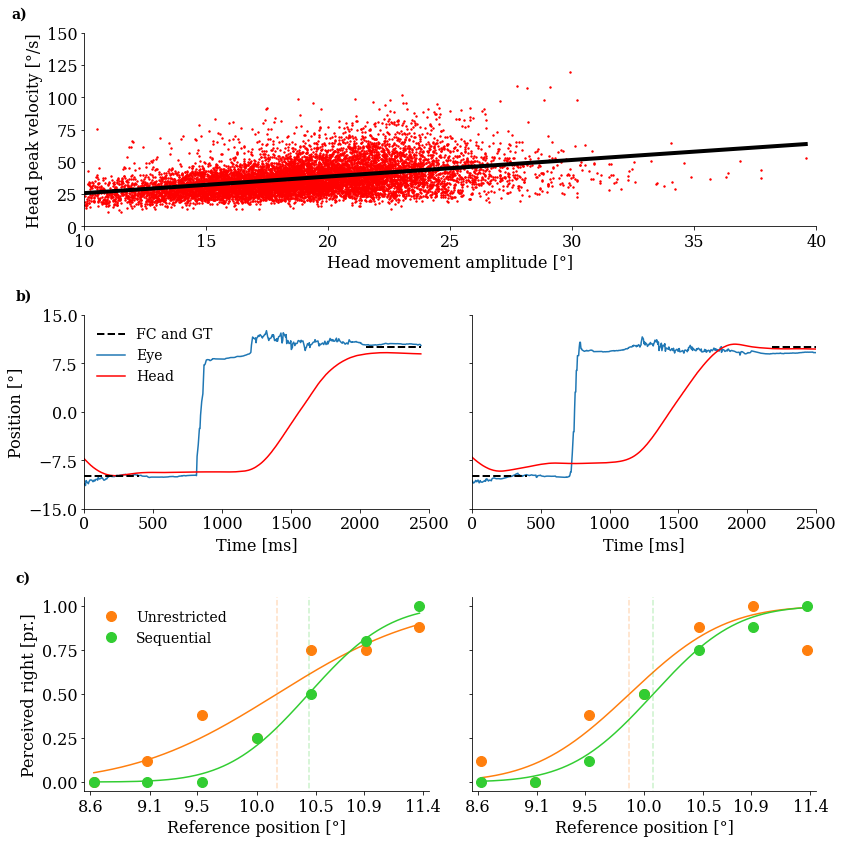

In [73]:
# head main sequence - exp 2
plot_data = move_data_2.query('Run == "HeadEye"')

fig = plt.figure(figsize=[12, 12], tight_layout=True)
gs = gridspec.GridSpec(3, 2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])

axs = [ax1, ax2, ax3, ax4, ax5]
letters = ["a)", "b)", "c)", "d)", "e)"]

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for idx, plot in enumerate(["Seq", "ExampleMove", "ExampleNoMove"]):
    ax = axs[idx]
    
    if plot == "Seq":
        end_positions = plot_data["HeadMoveAmplitudeY"] #main_sequence_plot_data["Scatter"]["EndPositions"]
        velocities = plot_data["HeadMovePeakVelocityY"] #main_sequence_plot_data["Scatter"]["Velocities"]
        plot_x = np.linspace(np.min(end_positions), np.max(end_positions), 1000)
        
        end_positions = [x for x in end_positions if not np.isnan(x)]
        velocities = [x for x in velocities if not np.isnan(x)]
        
        slope, intercept = curve_fit(lin_func, end_positions, velocities)[0]
        
        print("Main Sequence")
        print("Formula: y = {} + {}x".format(np.round(intercept, 2), np.round(slope, 2)))
        
        ax.scatter(end_positions, velocities, marker="o", color="r", s=2)#, alpha=0.5)
        ax.plot(plot_x, lin_func(plot_x, slope, intercept), color="k", linewidth=4)#, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
        
        ax.set_ylabel("Head peak velocity [°/s]")
        ax.set_xlabel("Head movement amplitude [°]")
        ax.set_xticks([10,15,20,25,30,35,40])
        ax.set_xlim([10, 40])
        ax.set_ylim([0, 150])
        
        # slope inference
        slopes = []
        
        for sub in np.unique(plot_data["SubjectID"]):
            sub_df = plot_data.query('SubjectID == @sub')
            end_positions = sub_df["HeadMoveAmplitudeY"]
            velocities = sub_df["HeadMovePeakVelocityY"]
            
            end_positions = [x for x in end_positions if not np.isnan(x)]
            velocities = [x for x in velocities if not np.isnan(x)]
            
            slope, intercept = curve_fit(lin_func, end_positions, velocities)[0]
            slopes.append(slope)
            
        t,p = ttest_1samp(slopes, popmean=0, alternative="greater")
        print("Single subject slopes vs. 0 (one-sided): t({}) = {}, p = {}".format(len(slopes) - 1, np.round(t,2), np.round(p,3)))
    elif plot == "ExampleMove":
        # LC10_HeadEye_Movement_TemporaryTargets_Gabor_60
        # LC10_HeadEye_Movement_TemporaryTargets_Gabor_53
        # LC10_HeadEye_Movement_TemporaryTargets_Gabor_52
        # LC10_HeadEye_Movement_TemporaryTargets_Gabor_50
        # LC10_HeadEye_Movement_TemporaryTargets_Gabor_18
        
        sub, run, move, target, gabor, trial = ["LC10", "HeadEye", "Movement", "TemporaryTargets", "Gabor", 18] # ALKA_Movement_23
        example_df = plot_data.query('SubjectID == @sub & Run == @run & Move == @move & Target == @target & Gabor == @gabor & Trial == @trial')

        trial_eye_df = example_df["EyeDF"].iloc[0]
        trial_head_df = example_df["HeadDF"].iloc[0]
        
        new_col = {"SDYaw": [np.nan] + list(trial_head_df["Yaw"])[:-1]}
        trial_head_df = trial_head_df.assign(**new_col)
        trial_head_df = trial_head_df.query('Yaw != SDYaw')
        
        new_col = {"SDEyeAngle_Y": [np.nan] + list(trial_eye_df["EyeAngle_Y"])[:-1]}
        trial_eye_df = trial_eye_df.assign(**new_col)
        trial_eye_df = trial_eye_df.query('SDEyeAngle_Y != EyeAngle_Y')
        
        # print_df(trial_eye_df.head(10))

        d_timing_files = np.sort(bf.get_data(stats_p.joinpath("effmann 2", "data","preprocessed"),"pickle","timings", []))
        timing_f = [x for x in d_timing_files if sub in x and "{}_{}_{}_{}_{}".format(sub, run, move, target, gabor) in x][0]
        timing_df = pd.read_pickle(timing_f)
        trial_timing_df = timing_df.query('Trial == @trial')

        trial, pre, start, end, f_onset, f_offset, s_onset, s_offset = trial_timing_df.iloc[0] 
        f_onset, f_offset, s_onset, s_offset = [(x - start) / 1_000_000 for x in [f_onset, f_offset, s_onset, s_offset]]

        example_trial_dict = {"EyeDF": trial_eye_df, "HeadDF": trial_head_df, "FirstStimulus": [f_onset, f_offset], "SecondStimulus": [s_onset, s_offset]}
        
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("Position [°]")
        ylims = [-15, 15]
        ax.set_ylim(ylims)
        ax.set_yticks([-15,-7.5,0,7.5,15])
        
        first_stim_info = example_trial_dict["FirstStimulus"]
        second_stim_info = example_trial_dict["SecondStimulus"]
        line_width = 1
        ax.hlines(-10, xmin=first_stim_info[0], xmax=first_stim_info[-1], color="k", ls="--", lw=line_width +1, zorder=10, label="FC and GT")
        ax.hlines(10, xmin=second_stim_info[0], xmax=second_stim_info[-1], color="k", ls="--", lw=line_width+1, zorder=10)
        
        eye_time = example_trial_dict["EyeDF"]["Time"]
        eye_pos = example_trial_dict["EyeDF"]["EyeAngle_Y"]
        
        head_time = example_trial_dict["HeadDF"]["Time"]
        head_pos = example_trial_dict["HeadDF"]["Yaw"]
        
        ax.plot(eye_time, eye_pos, color="tab:blue", label="Eye")
        ax.plot(head_time, head_pos, color="r", label="Head")
        
        times = list(eye_time) + list(head_time)
        ax.set_xlim([0, 2500])
        ax.legend(frameon=False, fontsize="14", loc="upper left") #, bbox_to_anchor=[1.2, 0.4]
    elif plot == "ExampleNoMove":
        # AD21_HeadEye_NoMovement_PermanentTargets_Gabor_15
        # ML27_HeadEye_NoMovement_TemporaryTargets_NoGabor_59
        # ML27_HeadEye_NoMovement_TemporaryTargets_NoGabor_43
        # ML27_HeadEye_NoMovement_TemporaryTargets_NoGabor_40
        # LC10_HeadEye_NoMovement_TemporaryTargets_NoGabor_63
        # LC10_HeadEye_NoMovement_TemporaryTargets_NoGabor_62
        sub, run, move, target, gabor, trial = ["LC10", "HeadEye", "NoMovement", "TemporaryTargets", "NoGabor", 63] # ALKA_Movement_23
        example_df = plot_data.query('SubjectID == @sub & Run == @run & Move == @move & Target == @target & Gabor == @gabor & Trial == @trial')
        
        # sub, move, trial = ["ALKA", "NoMovement", 65] # ALKA_Movement_23
        # example_df = move_data_2.query('SubjectID == @sub & Run == @move & Trial == @trial')

        trial_eye_df = example_df["EyeDF"].iloc[0]
        trial_head_df = example_df["HeadDF"].iloc[0]
        
        new_col = {"SDYaw": [np.nan] + list(trial_head_df["Yaw"])[:-1]}
        trial_head_df = trial_head_df.assign(**new_col)
        trial_head_df = trial_head_df.query('Yaw != SDYaw')
        
        new_col = {"SDEyeAngle_Y": [np.nan] + list(trial_eye_df["EyeAngle_Y"])[:-1]}
        trial_eye_df = trial_eye_df.assign(**new_col)
        trial_eye_df = trial_eye_df.query('SDEyeAngle_Y != EyeAngle_Y')

        d_timing_files = np.sort(bf.get_data(stats_p.joinpath("effmann 2", "data","preprocessed"),"pickle","timings", []))
        timing_f = [x for x in d_timing_files if sub in x and "{}_{}_{}_{}_{}".format(sub, run, move, target, gabor) in x][0]
        timing_df = pd.read_pickle(timing_f)
        trial_timing_df = timing_df.query('Trial == @trial')

        trial, pre, start, end, f_onset, f_offset, s_onset, s_offset = trial_timing_df.iloc[0] 
        f_onset, f_offset, s_onset, s_offset = [(x - start) / 1_000_000 for x in [f_onset, f_offset, s_onset, s_offset]]

        example_trial_dict = {"EyeDF": trial_eye_df, "HeadDF": trial_head_df, "FirstStimulus": [f_onset, f_offset], "SecondStimulus": [s_onset, s_offset]}
        
        ax.set_xlabel("Time [ms]")
        # ax.set_ylabel("Position [°]")
        ylims = [-15, 15]
        ax.set_ylim(ylims)
        ax.set_yticks([-15,-7.5,0,7.5,15])
        ax.set_yticklabels([])
        
        first_stim_info = example_trial_dict["FirstStimulus"]
        second_stim_info = example_trial_dict["SecondStimulus"]
        line_width = 1
        ax.hlines(-10, xmin=first_stim_info[0], xmax=first_stim_info[-1], color="k", ls="--", lw=line_width + 1, zorder=10, label="Fixation cross")
        ax.hlines(10, xmin=second_stim_info[0], xmax=second_stim_info[-1], color="k", ls="--", lw=line_width+1, zorder=10)
        
        eye_time = example_trial_dict["EyeDF"]["Time"]
        eye_pos = example_trial_dict["EyeDF"]["EyeAngle_Y"]
        
        head_time = example_trial_dict["HeadDF"]["Time"]
        head_pos = example_trial_dict["HeadDF"]["Yaw"]
        
        ax.plot(eye_time, eye_pos, color="tab:blue", label="Eye")
        ax.plot(head_time, head_pos, color="r", label="Head")
        
        times = list(eye_time) + list(head_time)
        ax.set_xlim([0, 2500])
        # ax.legend(loc="upper left", frameon=False, fontsize="11")
        
# plot psy funcs
run = "HeadEye"
target = "PermanentTargets"
gabor = "Gabor"

for ax, sub in zip([ax4, ax5], ["AO23", "FS28"]):
    ax.hlines(y=0.5, xmin=-1.5, xmax=1.5, ls="--", color="k") # , alpha=0.25
    lims = [-1.45, 1.45]
    lims = [x+10 for x in lims]
    ax.set_xlim(lims)
    
    ax.set_ylim(-0.05, 1.05)
    # ax.vlines(x=10, ymin=-0.05, ymax=1.05, ls="--", color="k") # , alpha=0.25
    
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ticks = [-1.37, -0.92, -0.46, 0, 0.46, 0.92, 1.37]
    ticks = [round(x+10,1) for x in ticks]
    ax.set_xticks(ticks)
    # ax.set_xticklabels(["-1.5", "0", "1.5"])
    ax.set_xlabel("Reference position [°]")
    
    if ax == ax5:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Perceived right [pr.]")#, fontsize=13)
        
    for move in ["Movement", "NoMovement"]:
        cut_pse_df = balanced_pse_df_2.query('SubjectID == @sub & Run == @run & Movement == @move & Target == @target & Gabor == @gabor')
        data_x = cut_pse_df["Lvl_Arr"].iloc[0]
        data_x = [x + 10 for x in data_x]
        data_y = cut_pse_df["Resp_Arr"].iloc[0]
        pse, jnd, pf_r2, pse_ir, points, x, y = fit_func(data_x, data_y, [0,0])

        color = colors["unrestricted"][0]
        label = "Unrestricted"
        
        if move == "NoMovement":
            color = colors["restricted"][0]
            label = "Sequential"

        lin_space = np.linspace(data_x[0], data_x[-1], 1000)
        ax.plot(lin_space, norm.cdf(lin_space, pse, jnd), color, ls="-")

        ax.plot(data_x, data_y, "o", ms=markersize, markerfacecolor=color, markeredgecolor=color, label=label) #, label=label
        ax.hlines(y=0.5, xmin=-3, xmax=3, ls="--", color="k", alpha=0.25)
        ax.vlines(x=pse, ymin=-1, ymax=2, ls="--", color=color, alpha=0.25)
        
# ax1.text(0.5, 0, letters[0], fontsize=14, fontweight= "bold", verticalalignment='center') #, , transform=ax.transAxes, , horizontalalignment='left'
ax4.legend(frameon=False, fontsize=14, loc="upper left") #, , bbox_to_anchor=[0.7,0.4]

letters = ["a)", "b)", "c)", "c)", "e)"]
for idx, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    if ax in [ax2,ax4]:
        ax.text(-0.2, 1.1, letters[idx], fontsize=14, fontweight= "bold", transform=ax.transAxes, horizontalalignment='left' , verticalalignment='center') #, 
    elif ax == ax1:
        ax.text(-0.1, 1.1, letters[idx], fontsize=14, fontweight= "bold", transform=ax.transAxes, horizontalalignment='left' , verticalalignment='center') #, 
    # else:
    #     ax.text(-0.1, 1.04, letters[idx], fontsize=14, fontweight= "bold", transform=ax.transAxes, horizontalalignment='left' , verticalalignment='center') #, 

plt.savefig(figure_p.joinpath("exp1_main_seq.png"), dpi=300, facecolor="white", bbox_inches="tight")
plt.savefig(figure_p.joinpath("exp1_main_seq.pdf"), dpi=300, facecolor="white", bbox_inches="tight")